# Analyse Trader's Activities when Optimizing an Online Advertising Campaign

In [1]:
#load the libraries and packages
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
from scipy.stats import norm
import glob

from sklearn.preprocessing import OneHotEncoder
import re

import json
from google.cloud import bigquery
from google.oauth2 import service_account


import google.auth
from google.cloud.bigquery_storage import BigQueryReadClient

from google.cloud.bigquery.table import TableReference
import pyarrow

## 1. Load the Data

### Performance Data

In [2]:
#set up the configurtions to access company's BigQuery 
service_account_info = json.load(open('KEYFILE.json'))
credentials = service_account.Credentials.from_service_account_info(service_account_info)
project_id = 'media-audit-platform'
client = bigquery.Client(credentials= credentials,project=project_id)


bqstorageclient = google.cloud.bigquery_storage.BigQueryReadClient(credentials=credentials)

In [3]:
query_job = client.query("""
   SELECT *
   FROM media-audit-platform.MailOnline_Ocean_Finance.MailOnline_Ocean_Finance_DV360_RawData
   """)

results = query_job.result()

In [4]:
query_job = client.query("""
   SELECT *
   FROM media-audit-platform.MailOnline_Readly.MailOnline_Readly_DV360_RawData
   """)

results = query_job.result()

In [5]:
# Download a table
table = bigquery.TableReference.from_string("media-audit-platform.MailOnline_Ocean_Finance.MailOnline_Ocean_Finance_DV360_RawData")
rows = client.list_rows(
table,
selected_fields=[
bigquery.SchemaField("Date", "DATE"),
bigquery.SchemaField("Campaign_ID", "INTEGER"),
bigquery.SchemaField("Insertion_Order_ID", "INTEGER"),  
bigquery.SchemaField("Line_Item_ID", "INTEGER"),
bigquery.SchemaField("Time_of_Day", "INTEGER"),
bigquery.SchemaField("Impressions", "INTEGER"),
bigquery.SchemaField("Clicks", "INTEGER"),
bigquery.SchemaField("Total_Conversions", "INTEGER"),
bigquery.SchemaField("Revenue_Adv_Currency", "FLOAT"),
],
)

of = rows.to_dataframe(bqstorage_client=bqstorageclient)

In [6]:
# Download a table
table = bigquery.TableReference.from_string("media-audit-platform.MailOnline_Readly.MailOnline_Readly_DV360_RawData")
rows = client.list_rows(
table,
selected_fields=[
bigquery.SchemaField("Date", "DATE"),
bigquery.SchemaField("Campaign_ID", "INTEGER"),
bigquery.SchemaField("Insertion_Order_ID", "INTEGER"),   
bigquery.SchemaField("Line_Item_ID", "INTEGER"),
bigquery.SchemaField("Time_of_Day", "INTEGER"),
bigquery.SchemaField("Impressions", "INTEGER"),
bigquery.SchemaField("Clicks", "INTEGER"),
bigquery.SchemaField("Total_Conversions", "INTEGER"),
bigquery.SchemaField("Revenue_Adv_Currency", "FLOAT"),
],
)

readly = rows.to_dataframe(bqstorage_client=bqstorageclient)

### SDF Data

In [7]:
query_job = client.query("""
   SELECT *
   FROM media-audit-platform.MailOnline_Ocean_Finance.MailOnline_Ocean_Finance_Prog_SDF_V5_LineItems
   """)

results = query_job.result()

In [8]:
query_job = client.query("""
   SELECT *
   FROM media-audit-platform.MailOnline_Readly.MailOnline_Readly_Prog_SDF_V5_LineItems
   """)

results = query_job.result()

In [9]:
# Download a table
table = bigquery.TableReference.from_string("media-audit-platform.MailOnline_Ocean_Finance.MailOnline_Ocean_Finance_Prog_SDF_V5_LineItems")
rows = client.list_rows(
table,
selected_fields=[ 
bigquery.SchemaField("Line_Item_Id", "INTEGER"),
bigquery.SchemaField("Bid_Strategy_Unit", "STRING"),
],
)

sdf_of = rows.to_dataframe(bqstorage_client=bqstorageclient)

In [10]:
# Download a table
table = bigquery.TableReference.from_string("media-audit-platform.MailOnline_Readly.MailOnline_Readly_Prog_SDF_V5_LineItems")
rows = client.list_rows(
table,
selected_fields=[ 
bigquery.SchemaField("Line_Item_Id", "INTEGER"),
bigquery.SchemaField("Bid_Strategy_Unit", "STRING"),
],
)

sdf_readly = rows.to_dataframe(bqstorage_client=bqstorageclient)

### Changes Log Data

In [11]:
#changes log dataset where downloaded manually into many csvs
#below are loaded and concatenated int oone dataframe
path = r'C:\working\MAP PROJECT\DATA\LineItems\Line Items1' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

#read all the csv
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#concatenate and generate a dataframe
line_item1 = pd.concat(li, axis=0, ignore_index=True)

path = r'C:\working\MAP PROJECT\DATA\LineItems\Line Items2' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

#read all the csv
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#concatenate and generate a dataframe
line_item2 = pd.concat(li, axis=0, ignore_index=True)

path = r'C:\working\MAP PROJECT\DATA\LineItems\Line Items3' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

#read all the csv
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

#concatenate and generate a dataframe
line_item3 = pd.concat(li, axis=0, ignore_index=True)

#final dataset including all chnages made on Line Item for all Campaigns
li = pd.concat([line_item1,line_item2,line_item3])

In [12]:
#select Ocean Finance data
of_traders = li.loc[li['Campaign name'] == 'OceanFinance_UK_2021_Q2_Apr_All_CPA']
of_traders = of_traders[['Time','User','Campaign ID','Insertion order ID','Line item ID','Change summary', 'Change detail']]

In [13]:
#select Readly data
readly_traders = li.loc[li['Campaign name'] == 'Readly_UK_2021_Q2_Apr_Web_CPA']
readly_traders = readly_traders[['Time','User','Campaign ID','Insertion order ID','Line item ID','Change summary', 'Change detail']]

## 2. Inspect the Data

In [14]:
of.head()
of.info()

,Date,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Time_of_Day,Impressions,Clicks,Total_Conversions,Revenue_Adv_Currency
0,2021-04-21,6073667,19606317,49407322,11,54,0,0,0.102162
1,2021-04-21,6073667,19606317,49407314,11,20,0,0,0.037896
2,2021-04-22,6073667,19606317,49407314,6,10,0,0,0.014402
3,2021-04-22,6073667,19606317,49407314,7,11,0,0,0.014481
4,2021-04-23,6073667,19606317,49407322,11,12,0,0,0.012175


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513049 entries, 0 to 4513048
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Date                  object 
 1   Campaign_ID           int64  
 2   Insertion_Order_ID    int64  
 3   Line_Item_ID          int64  
 4   Time_of_Day           int64  
 5   Impressions           int64  
 6   Clicks                int64  
 7   Total_Conversions     int64  
 8   Revenue_Adv_Currency  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 309.9+ MB


In [15]:
readly.head()
readly.info()

,Date,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Time_of_Day,Impressions,Clicks,Total_Conversions,Revenue_Adv_Currency
0,2021-04-12,5966728,19344160,48937705,14,8,0,0,0.007263
1,2021-04-13,5966728,19344160,48937705,21,9,0,0,0.009410
2,2021-04-13,5966728,19344160,48937705,22,12,0,0,0.018092
3,2021-04-14,5966728,19360151,48936866,8,8,0,0,0.028520
4,2021-04-14,5966728,19344160,48937705,14,10,0,0,0.035594


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34257145 entries, 0 to 34257144
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Date                  object 
 1   Campaign_ID           int64  
 2   Insertion_Order_ID    int64  
 3   Line_Item_ID          int64  
 4   Time_of_Day           int64  
 5   Impressions           int64  
 6   Clicks                int64  
 7   Total_Conversions     int64  
 8   Revenue_Adv_Currency  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 2.3+ GB


In [16]:
sdf_of.head()
sdf_readly.head()

,Line_Item_Id,Bid_Strategy_Unit
0,49264598,CPA
1,49264603,CPA
2,49407319,CPA
3,49412561,CPA
4,49407312,CPA


,Line_Item_Id,Bid_Strategy_Unit
0,48885946,CPA
1,48894114,CPA
2,48911781,CPA
3,48917180,CPA
4,48917181,CPA


In [17]:
of_traders.head()
of_traders.info()

,Time,User,Campaign ID,Insertion order ID,Line item ID,Change summary,Change detail
11356,2021-05-06 10:11:52 BT,dani.pastor@the-map.io,6073667,19546747,49264601,Revenue Model,Pixel List - Awct Id was set to 0
11357,2021-05-06 10:11:52 BT,dani.pastor@the-map.io,6073667,19546747,49264601,Revenue Model,Pixel List - Click Window Minutes was set to 4...
11358,2021-05-06 10:11:52 BT,dani.pastor@the-map.io,6073667,19546747,49264601,Revenue Model,Pixel List - Dfa Id was set to 11118272
11359,2021-05-06 10:11:52 BT,dani.pastor@the-map.io,6073667,19546747,49264601,Revenue Model,Pixel List - Enabled was set to 1
11360,2021-05-06 10:11:52 BT,dani.pastor@the-map.io,6073667,19546747,49264601,Revenue Model,Pixel List - View Window Minutes was set to 20160


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 11356 to 33401
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Time                8519 non-null   object
 1   User                8519 non-null   object
 2   Campaign ID         8519 non-null   int64 
 3   Insertion order ID  8519 non-null   int64 
 4   Line item ID        8519 non-null   int64 
 5   Change summary      8519 non-null   object
 6   Change detail       7934 non-null   object
dtypes: int64(3), object(4)
memory usage: 532.4+ KB


In [18]:
readly_traders.head()
readly_traders.info()

,Time,User,Campaign ID,Insertion order ID,Line item ID,Change summary,Change detail
29303,2021-05-20 14:46:09 BT,dani.pastor@the-map.io,5966728,19236555,48885946,Pending Change Reasons: [PARENT_CAMPAIGN_PAUSE...,NaN
29304,2021-05-20 14:46:09 BT,dani.pastor@the-map.io,5966728,19236555,48885946,User Status was changed from ACTIVE to PAUSED,NaN
29305,2021-05-20 14:46:08 BT,dani.pastor@the-map.io,5966728,19236555,48885946,Line Item changed,"Partner cost is ""Media fee with percentage of ..."
29306,2021-05-20 14:46:08 BT,dani.pastor@the-map.io,5966728,19236555,48885946,Line Item changed,"Partner cost is ""Media fee with percentage of ..."
29307,2021-05-20 14:46:08 BT,dani.pastor@the-map.io,5966728,19236555,48885946,Line Item changed,"Partner cost is ""Media fee with percentage of ..."


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9917 entries, 29303 to 12353
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Time                9917 non-null   object
 1   User                9917 non-null   object
 2   Campaign ID         9917 non-null   int64 
 3   Insertion order ID  9917 non-null   int64 
 4   Line item ID        9917 non-null   int64 
 5   Change summary      9917 non-null   object
 6   Change detail       8781 non-null   object
dtypes: int64(3), object(4)
memory usage: 619.8+ KB


## 3. Data Wrangling

### Check for Duplicates and Nulls

In [19]:
#check for duplicates
def duplicates(data):
    return data.duplicated().sum()

duplicates(of)
duplicates(readly)
duplicates(sdf_of)
duplicates(sdf_readly)
duplicates(of_traders)
duplicates(readly_traders)

2252273

25108823

0

0

2504

2055

In [20]:
#drop the duplicates
of = of.drop_duplicates()
readly = readly.drop_duplicates()
of_traders = of_traders.drop_duplicates()
readly_traders = readly_traders.drop_duplicates()

In [21]:
#check for nulls
def nulls(data):
    return data.isnull().sum().sum()

nulls(of)
nulls(readly)
nulls(sdf_of)
nulls(sdf_readly)
nulls(of_traders)
nulls(readly_traders)

0

0

0

0

585

1136

In [22]:
#fill the null values with a 'N/A' string to make our categorization in later stage easier
of_traders["Change detail"].fillna("N/A", inplace = True)
readly_traders["Change detail"].fillna("N/A", inplace = True)

#check
nulls(of_traders)
nulls(readly_traders)

0

0

### Derive new Forms of Data

In [23]:
#In of_traders and readly_traders dataset DATE and TIME are stored together
#Performance data stored them differently therefore it is better to follow the same forms of data
#below the date and time is separated into two different columns but for the purpose of this study only date will be used

#separate the date and create new column
of_traders['Time'] = of_traders['Time'].str[:-2]
of_traders['date'] = of_traders['Time'].str[:10]

readly_traders['Time'] = readly_traders['Time'].str[:-2]
readly_traders['date'] = readly_traders['Time'].str[:10]

### Converting Data Formats 

In [24]:
#Date and Time are stored as object, it is going to be better for our analysis later to convert them to datetime type
of["Date"] = pd.to_datetime(of["Date"])
readly["Date"] = pd.to_datetime(readly["Date"])
of_traders["date"] = pd.to_datetime(of_traders["date"])
readly_traders["date"] = pd.to_datetime(readly_traders["date"])

In [25]:
#it is important for our later analysis to be able to see and analyze our results by weekdays
#a new column is generated including the weekday names based on the dates
of_traders['weekday'] = of_traders['date'].dt.day_name()
readly_traders['weekday'] = readly_traders['date'].dt.day_name()

## 4. Performance Data Analysis

### Extract the Bid Strategy Unit (KPI) of each Line Item

In [26]:
# iterate over rows with iterrows() and based on the Bid strategy unit append the Line Itemd ID two lists
cpa_lst_of = []
cpc_lst_of = []

def strategy_unit_of(data):
    for index, row in data.iterrows():
        if row['Bid_Strategy_Unit'] == 'CPA':
            cpa_lst_of.append(row['Line_Item_Id'])
        else:
            cpc_lst_of.append(row['Line_Item_Id'])

In [27]:
strategy_unit_of(sdf_of)

In [28]:
of_cpa = of[of['Line_Item_ID'].isin(cpa_lst_of)]
of_cpc = of[of['Line_Item_ID'].isin(cpc_lst_of)]

In [29]:
cpa_lst_readly = []
cpc_lst_readly = []

def strategy_unit_readly(data):
    for index, row in data.iterrows():
        if row['Bid_Strategy_Unit'] == 'CPA':
            cpa_lst_readly.append(row['Line_Item_Id'])
        else:
            cpc_lst_readly.append(row['Line_Item_Id'])

In [30]:
strategy_unit_readly(sdf_readly)

In [31]:
#based on the Line Item IDs on each list generate two different dataframes
#one with the data associated with CPA and the other with data associated with CPC
readly_cpa = readly[readly['Line_Item_ID'].isin(cpa_lst_readly)]
readly_cpc = readly[readly['Line_Item_ID'].isin(cpc_lst_readly)]

### Calculate and Plot the Daily Cumulative KPI for each Line Item of each Campaign

In [32]:
def cpa(data):
    #from the dictionary of dataframes, take one dataframe at a time
    data = data_dict_cpa[key].copy()
    #group dataframe by Campaign ID, insertion order ID, line ited ID and date
    #aggregate the revenue and the conversions for each row
    grouped_multiple = data.groupby(['Campaign_ID','Insertion_Order_ID',
                                     'Line_Item_ID','Date']).agg({'Revenue_Adv_Currency':'sum',
                                                                  'Total_Conversions': 'sum', })
    #rename the columns 
    grouped_multiple.columns = ['Total Revenue','Total Conversions']
    grouped_multiple = grouped_multiple.reset_index()
    #calculate the CPA
    grouped_multiple['CPA'] = (grouped_multiple['Total Revenue']/grouped_multiple['Total Conversions']).round(2)
    #replace the infinite values with zeros
    grouped_multiple = grouped_multiple.replace([np.inf], 0)

    #to calculate the cumulative CPA calculate first the cumulative revenue and the cumulative conversions
    grouped_multiple['cumulative revenue'] = grouped_multiple['Total Revenue'].cumsum()
    grouped_multiple['cumulative conversions'] = grouped_multiple['Total Conversions'].cumsum()
    grouped_multiple['Cumulative CPA'] = (grouped_multiple['cumulative revenue']/grouped_multiple['cumulative conversions']).round(2)
    grouped_multiple = grouped_multiple.replace([np.inf], 0)
    
    #drop the unnecessary columns
    grouped_multiple = grouped_multiple.drop(columns=['Total Revenue','Total Conversions',
                                                      'cumulative revenue','cumulative conversions','CPA'])
    
    #add the new edited dataframe back to the dictionary
    data_dict_cpa[key] = grouped_multiple

    # Define plot space
    fig, ax = plt.subplots(figsize=(18,12))

    # Define x and y axes
    ax.plot(grouped_multiple.Date, 
            grouped_multiple['Cumulative CPA'],
           marker = 'o',
           color = 'red')

    ax.set(title = ("Cumulative CPA - Line Item ID" + ":",key),
       xlabel = "Date", 
        ylabel = "Cumulative CPA")

In [33]:
def cpc(data):
    data = data_dict_cpc[key].copy()
    #group dataframe by Campaign ID, insertion order ID, line ited ID and date
    #aggregate the revenue and the clicks for each row
    grouped_multiple = data.groupby(['Campaign_ID','Insertion_Order_ID',
                                     'Line_Item_ID','Date']).agg({'Revenue_Adv_Currency':'sum','Clicks': 'sum', })
    #rename the columns
    grouped_multiple.columns = ['Total Revenue','Total Clicks']
    grouped_multiple = grouped_multiple.reset_index()
    #calculate CPC
    grouped_multiple['CPC'] = (grouped_multiple['Total Revenue']/grouped_multiple['Total Clicks']).round(2)
    #replace infinite values with zeros
    grouped_multiple = grouped_multiple.replace([np.inf], 0)
    
    #to calculate the cumulative CPC calculate first the cumulative revenue and the cumulative clicks
    grouped_multiple['cumulative revenue'] = grouped_multiple['Total Revenue'].cumsum()
    grouped_multiple['cumulative clicks'] = grouped_multiple['Total Clicks'].cumsum()
    grouped_multiple['Cumulative CPC'] = (grouped_multiple['cumulative revenue']/grouped_multiple['cumulative clicks']).round(2)
    grouped_multiple = grouped_multiple.replace([np.inf], 0)
    
    grouped_multiple = grouped_multiple.drop(columns=['Total Revenue','Total Clicks',
                                                      'cumulative revenue','cumulative clicks','CPC'])
    
    data_dict_cpc[key] = grouped_multiple
    # Define plot space
    fig, ax = plt.subplots(figsize=(18,12))

    # Define x and y axes
    ax.plot(grouped_multiple.Date, 
            grouped_multiple['Cumulative CPC'],
           marker = 'o',
           color = 'green')

    ax.set(title = ("Cumulative CPC - Line Item ID" + ":",key),
       xlabel = "Date", 
        ylabel = "Cumulative CPC")

In [34]:
#create a dictionary of dataframes based on the line item id 
data_dict_cpa={'df'+str(i): grp for i , grp in of_cpa.groupby('Line_Item_ID')}
data_dict_cpc={'df'+str(i): grp for i , grp in of_cpc.groupby('Line_Item_ID')}

<ipython-input-32-b85d3774c947>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(18,12))


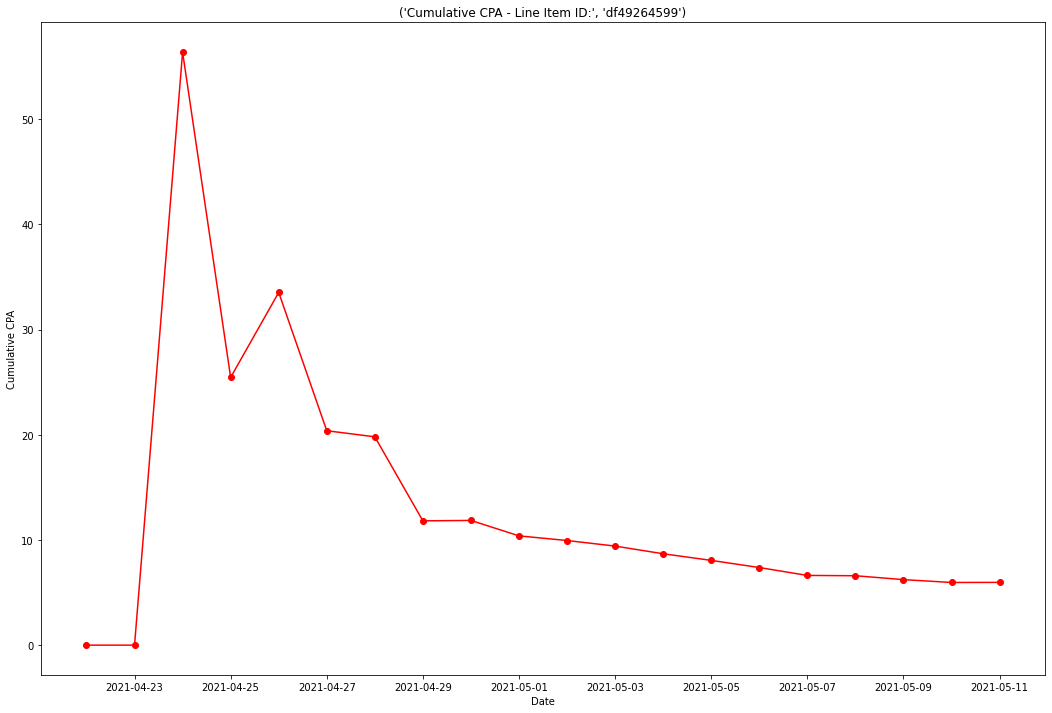

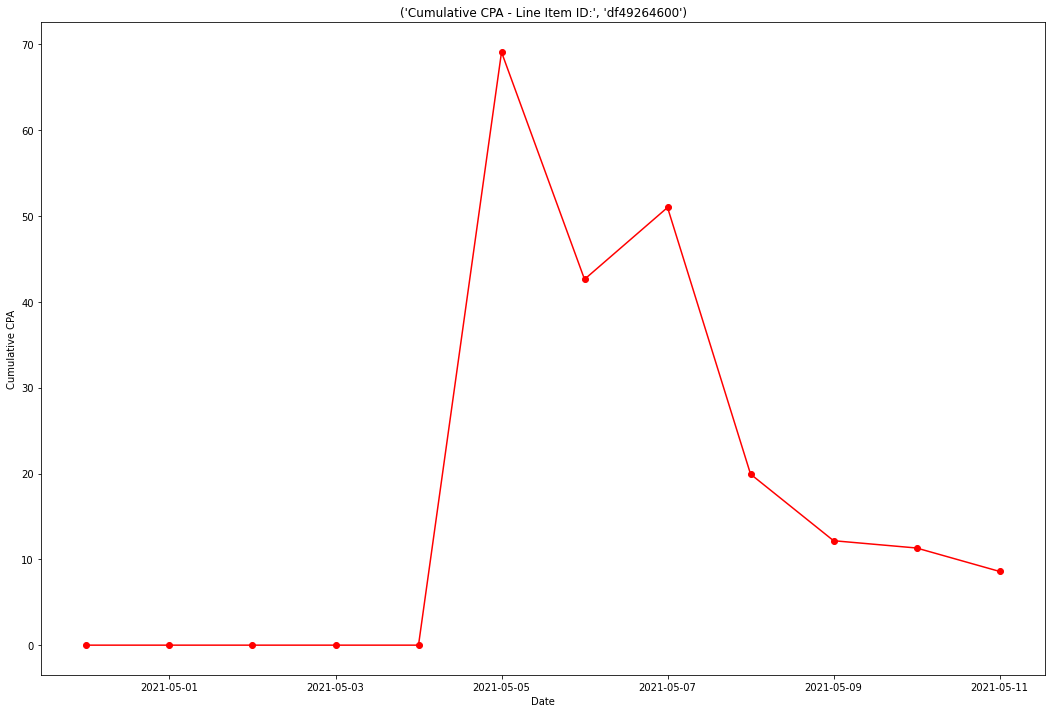

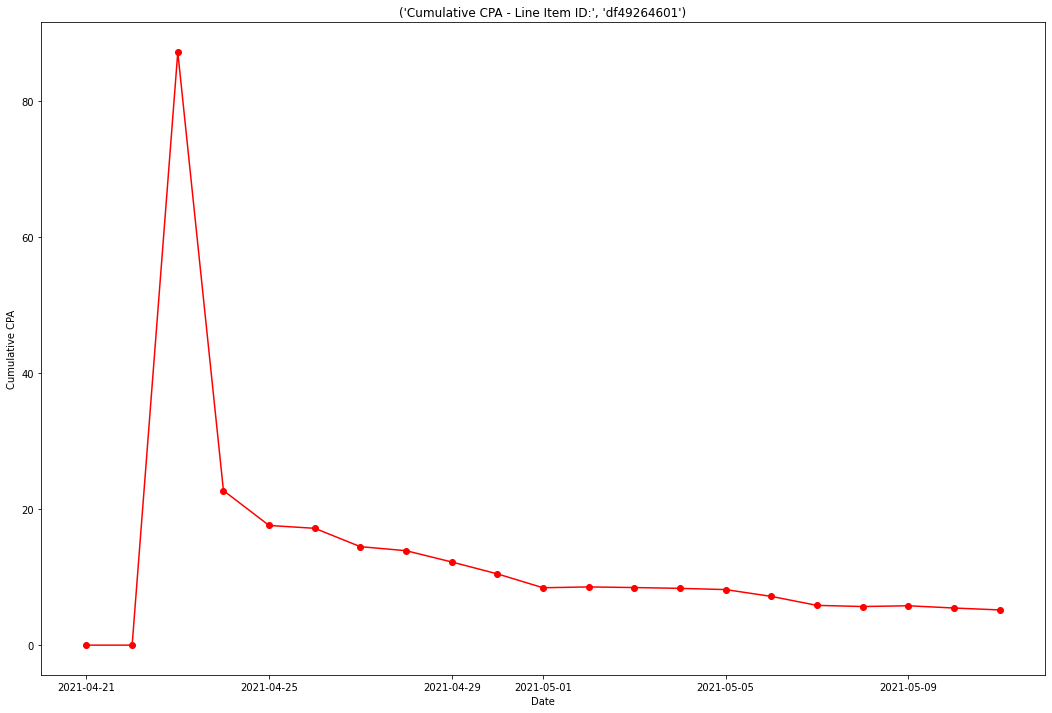

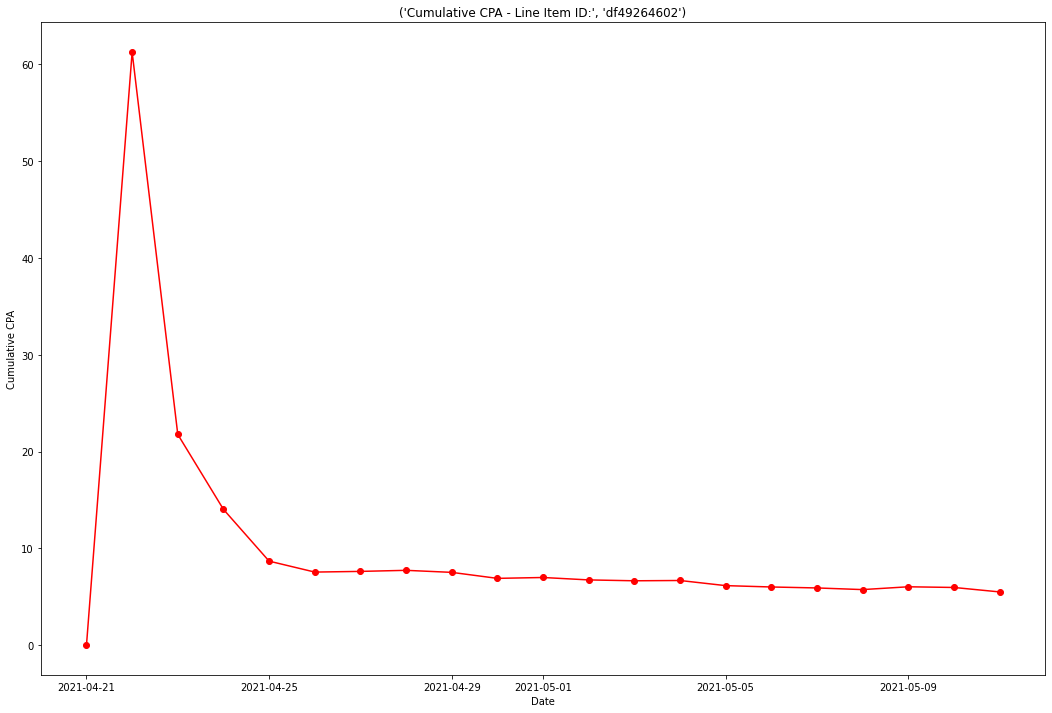

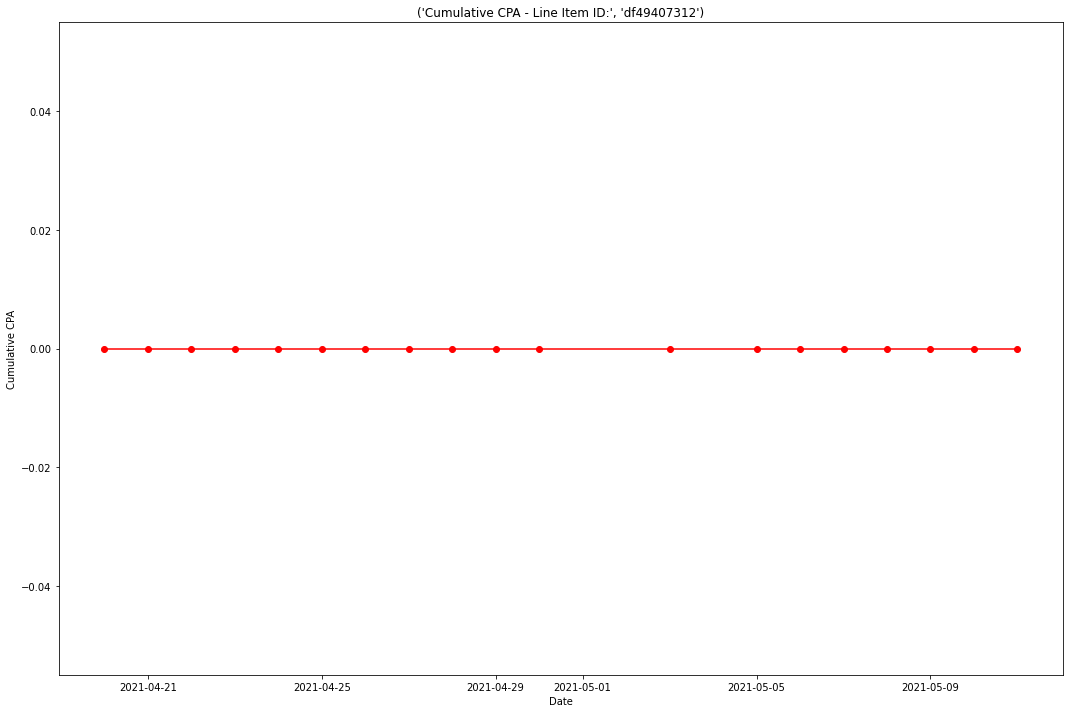

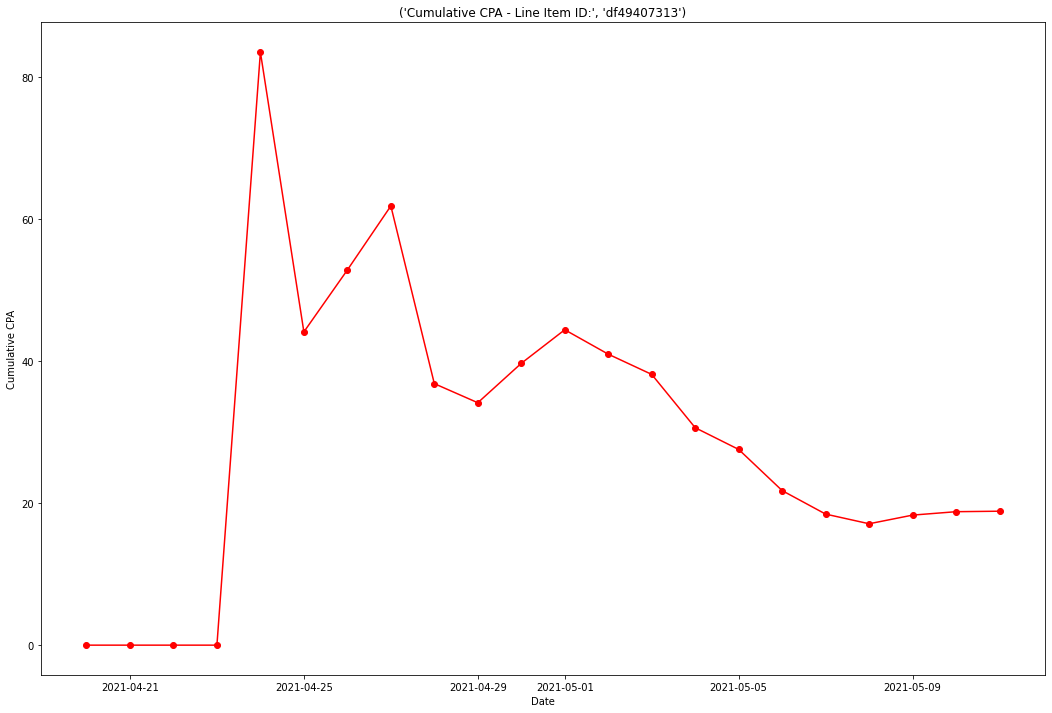

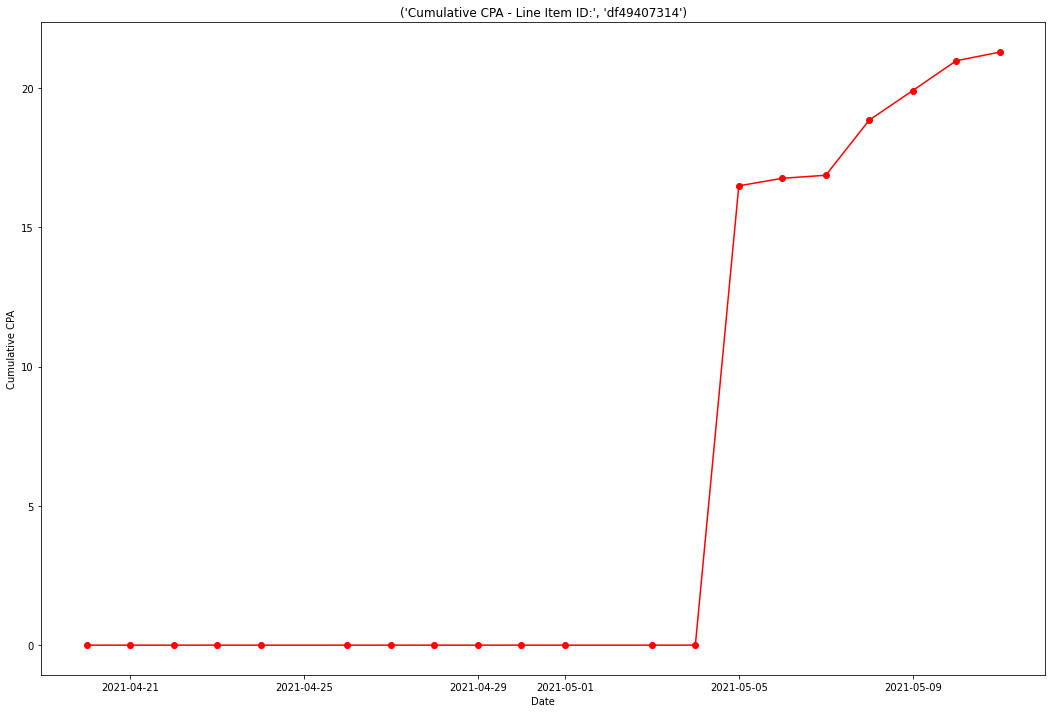

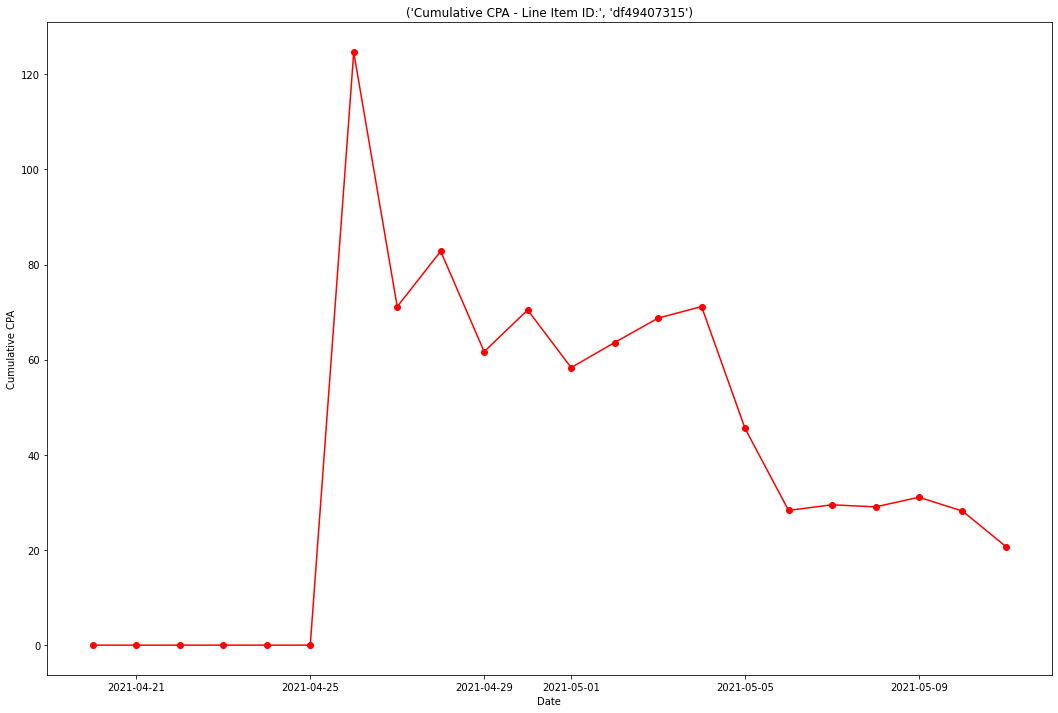

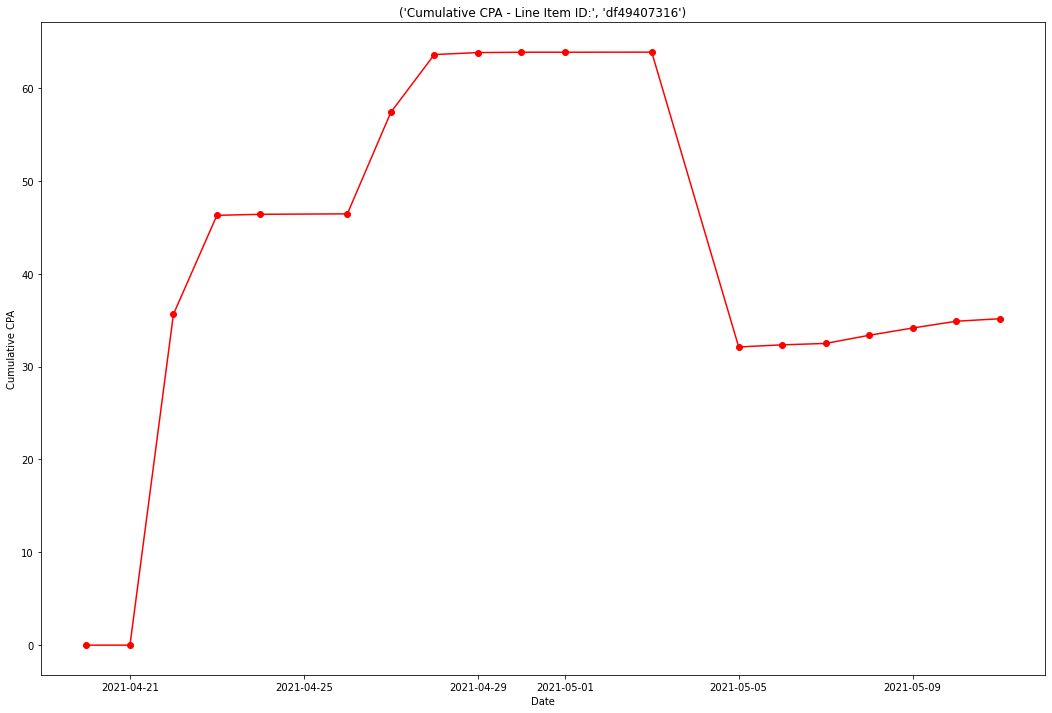

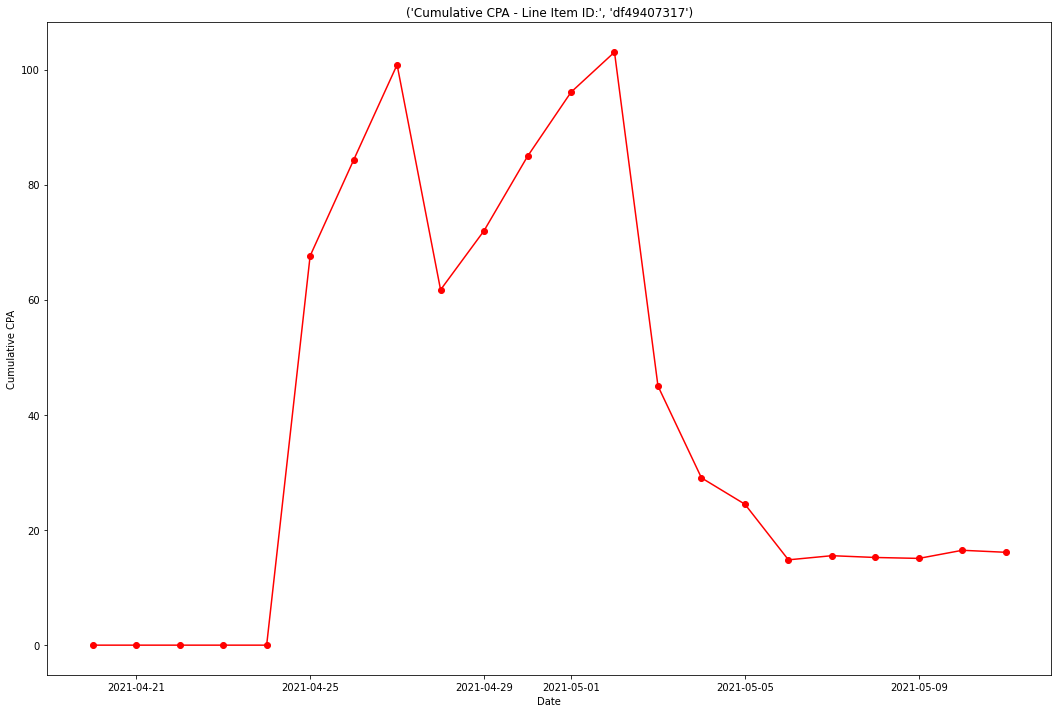

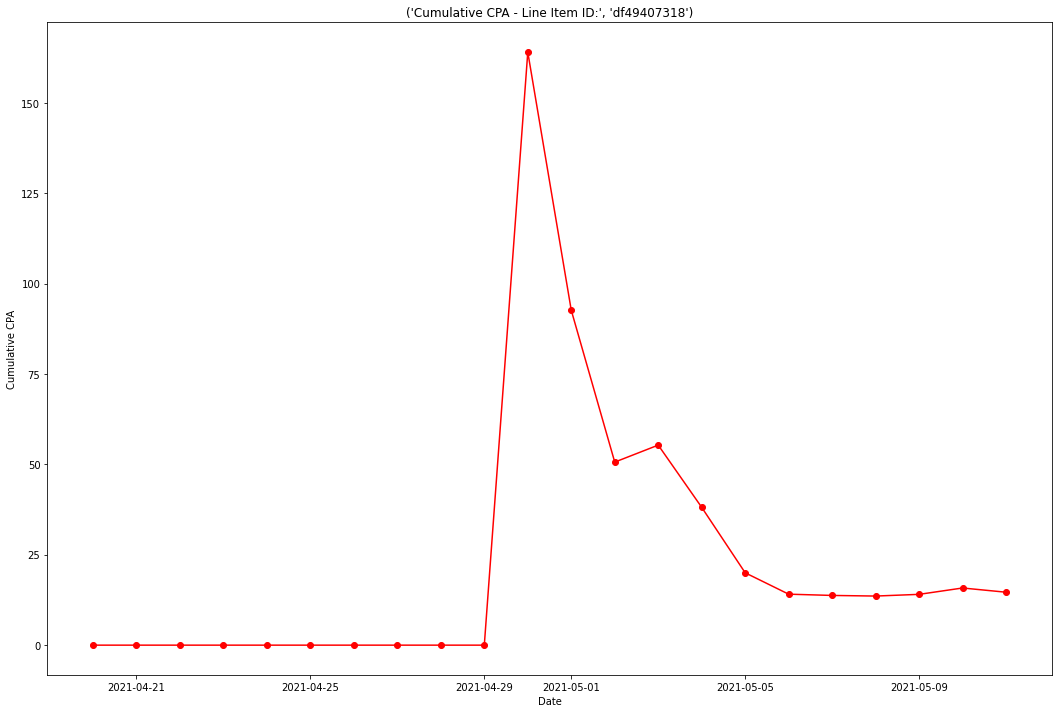

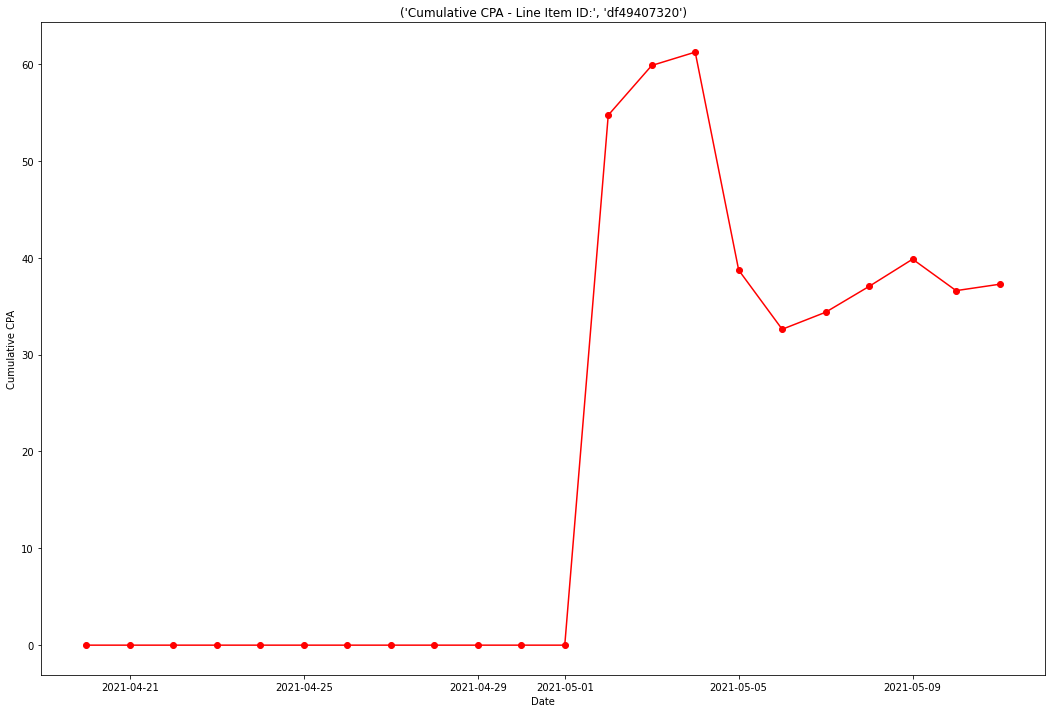

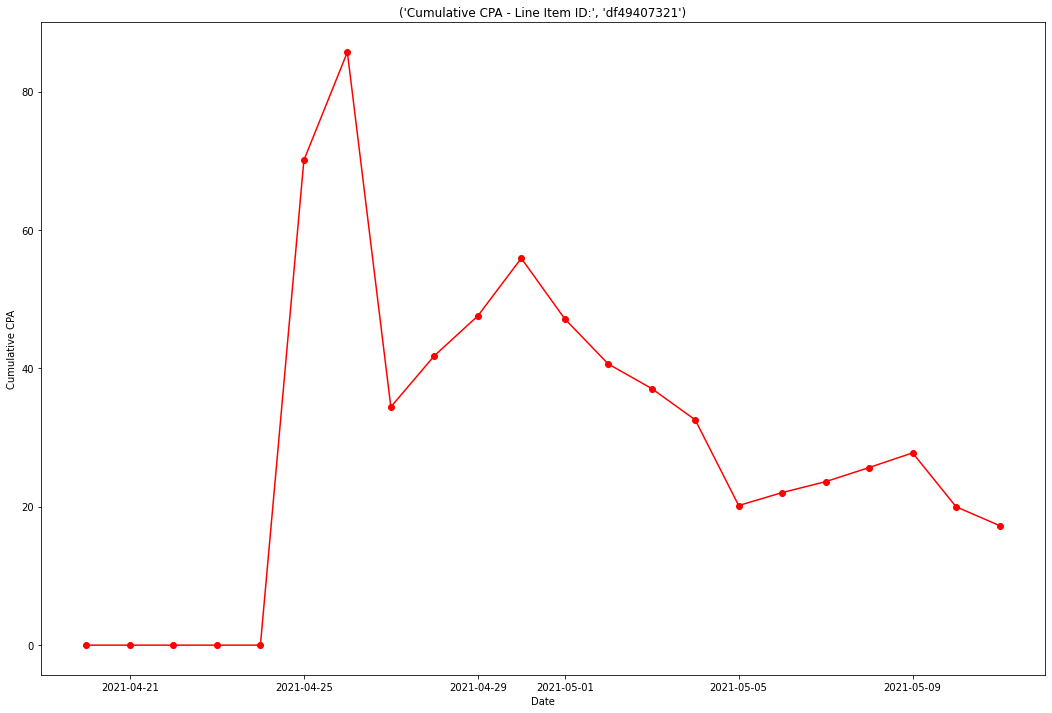

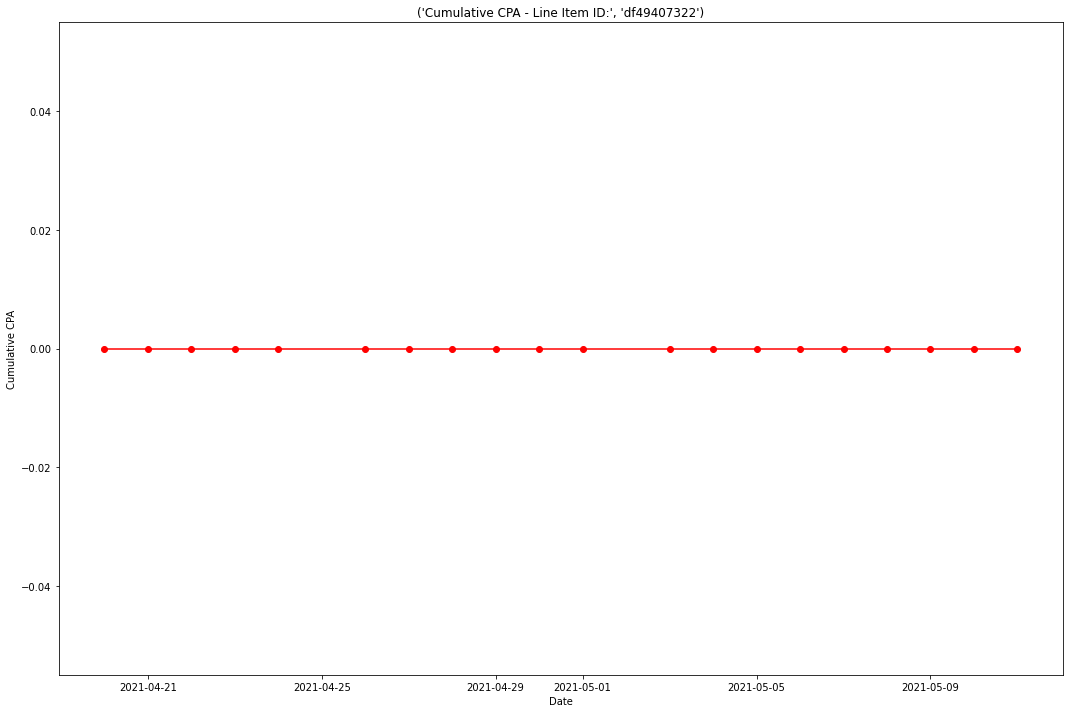

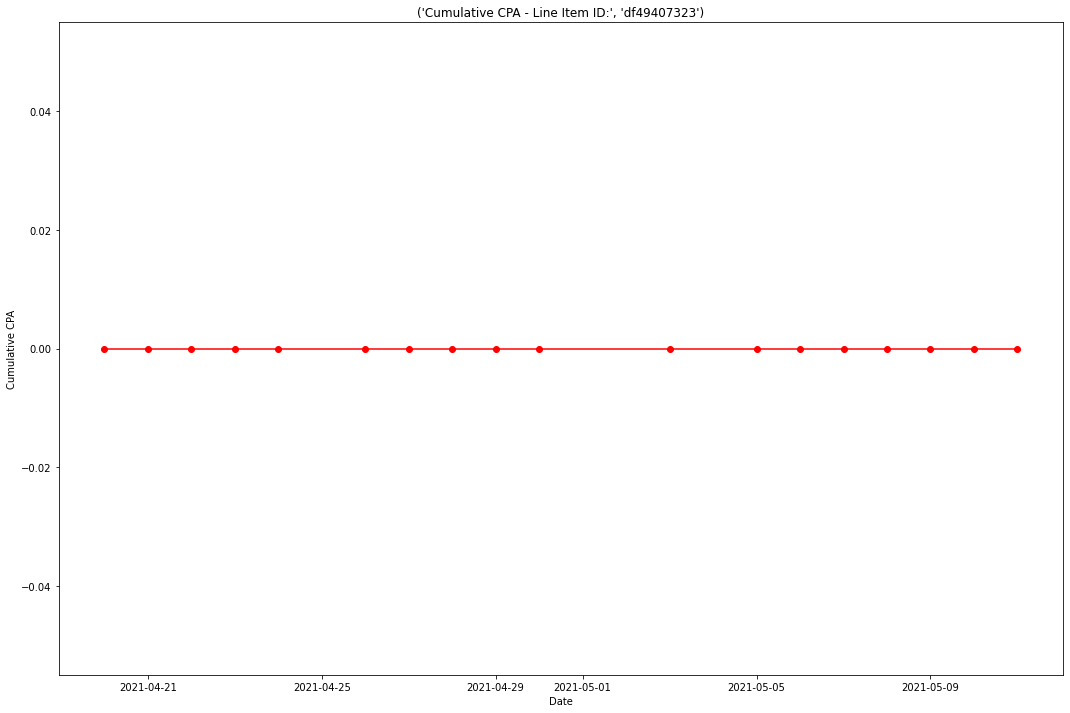

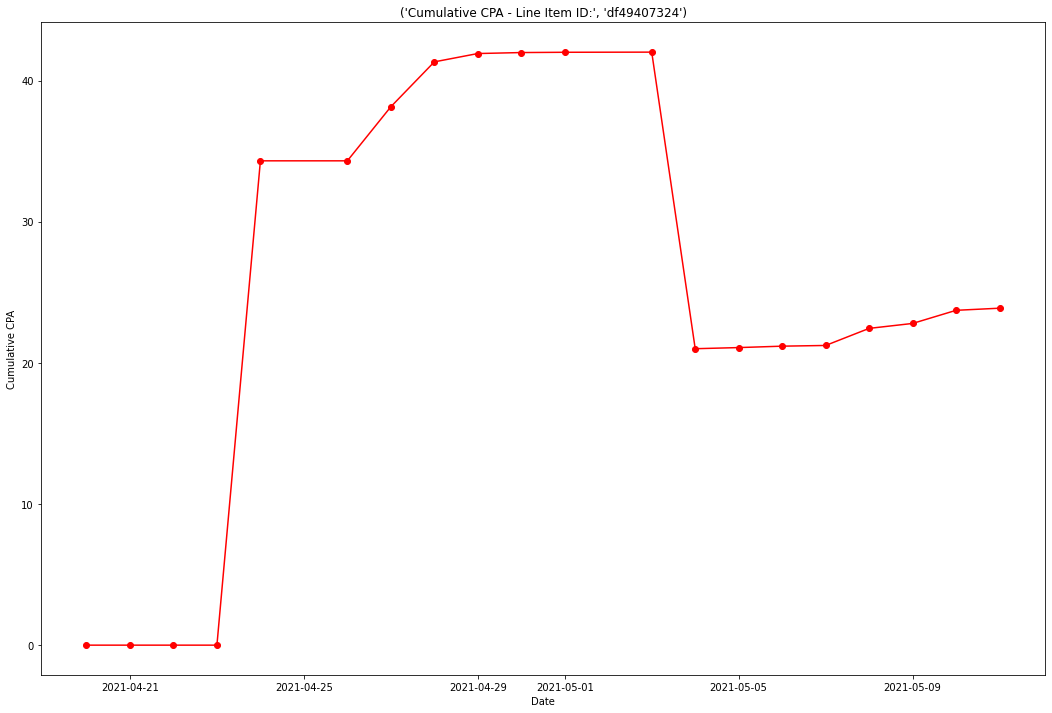

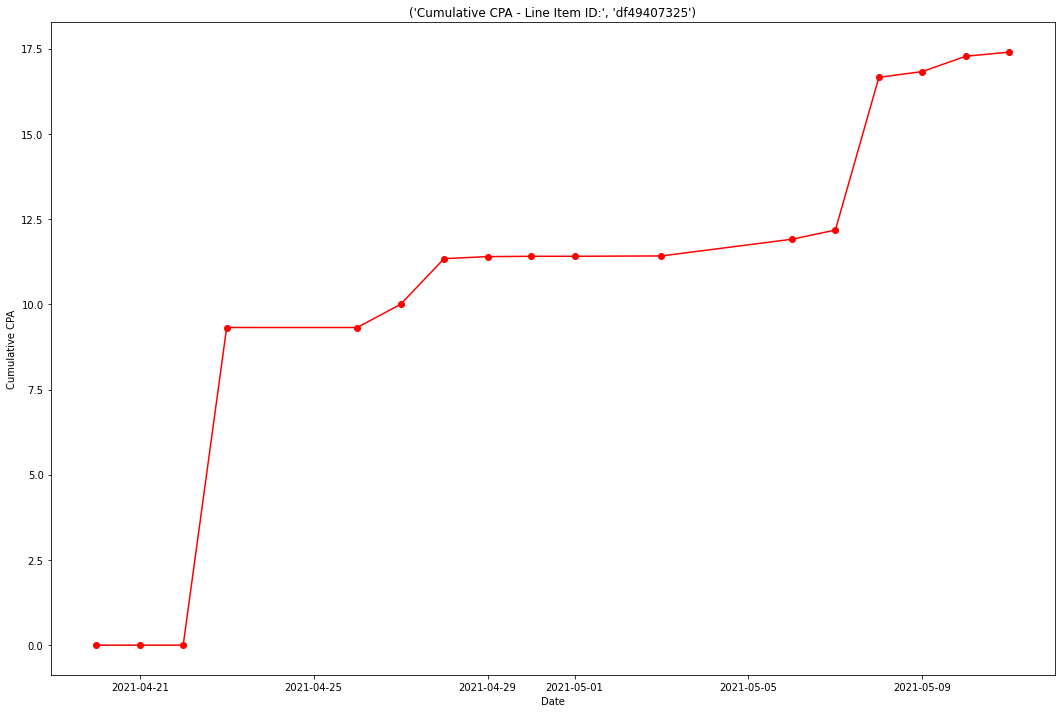

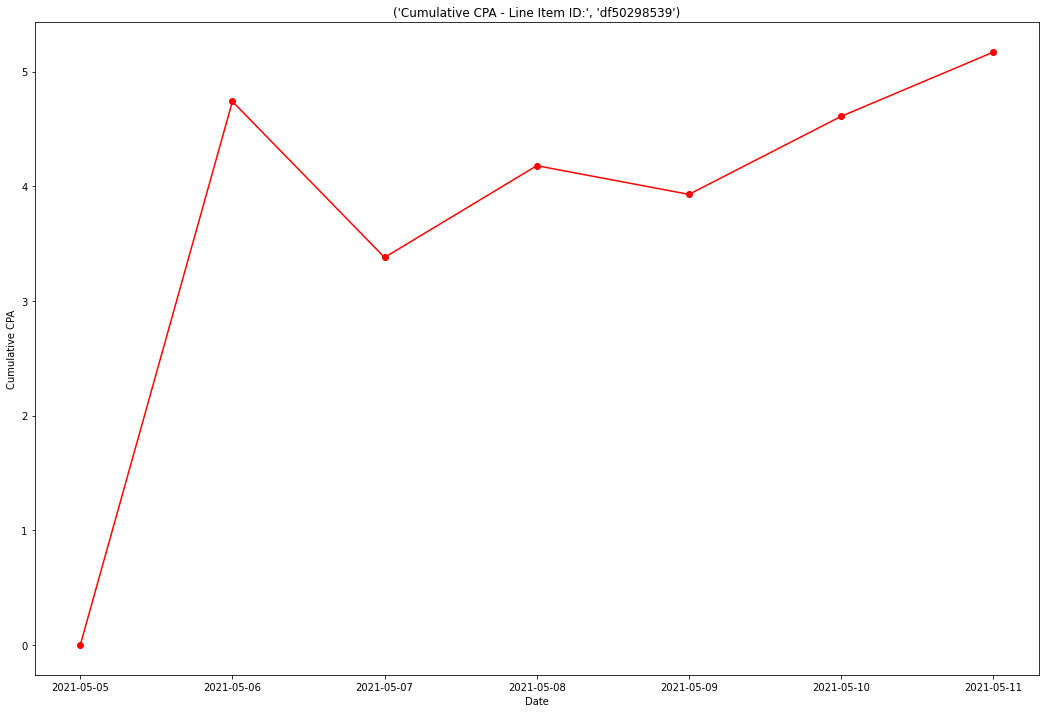

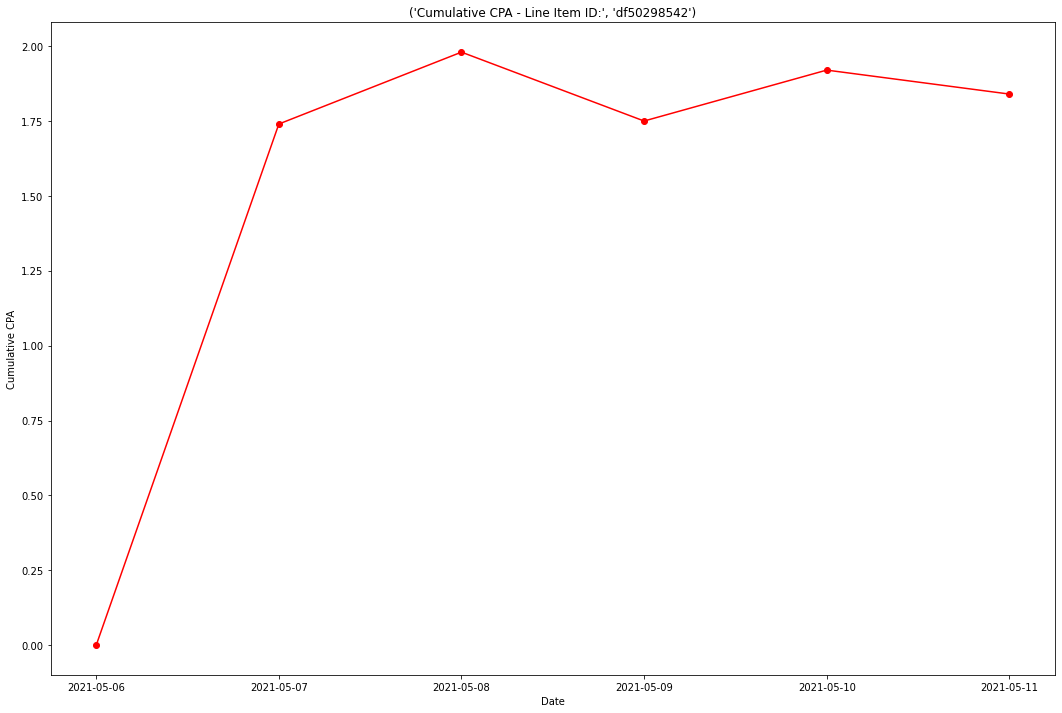

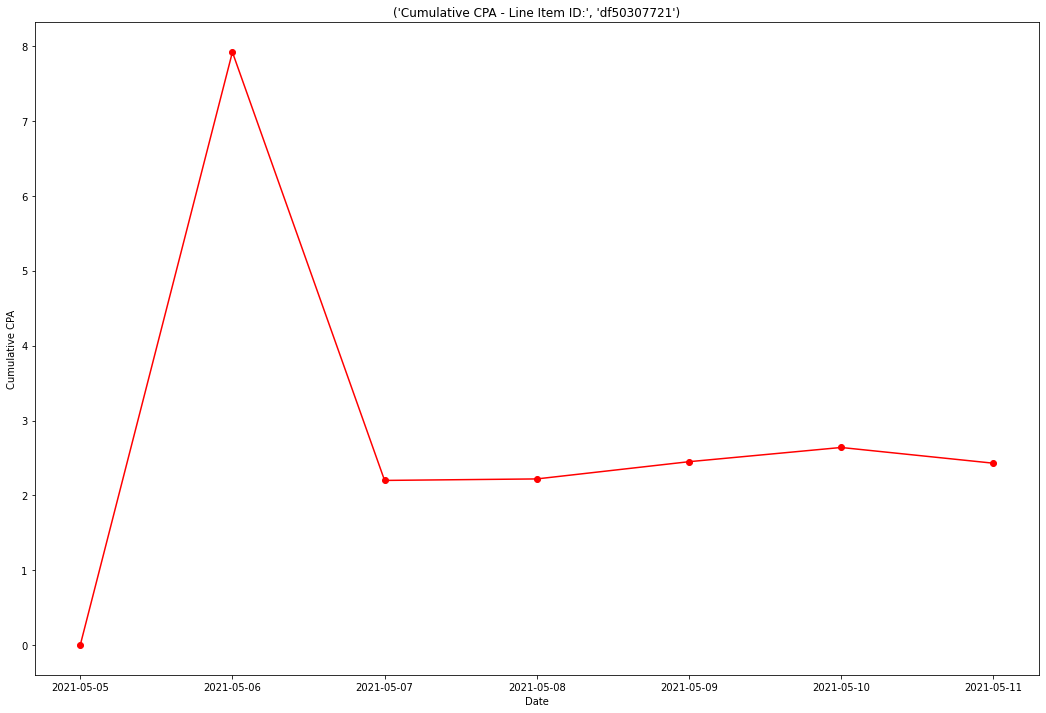

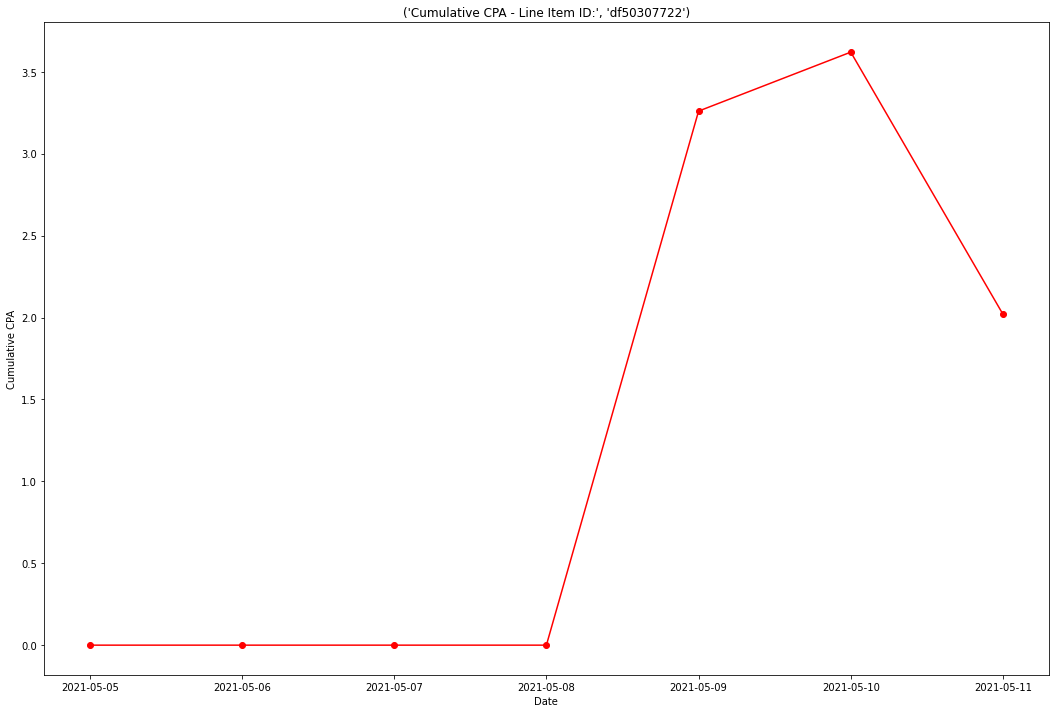

In [35]:
for key in data_dict_cpa.keys():
    cpa(key)

In [36]:
#concatenate the dataframes fro mthe dictionary
of_performance_cpa = pd.concat(data_dict_cpa.values())

In [37]:
#create a dictionary of dataframes based on the line item id 
data_dict_cpa={'df'+str(i): grp for i , grp in readly_cpa.groupby('Line_Item_ID')}
data_dict_cpc={'df'+str(i): grp for i , grp in readly_cpc.groupby('Line_Item_ID')}

<ipython-input-32-b85d3774c947>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(18,12))


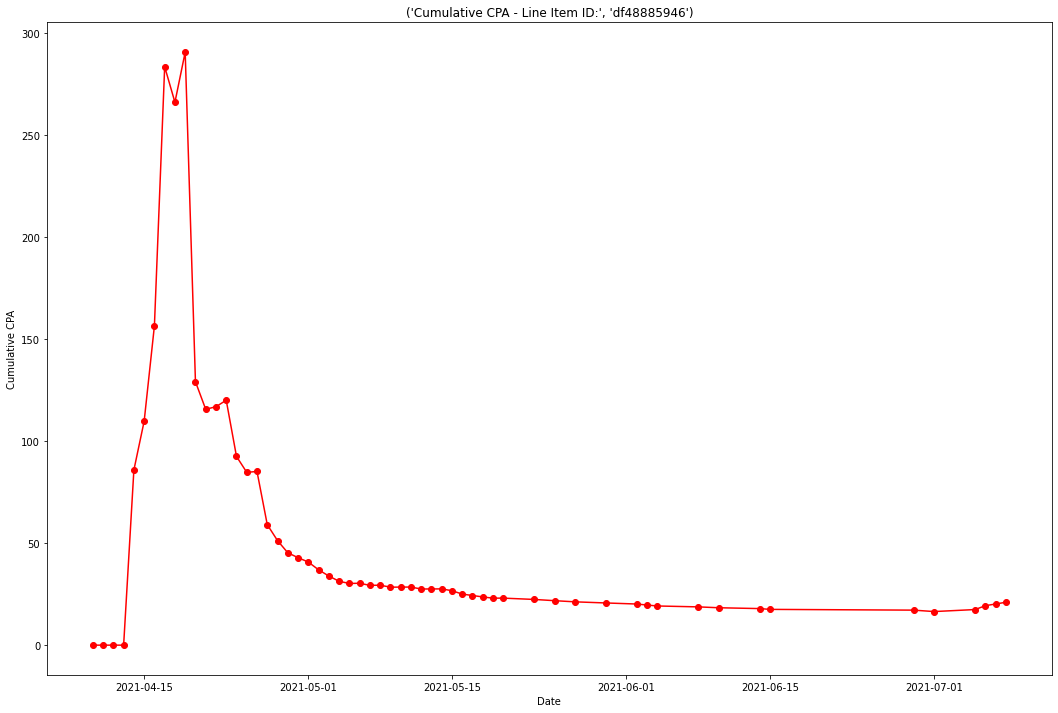

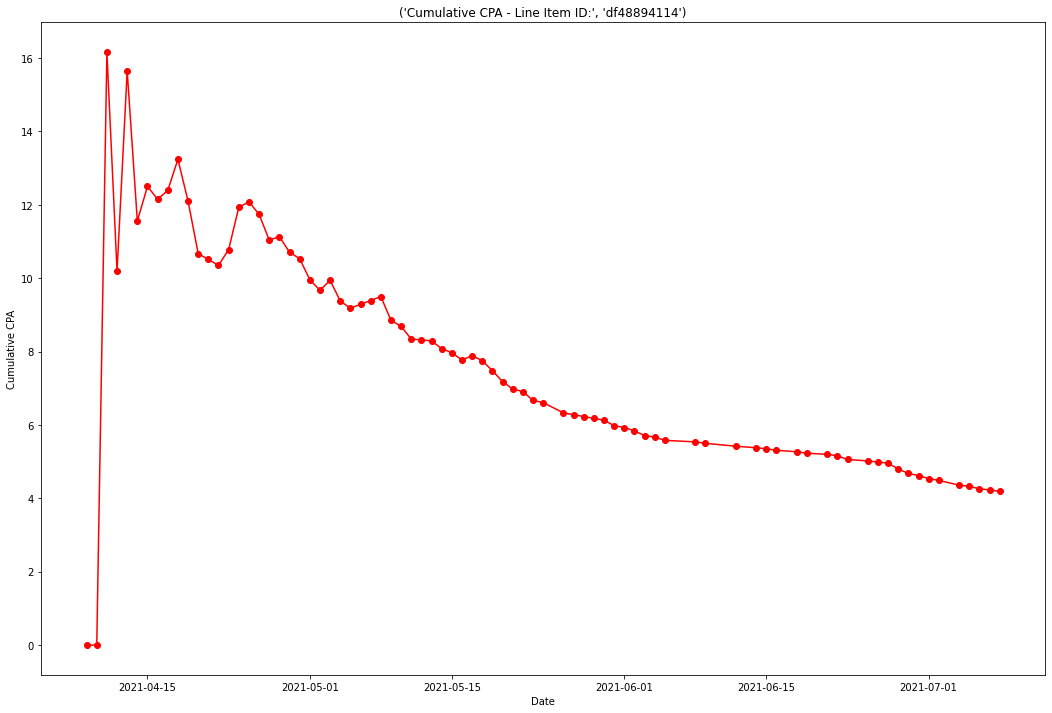

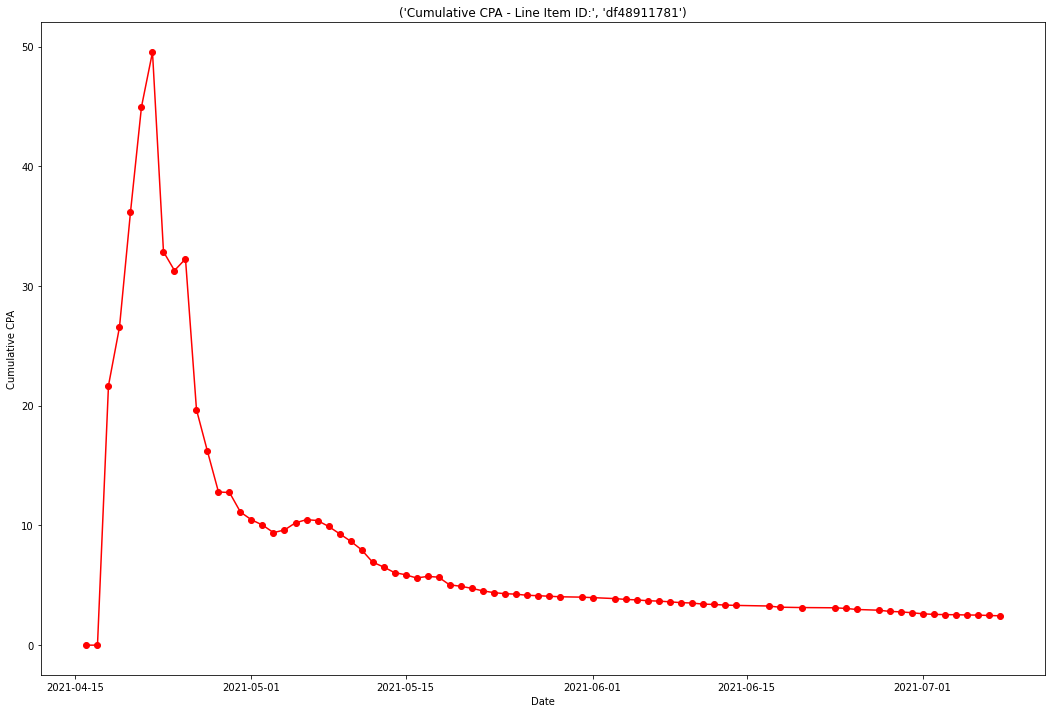

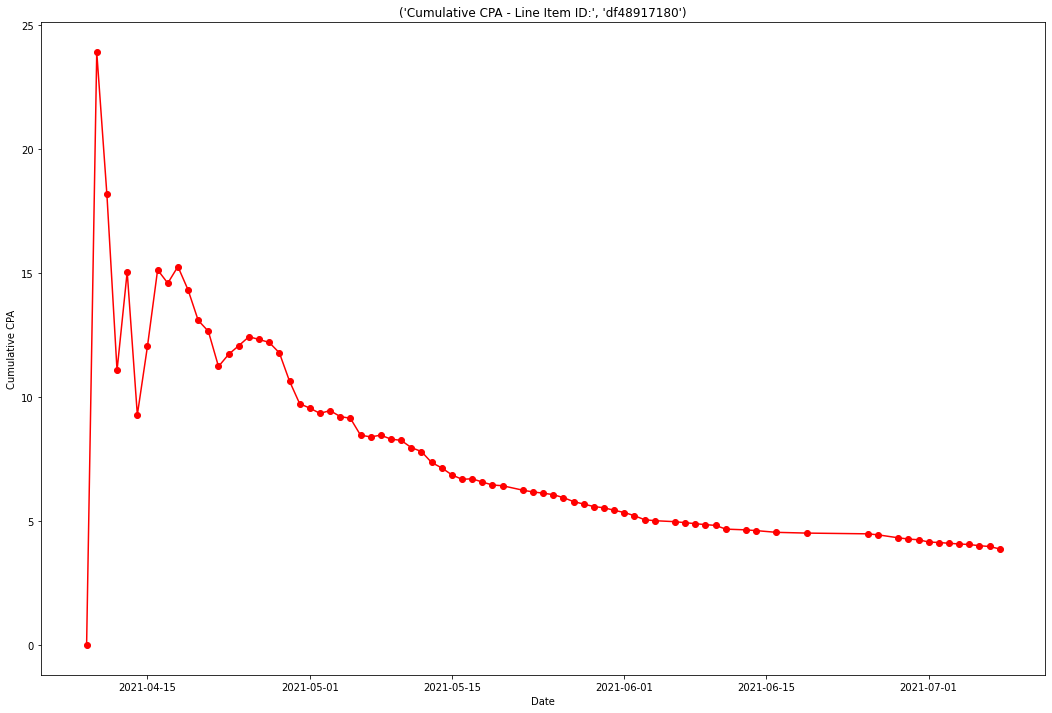

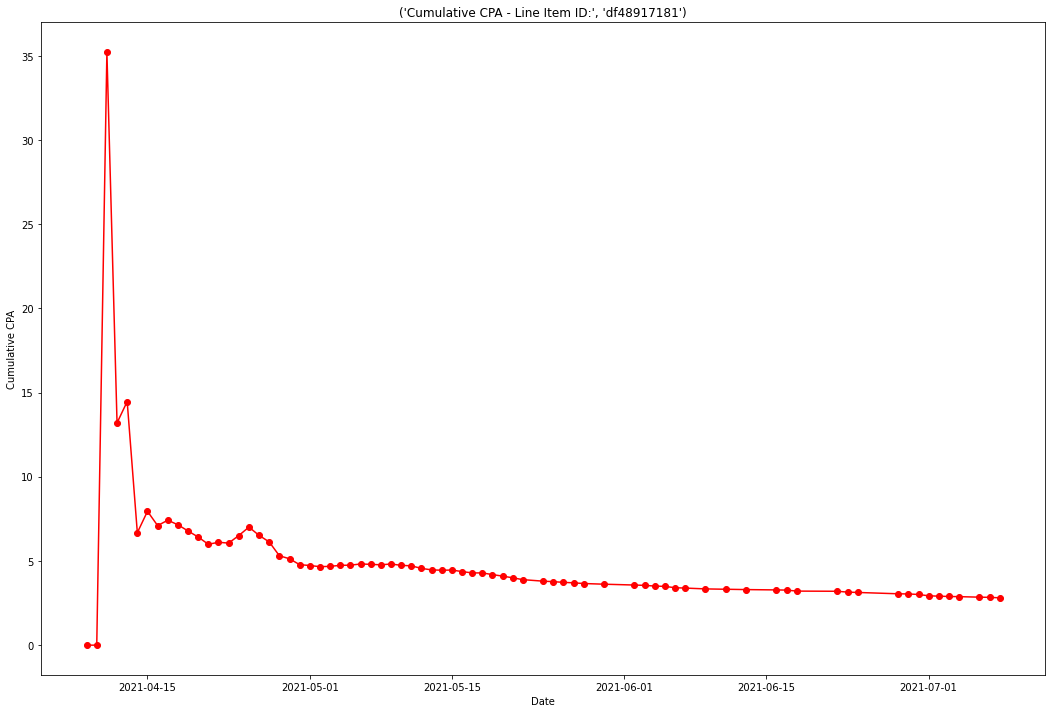

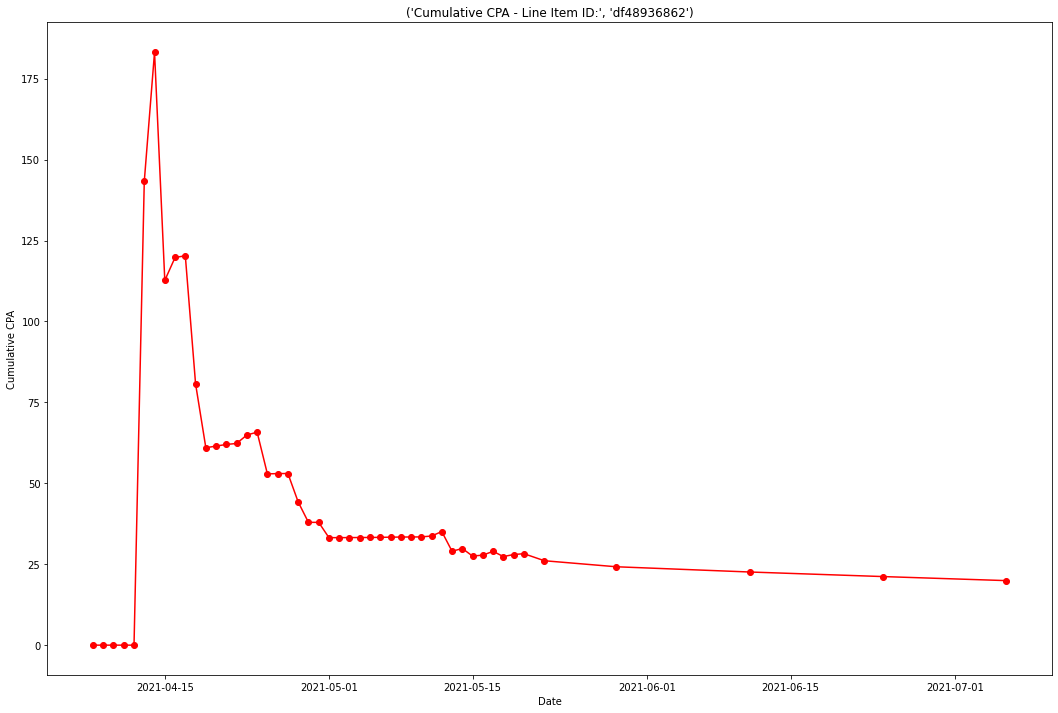

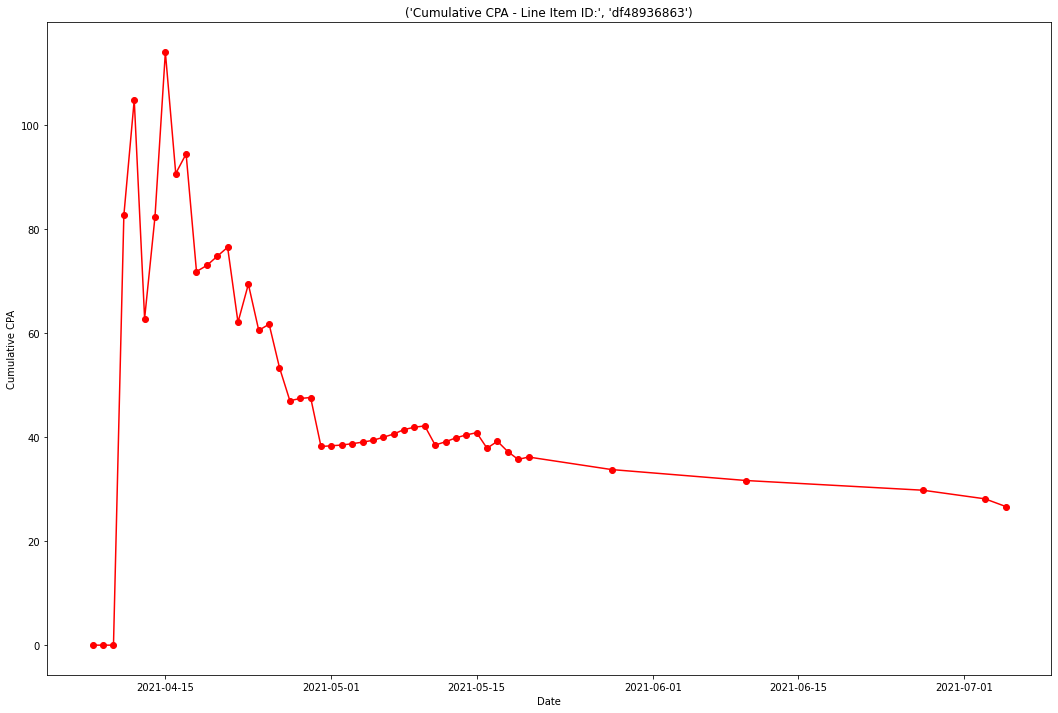

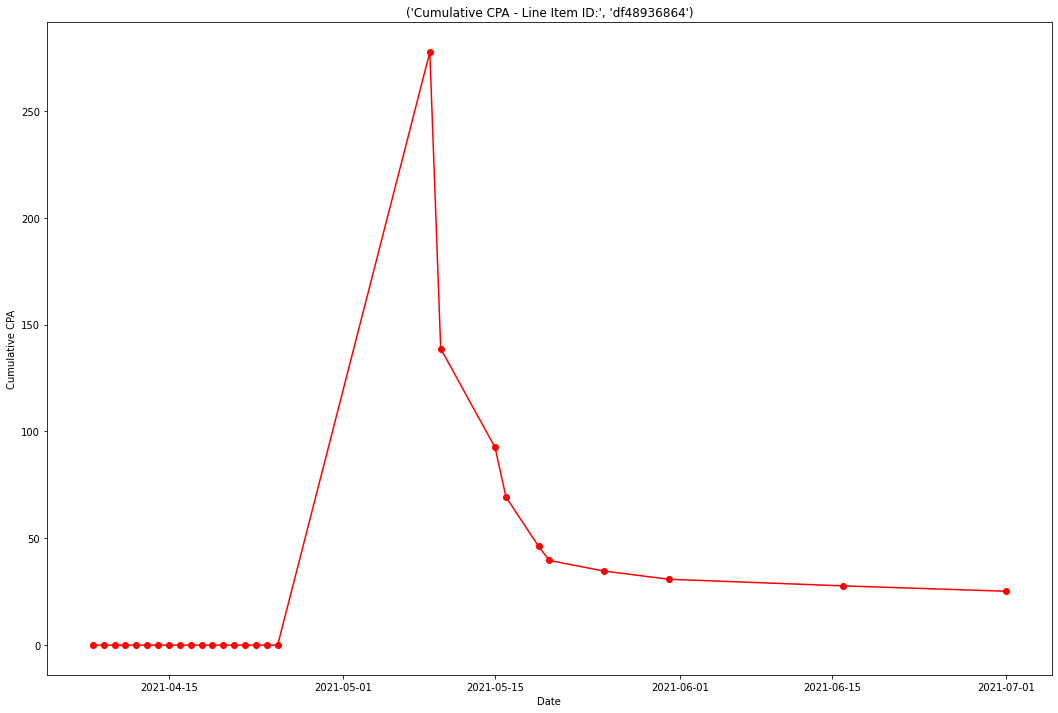

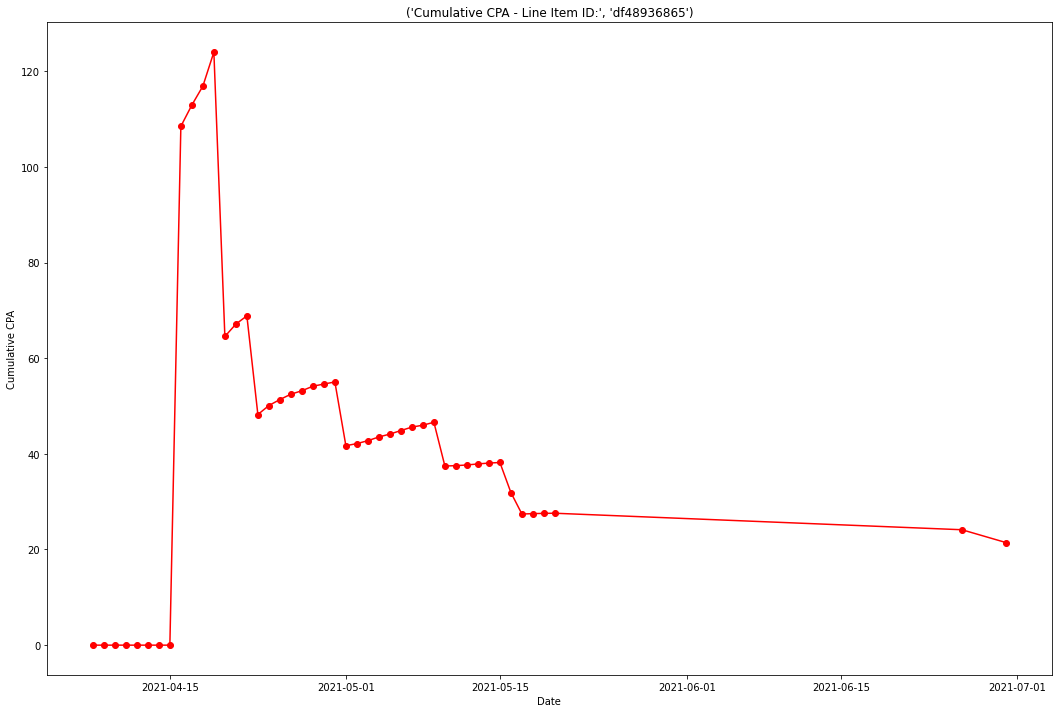

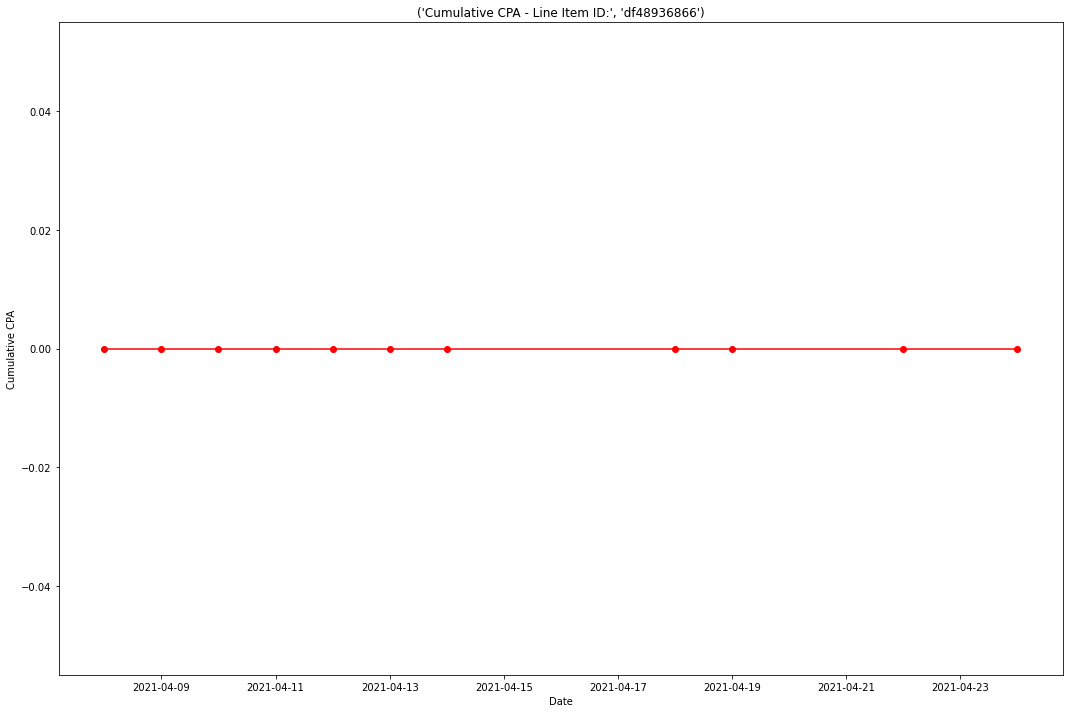

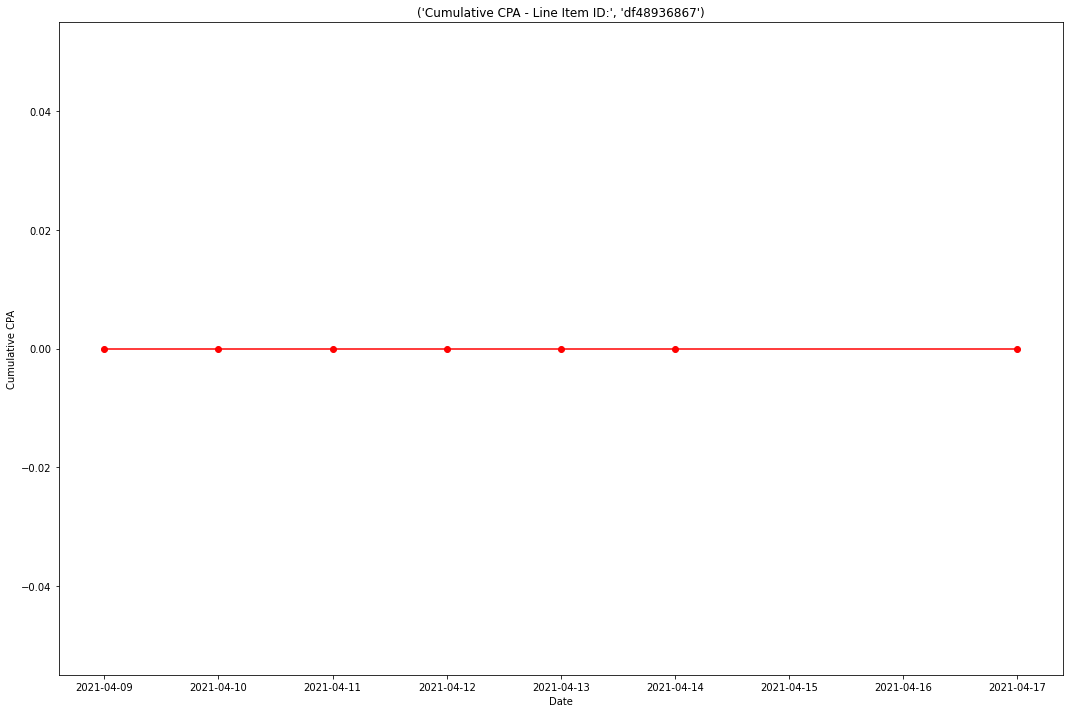

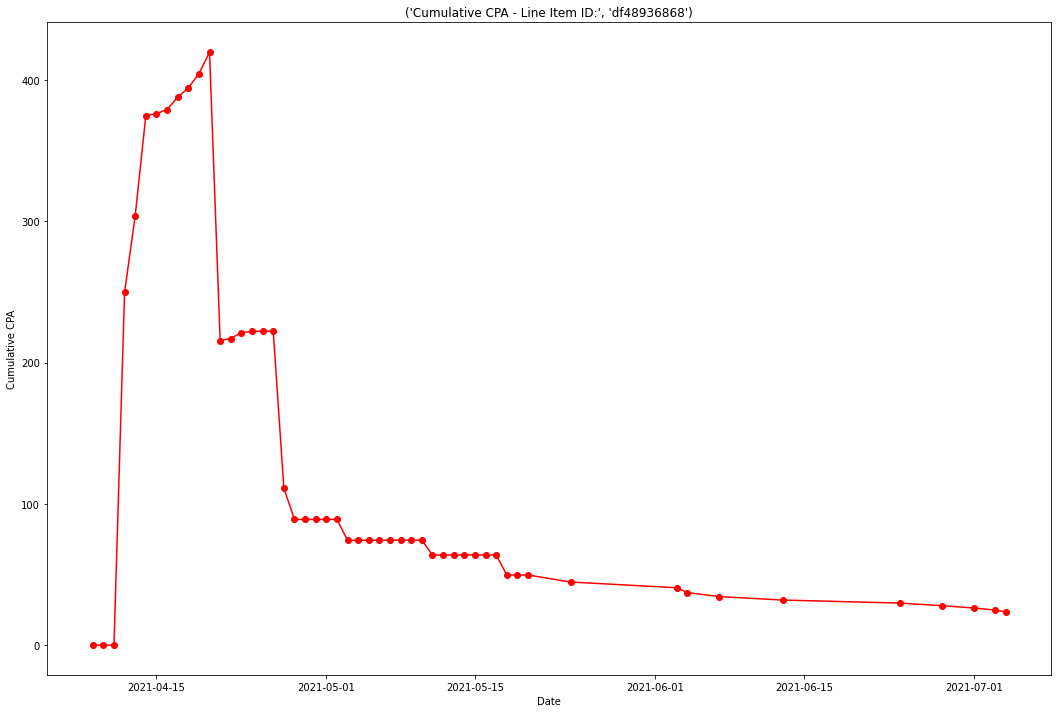

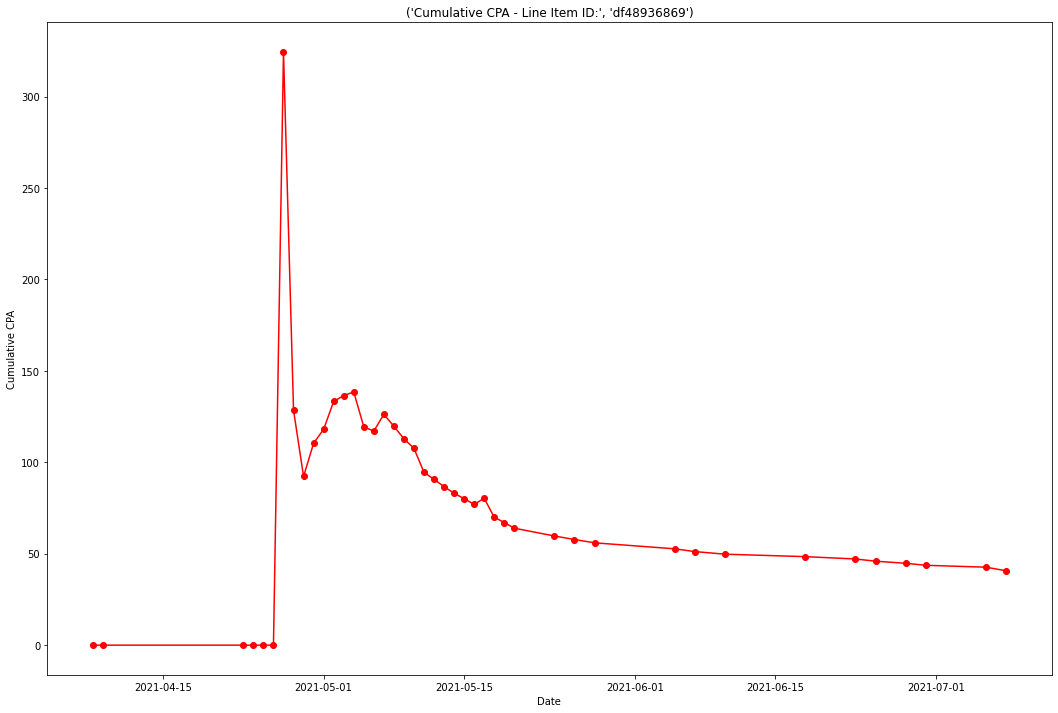

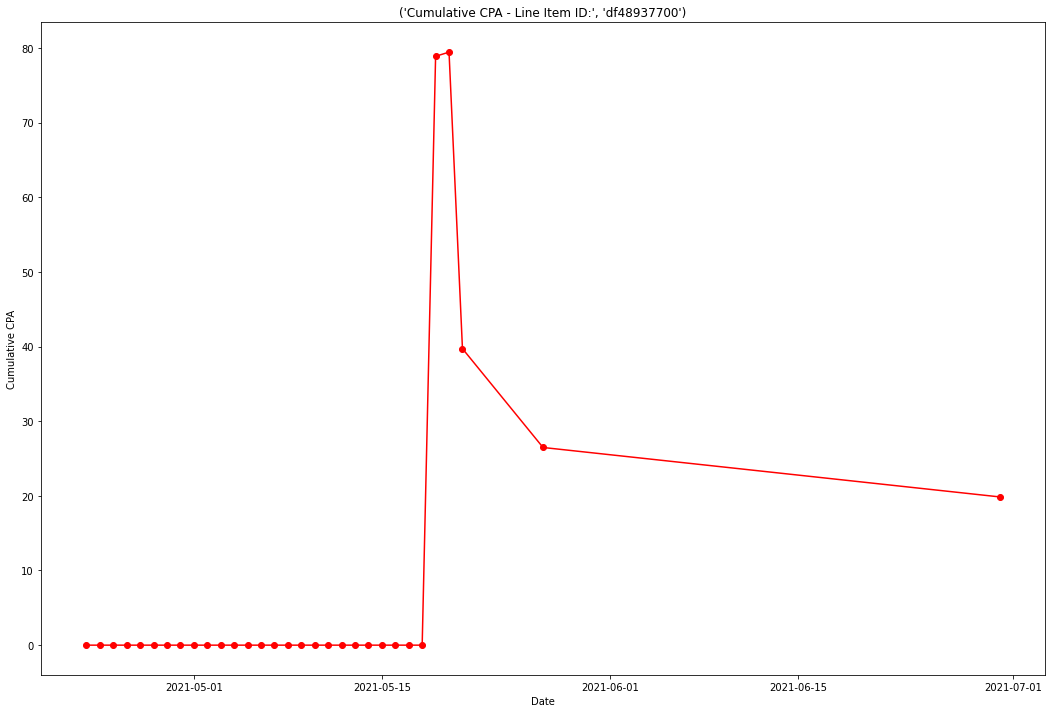

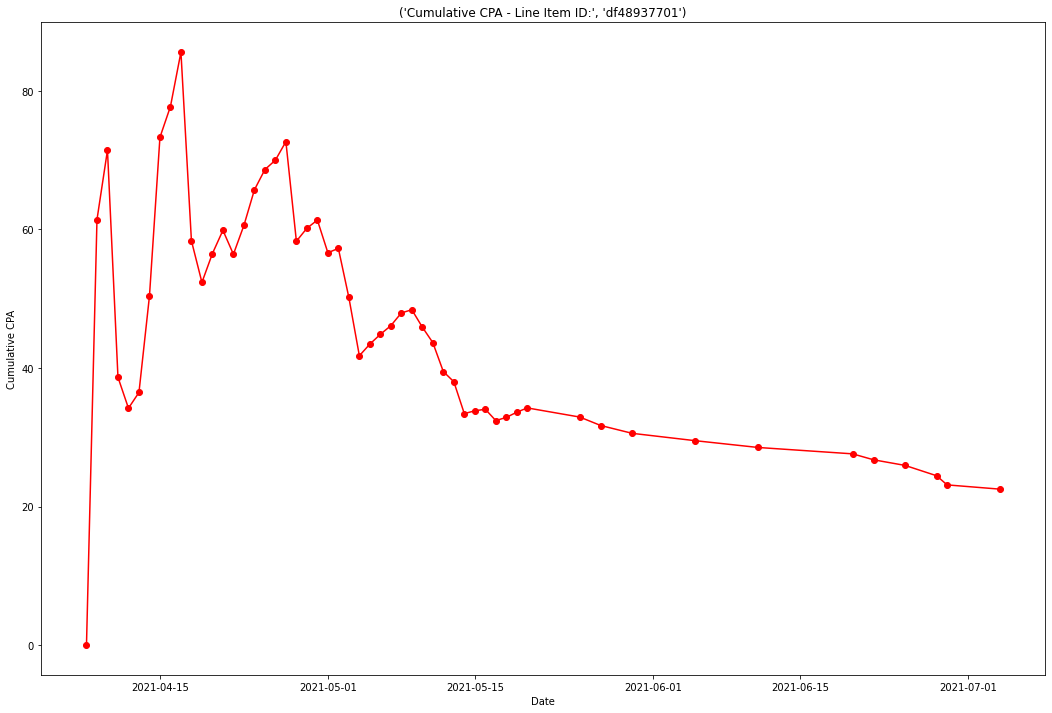

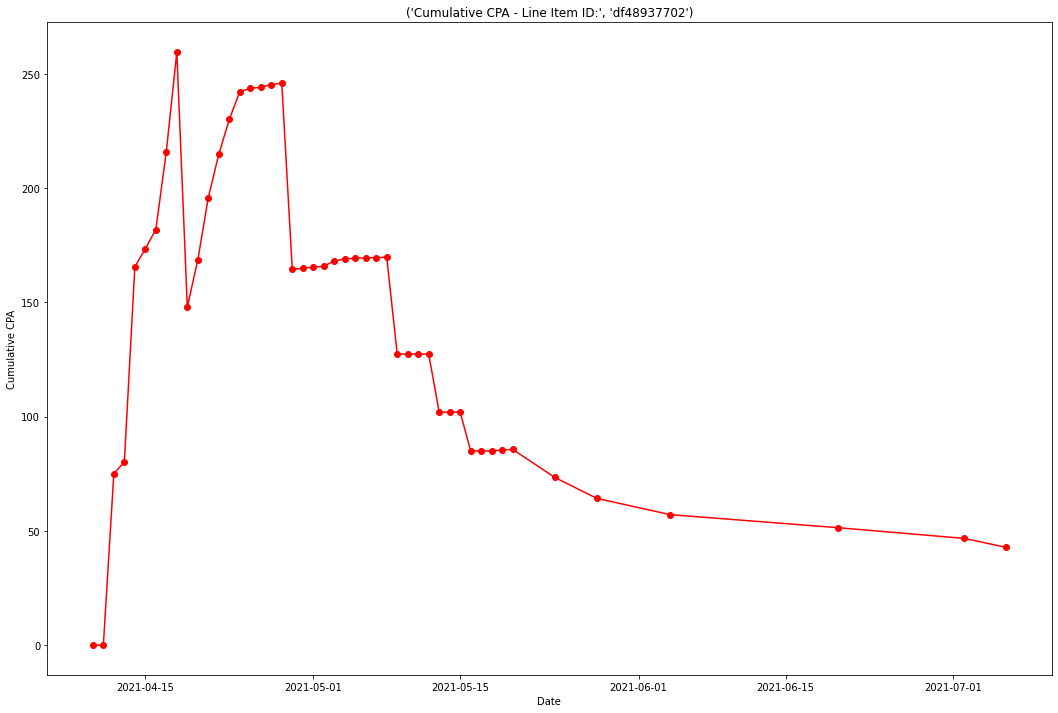

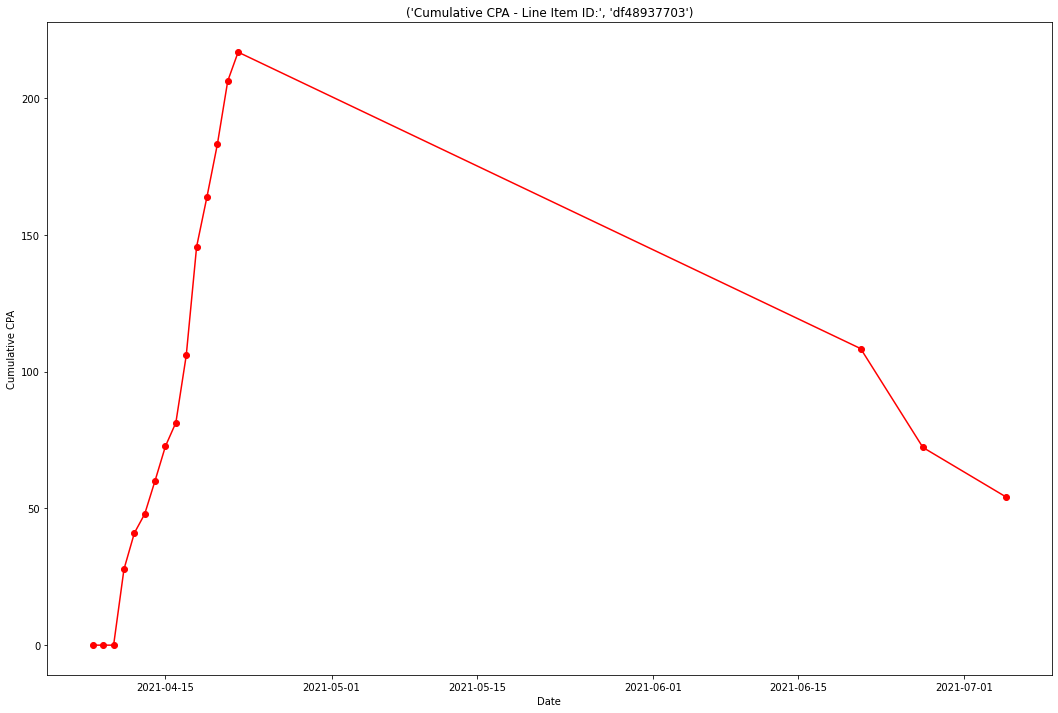

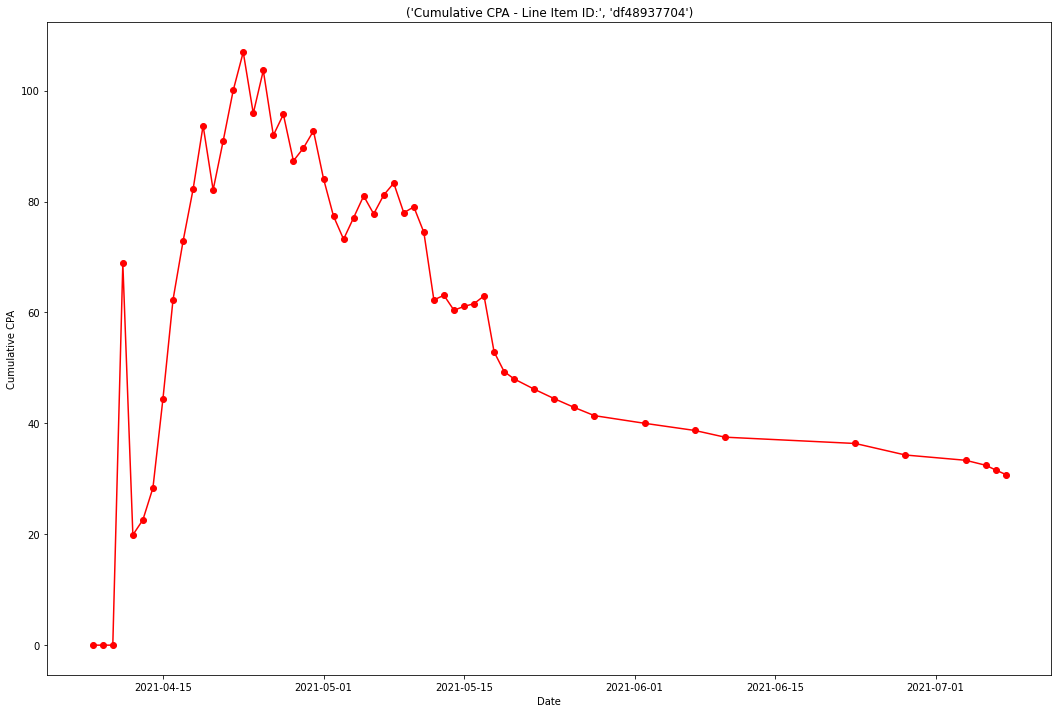

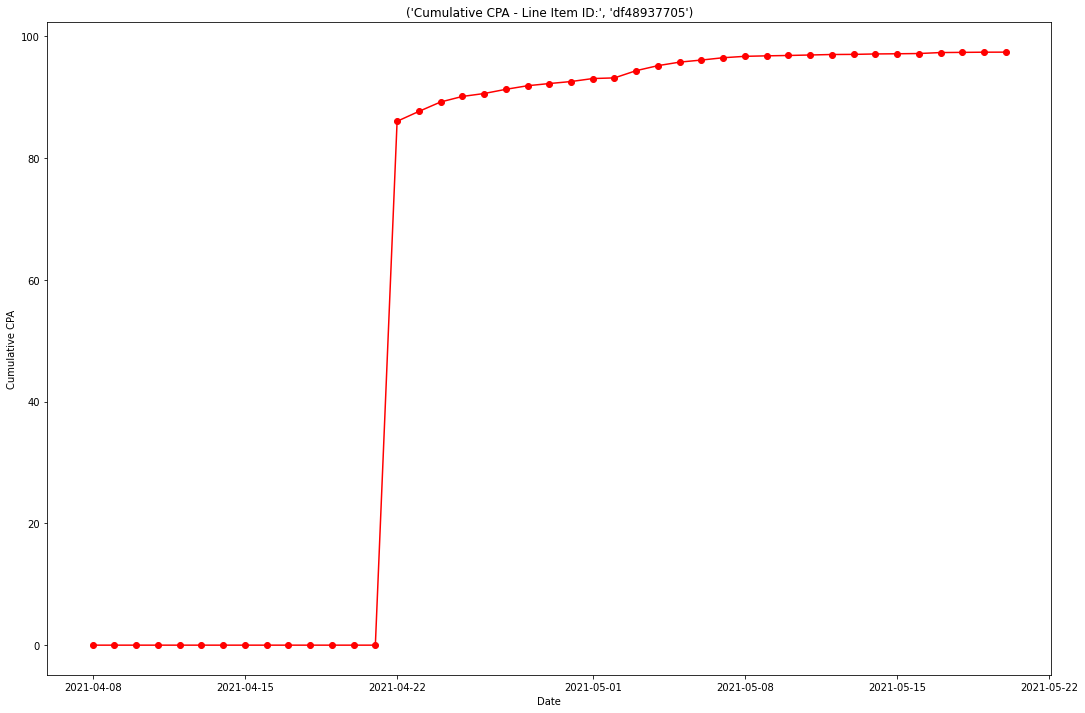

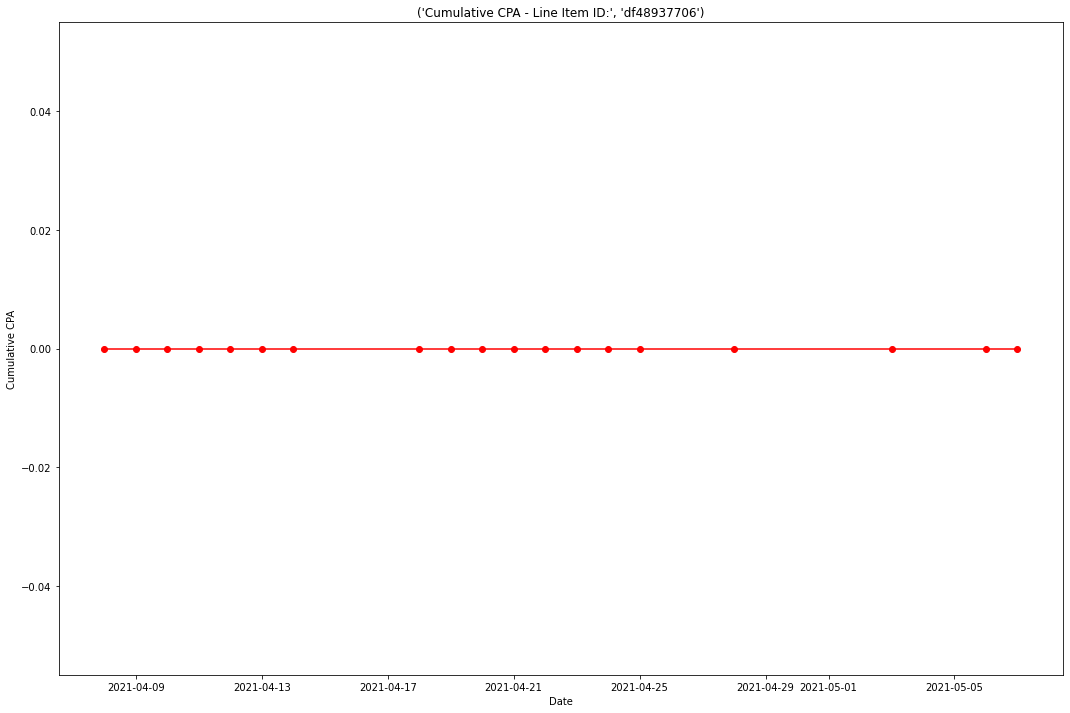

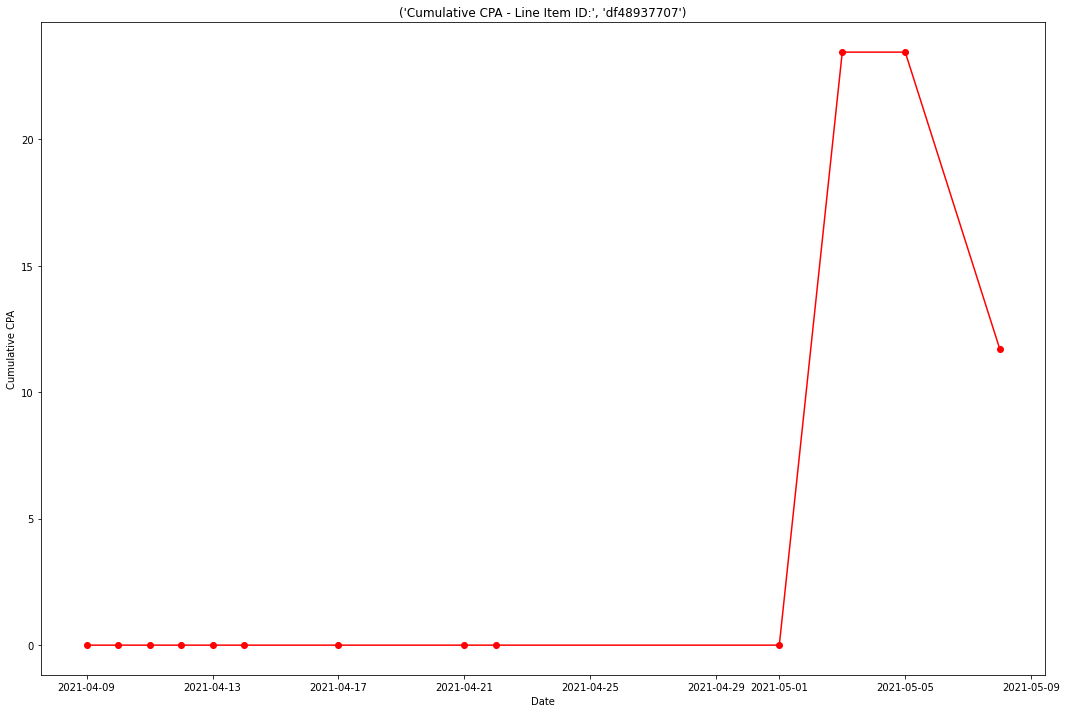

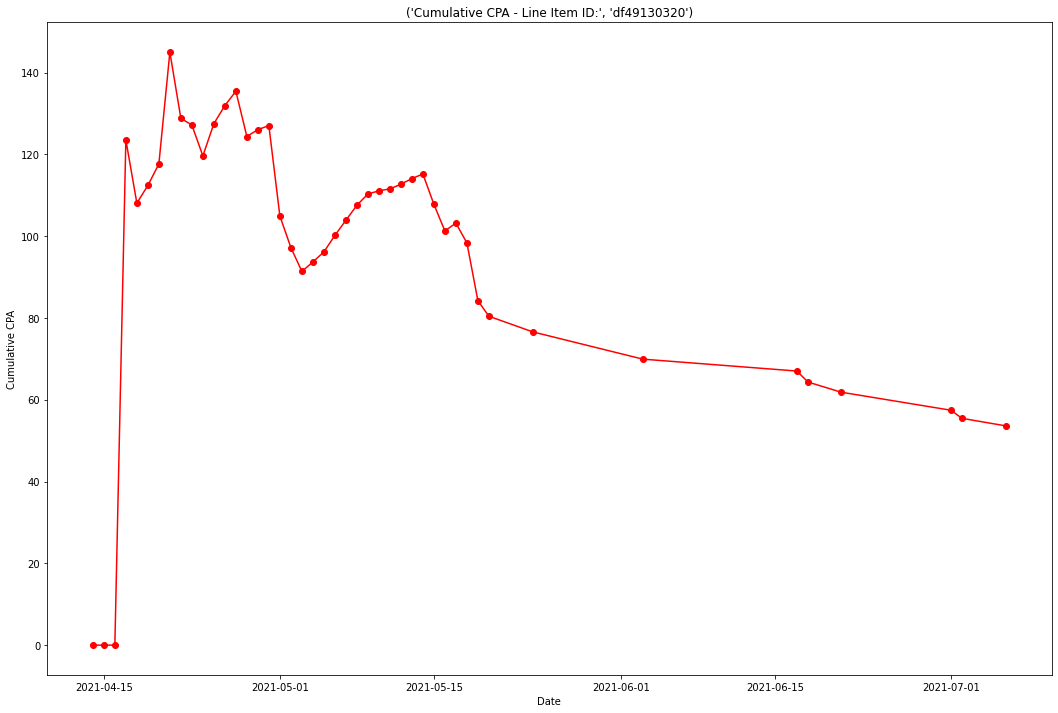

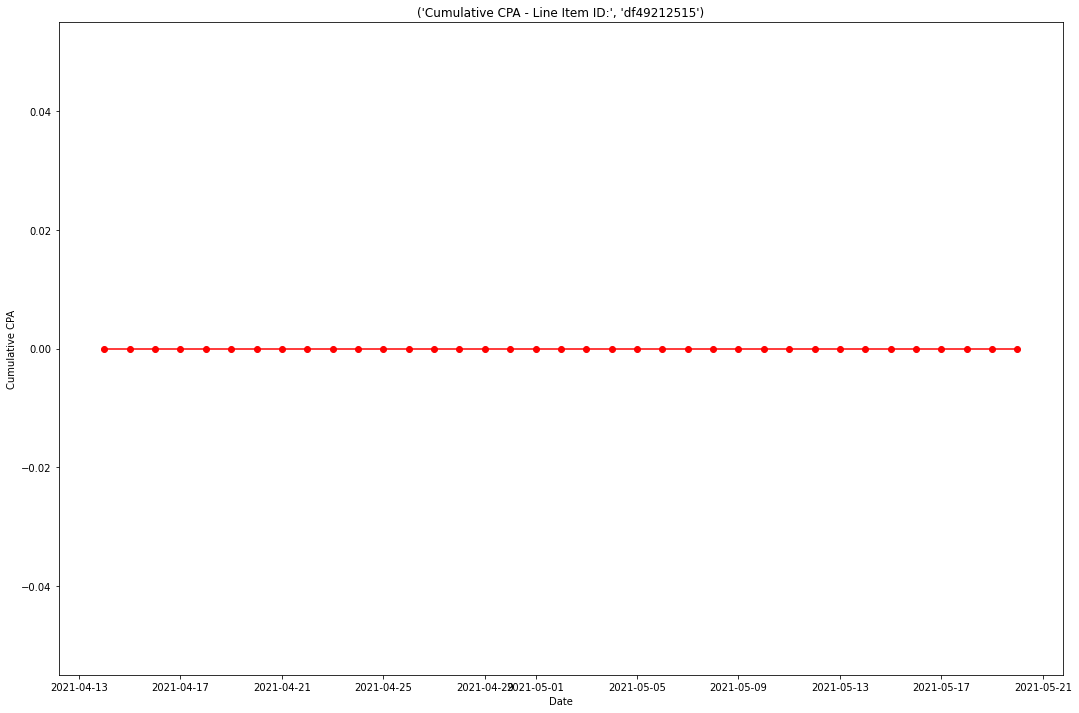

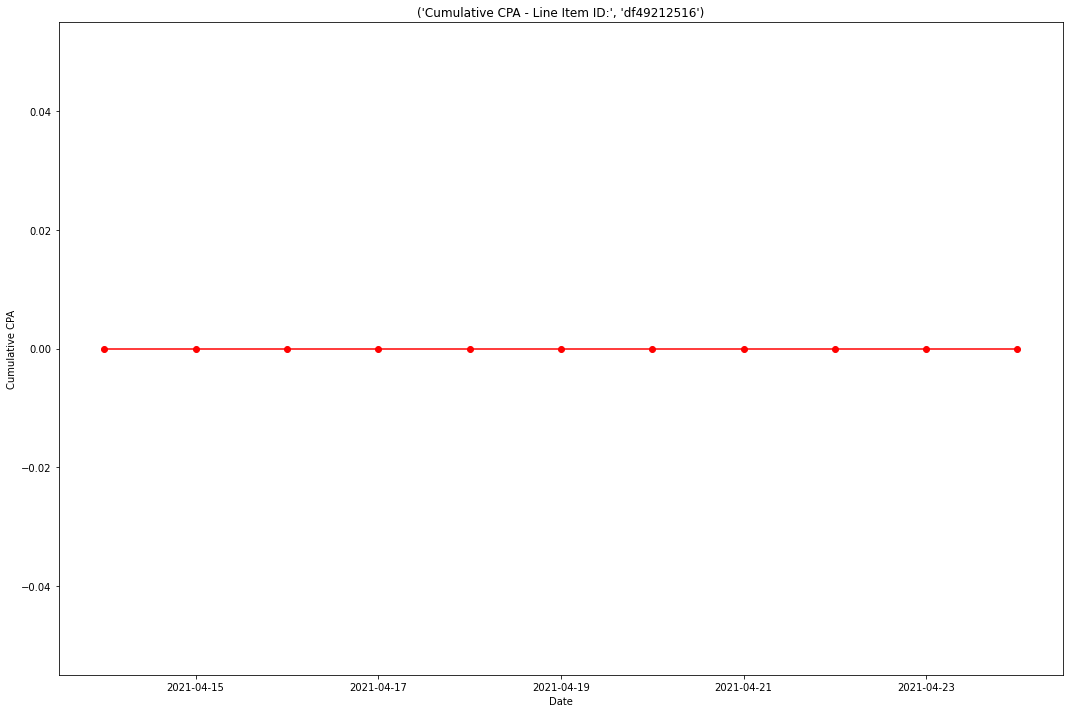

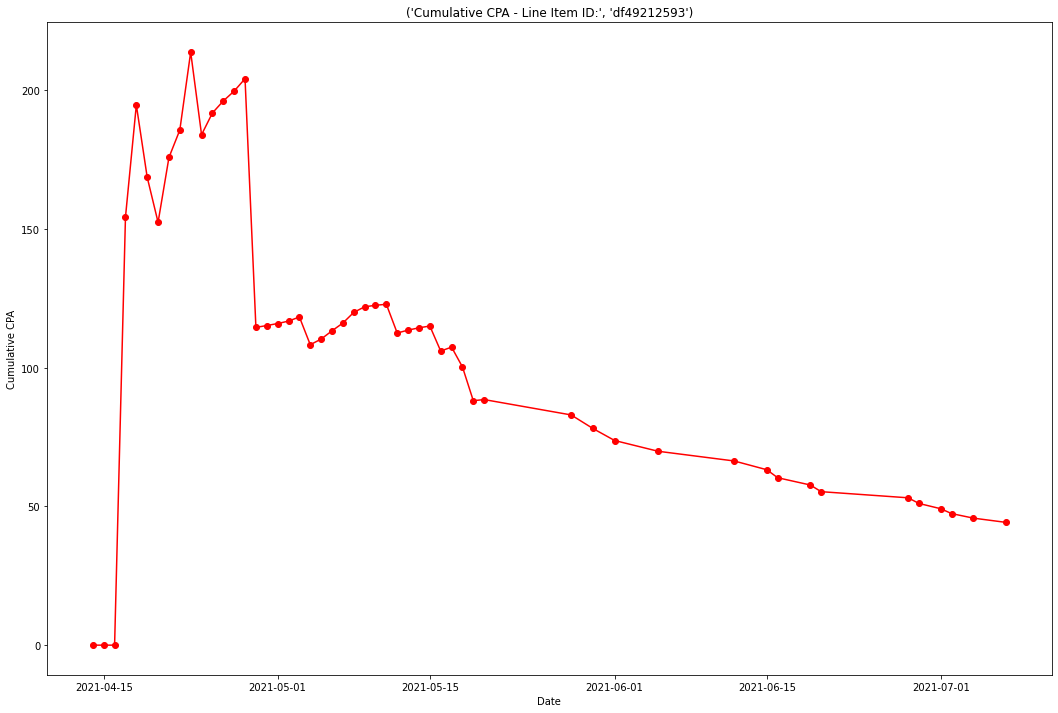

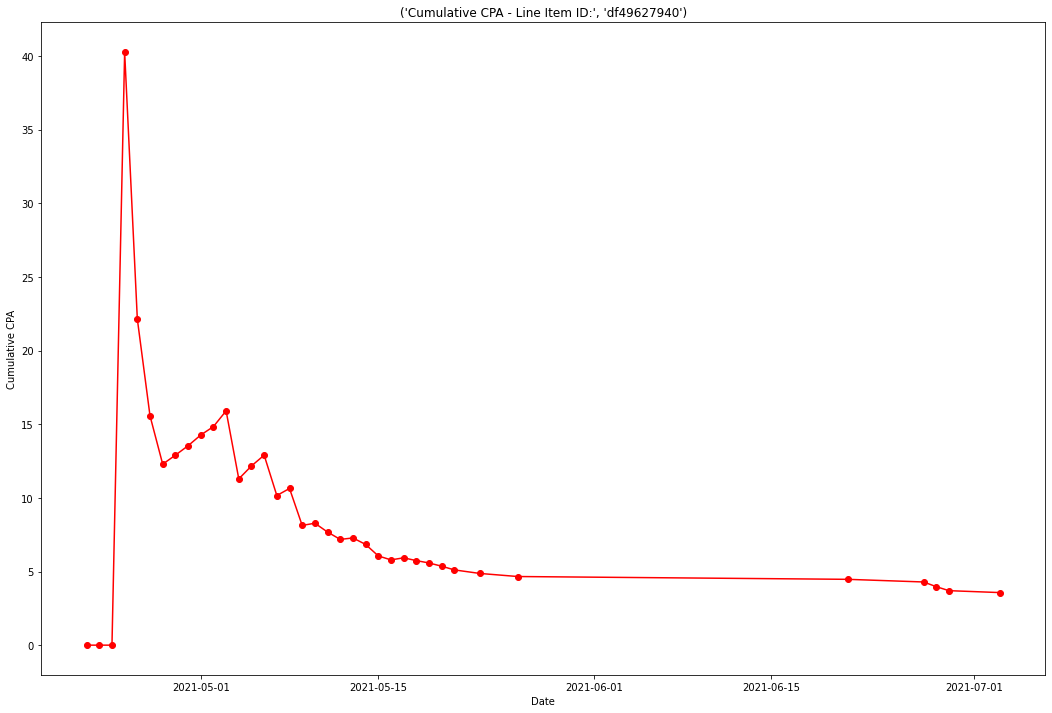

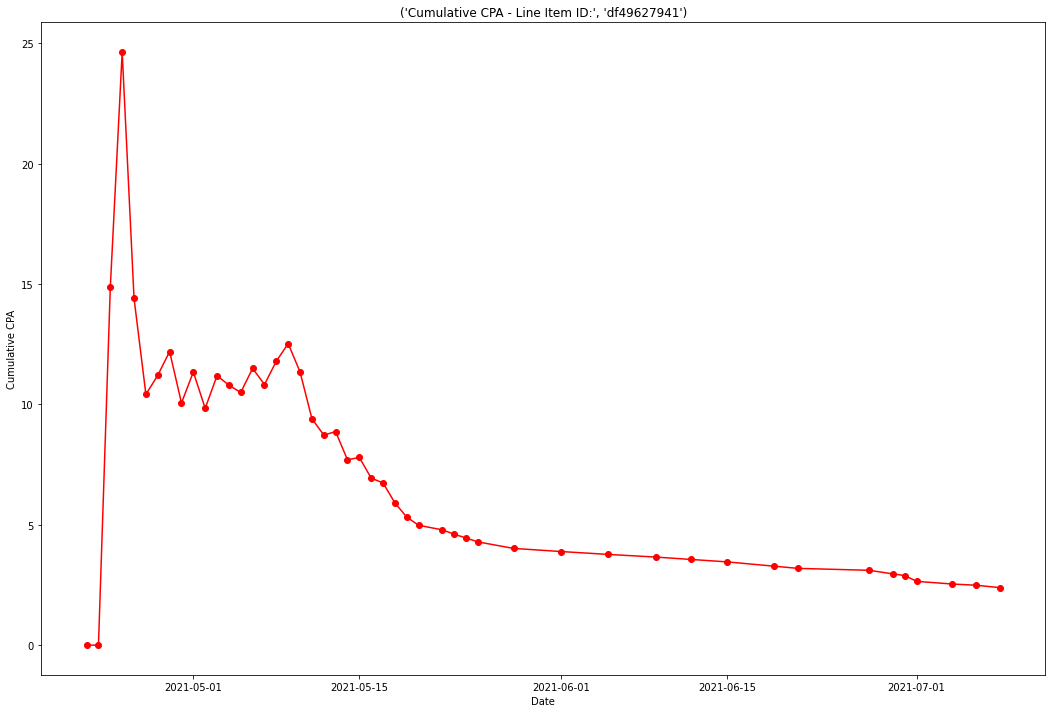

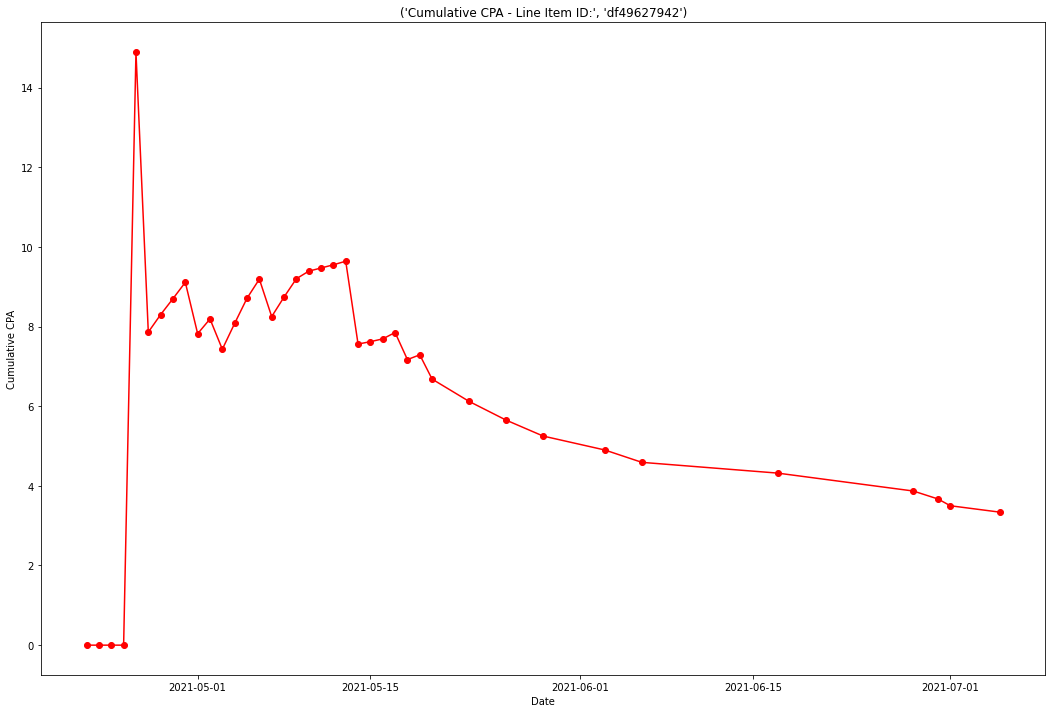

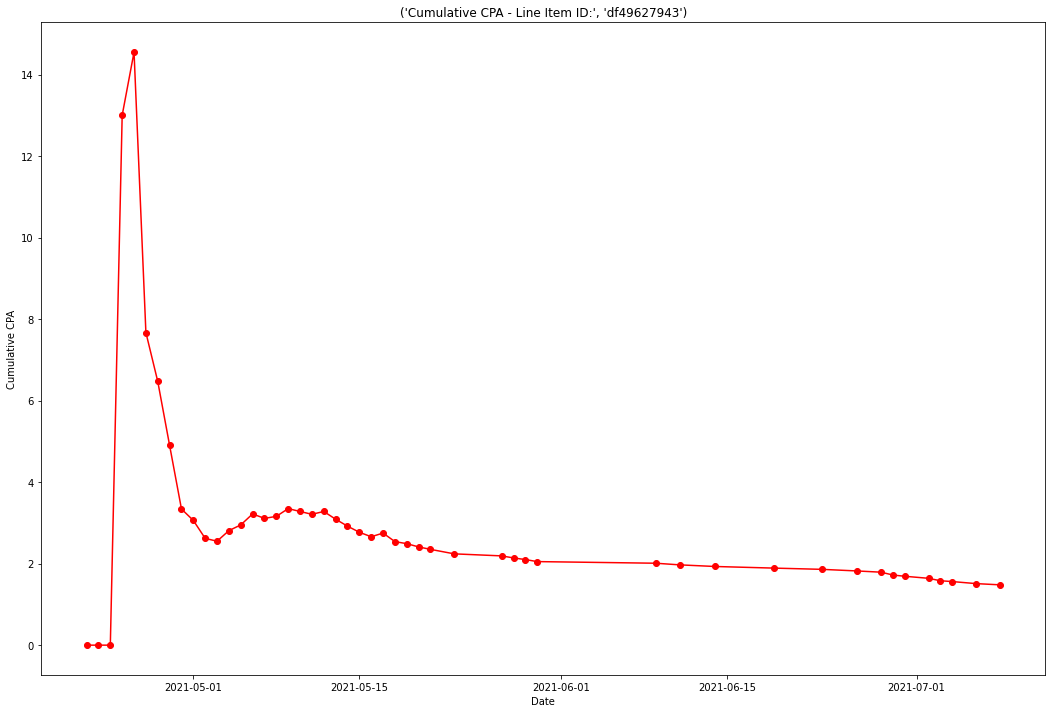

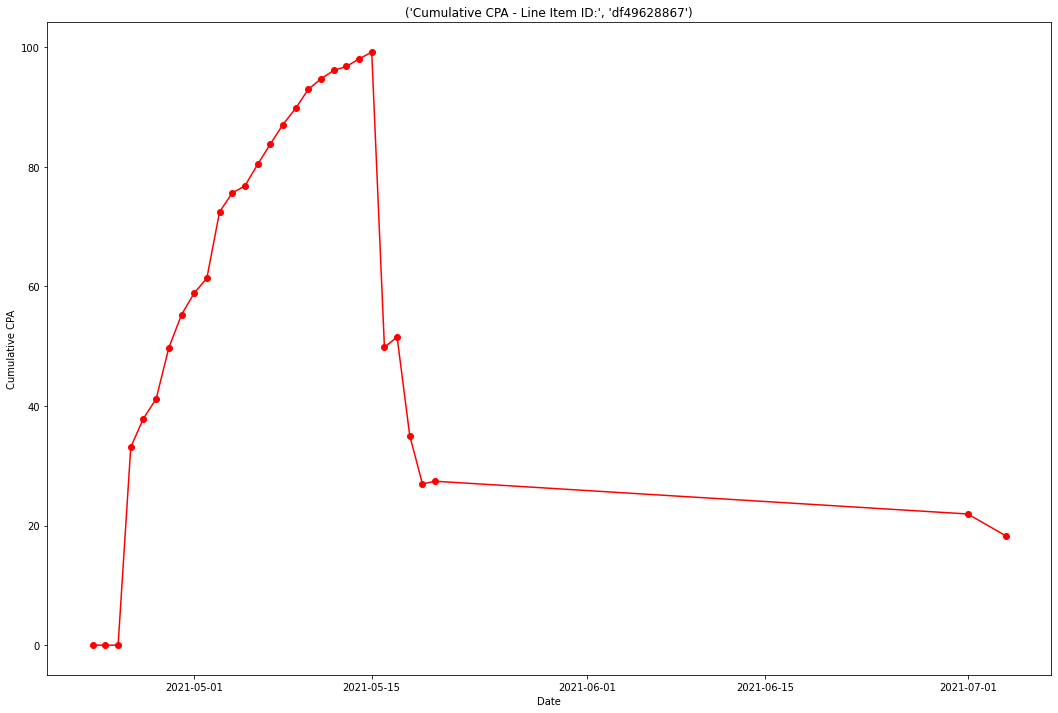

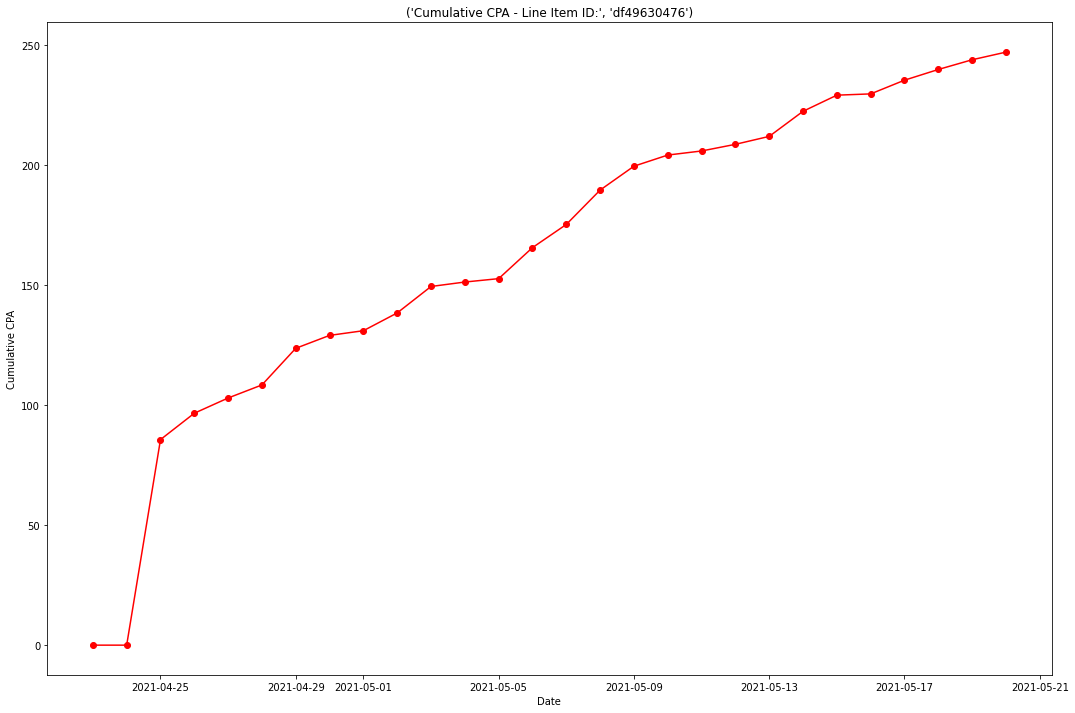

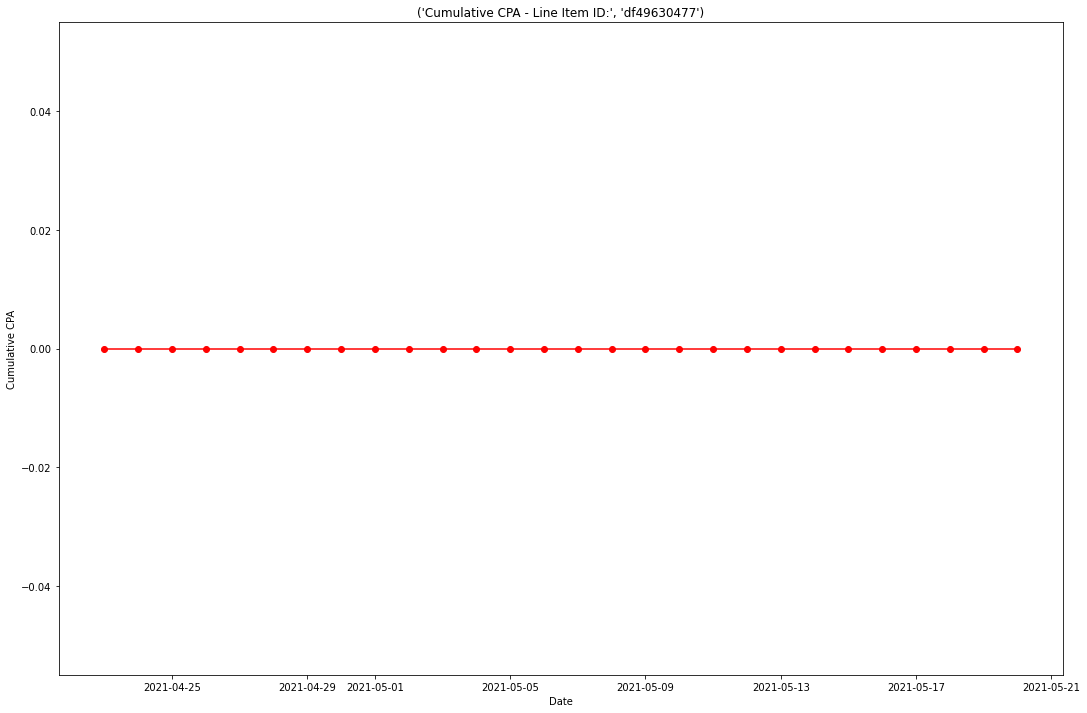

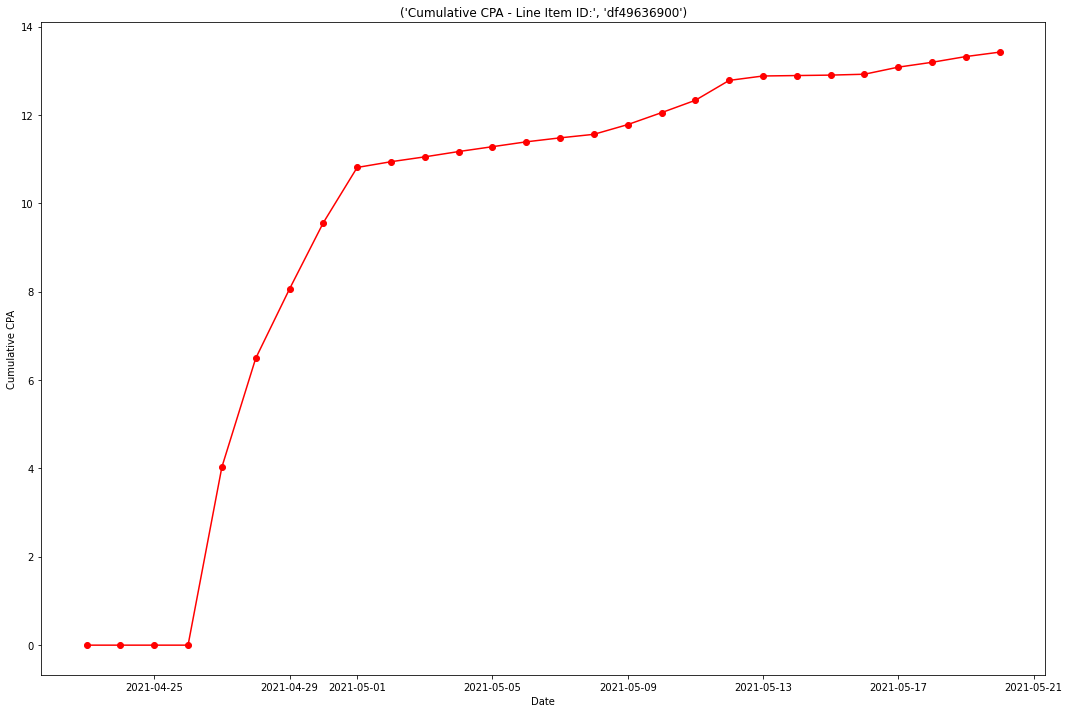

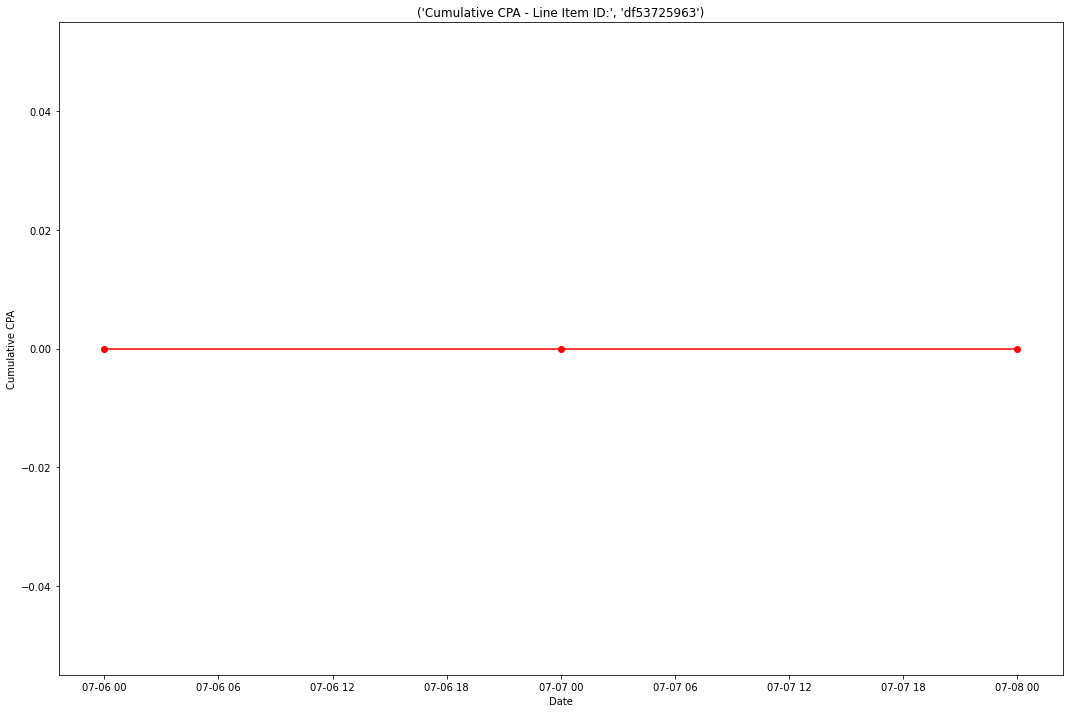

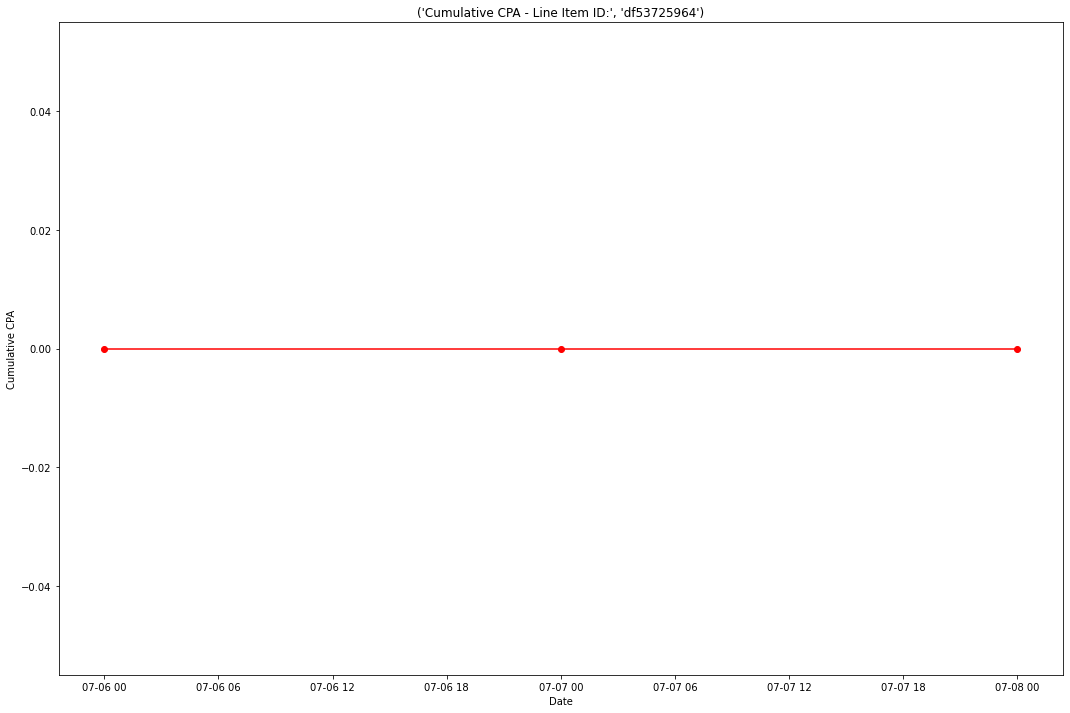

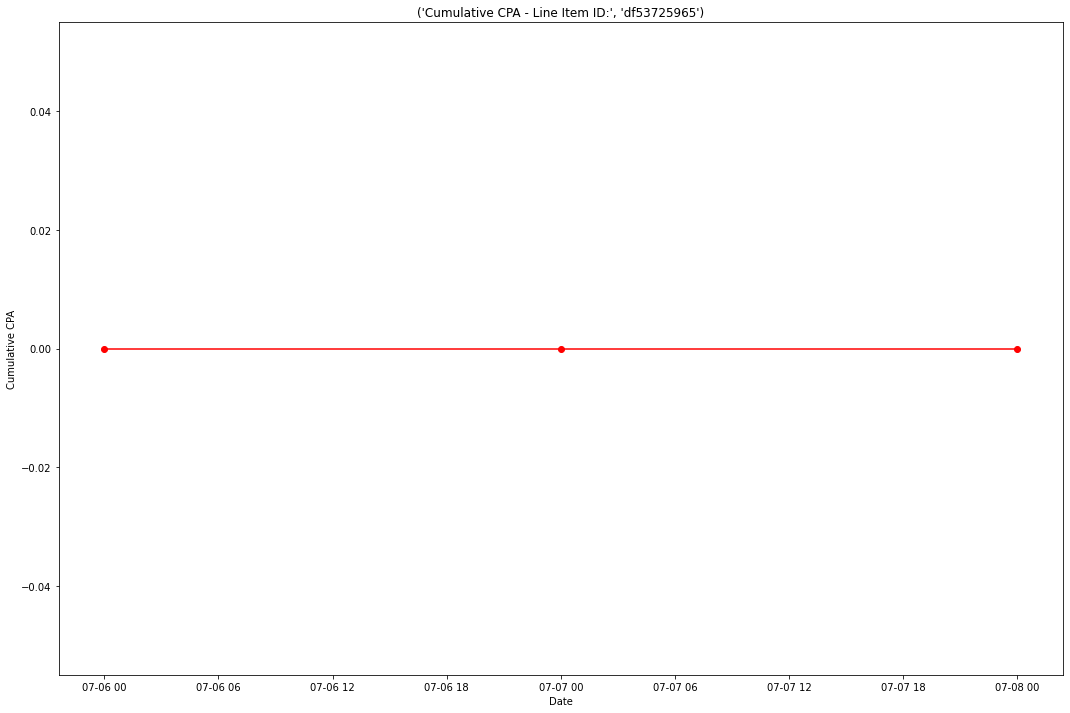

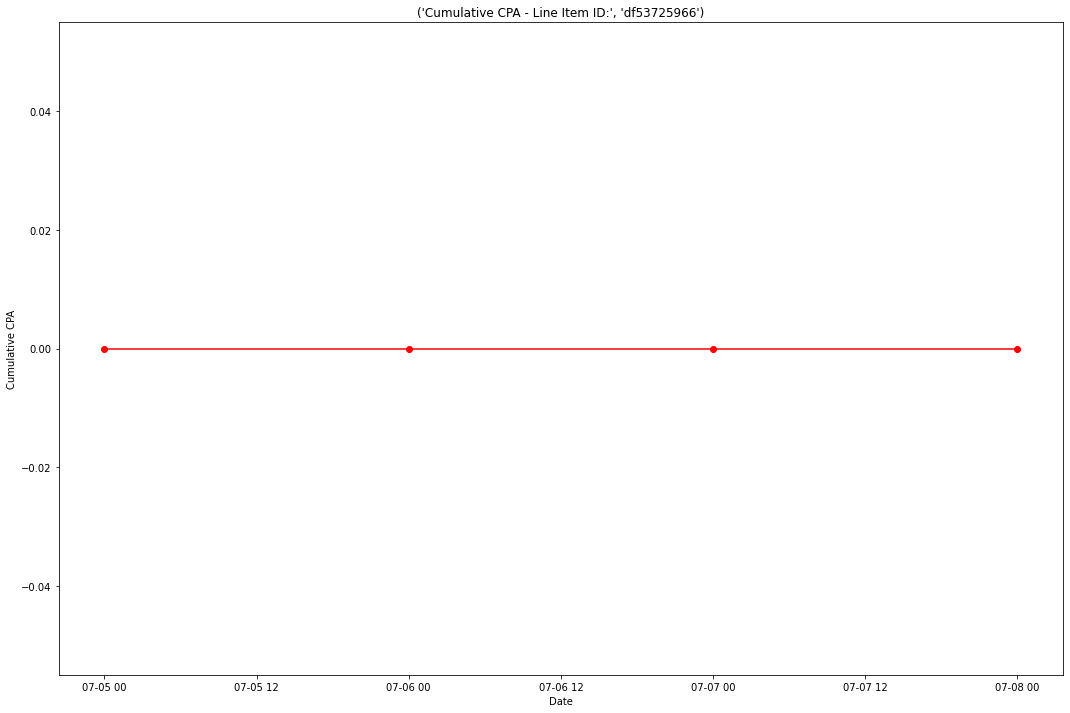

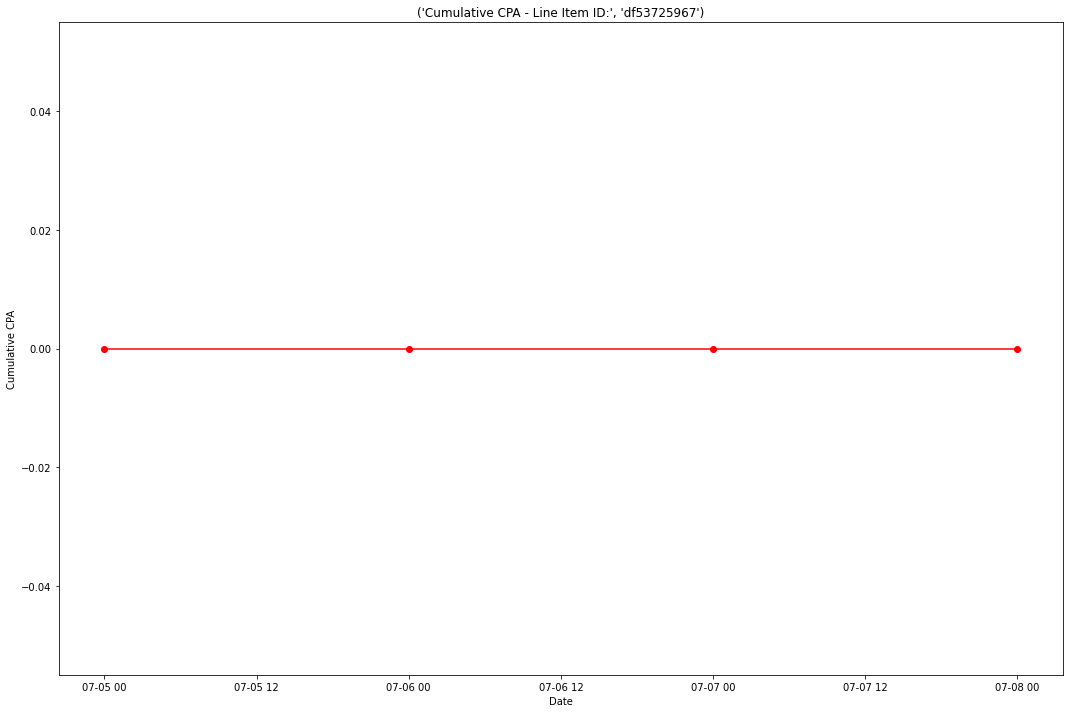

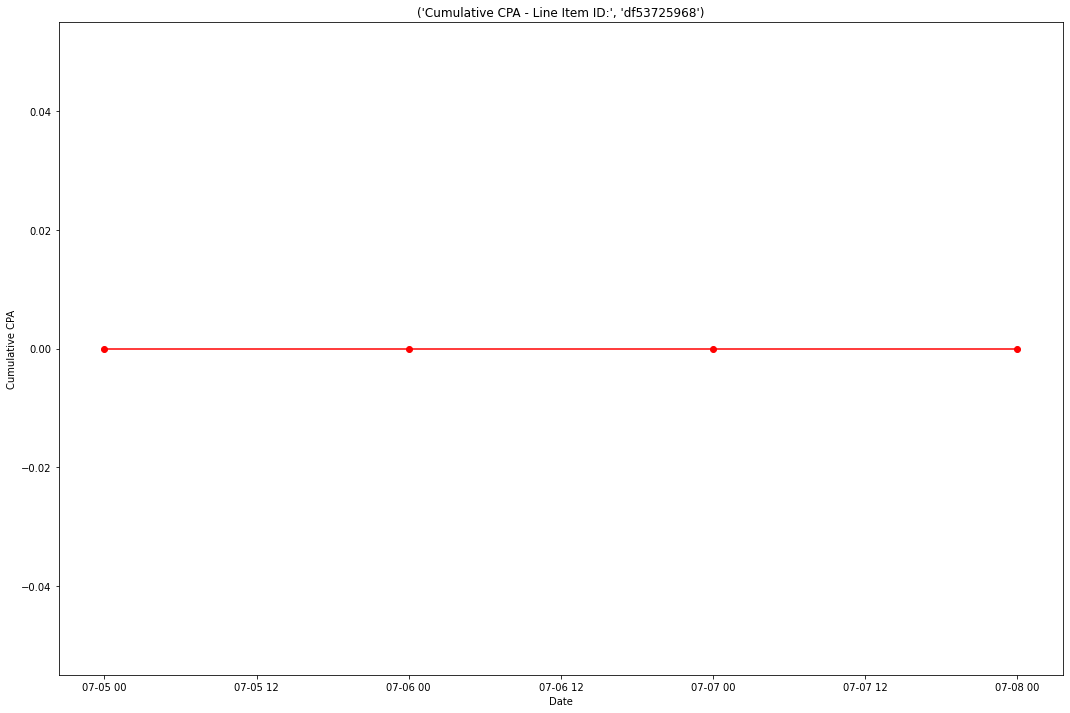

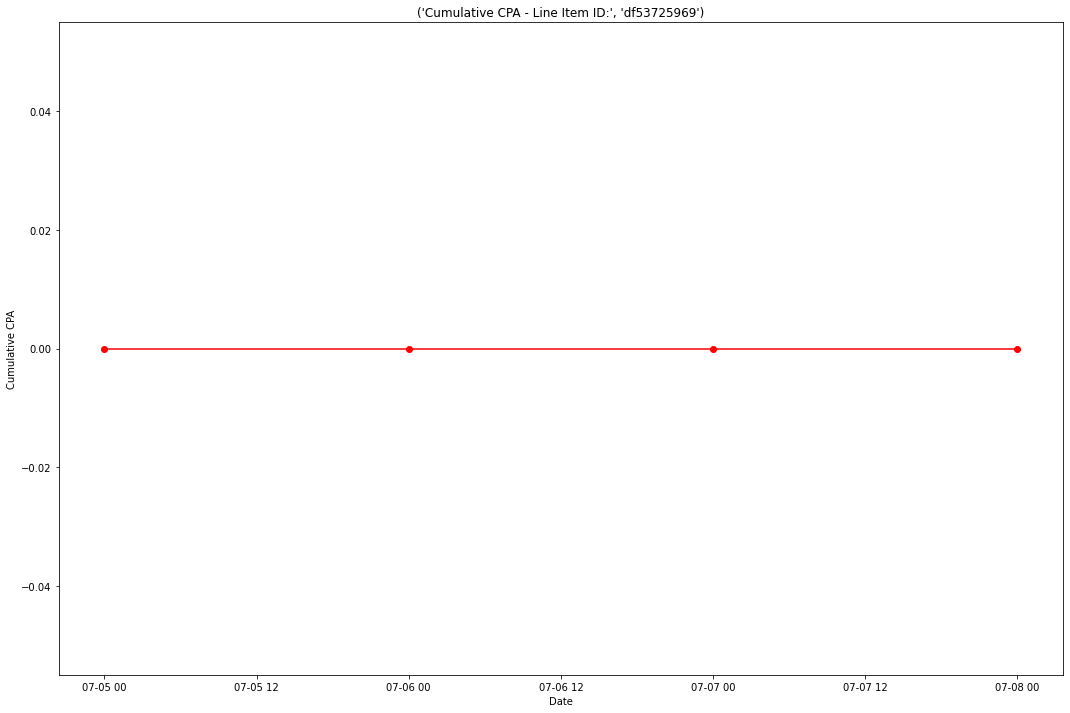

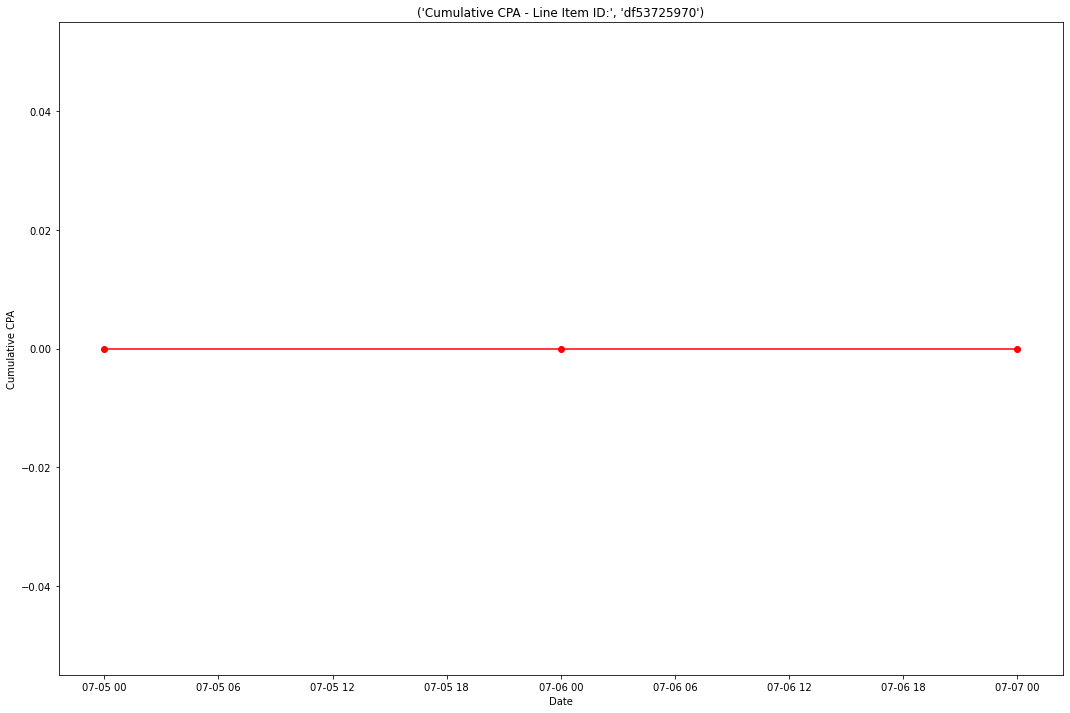

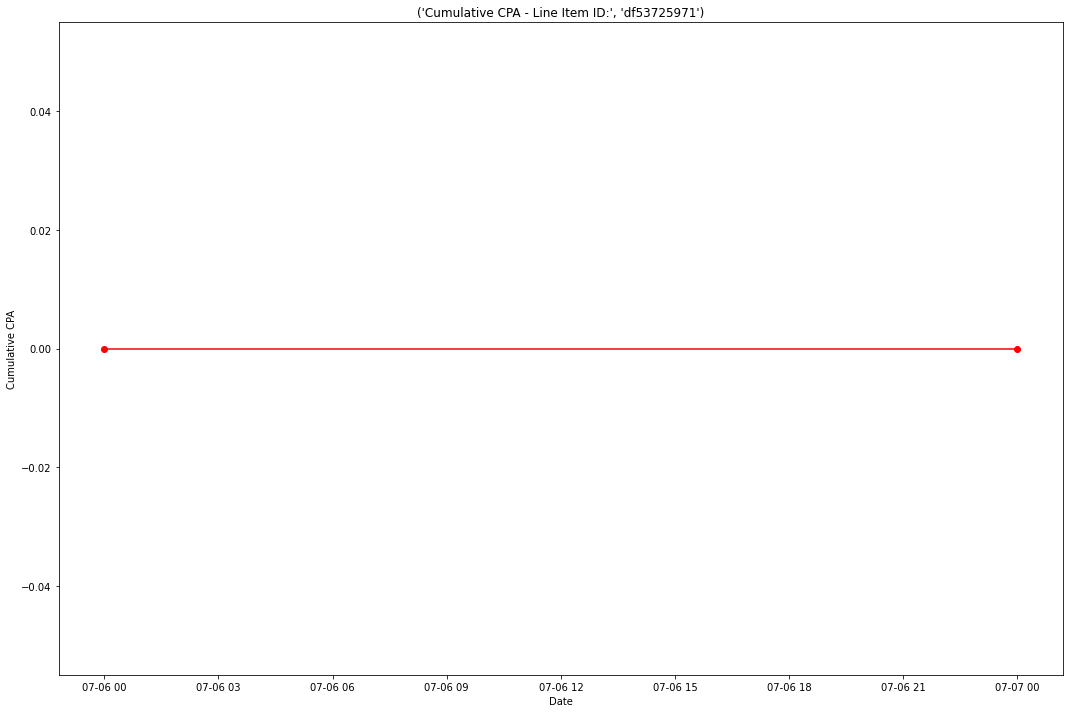

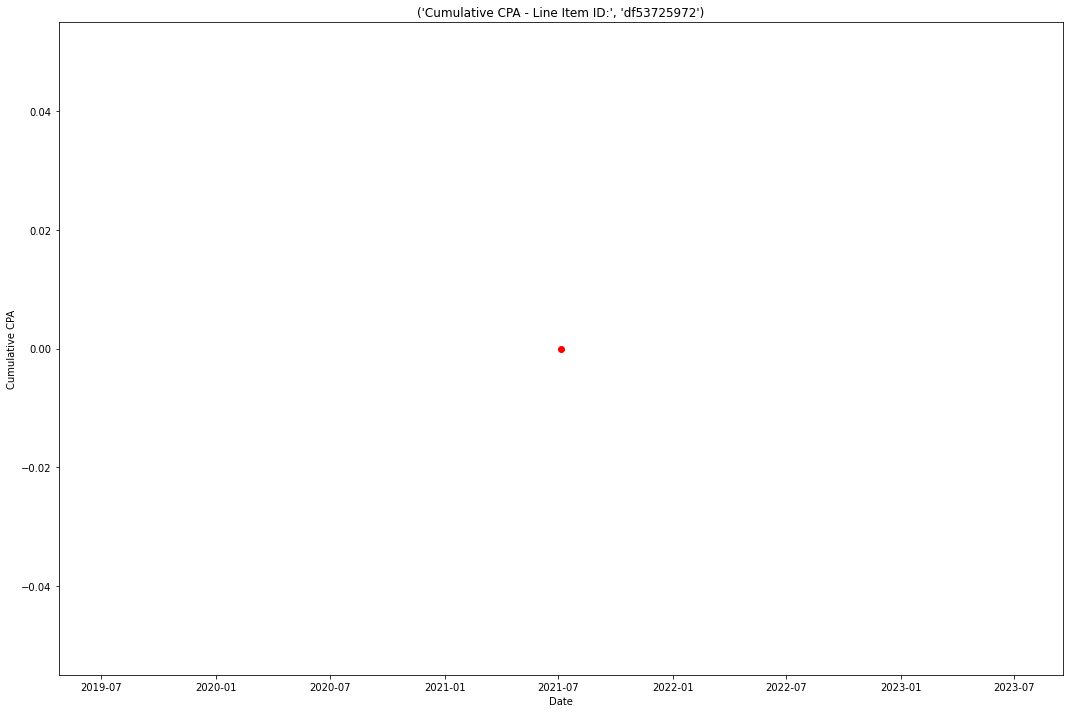

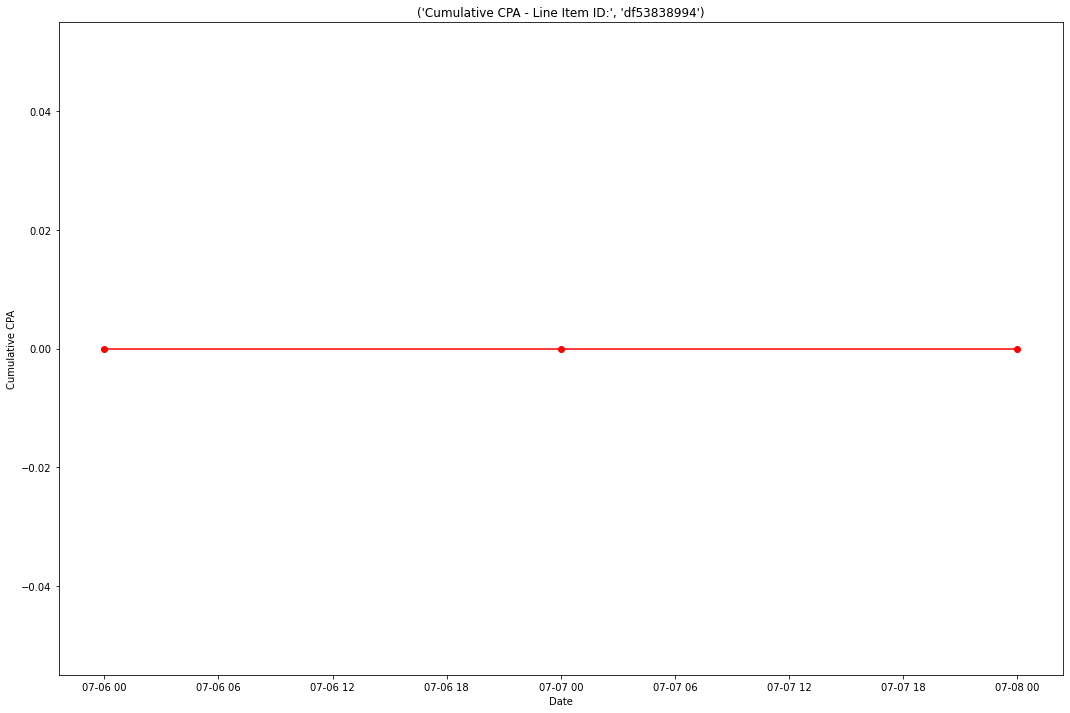

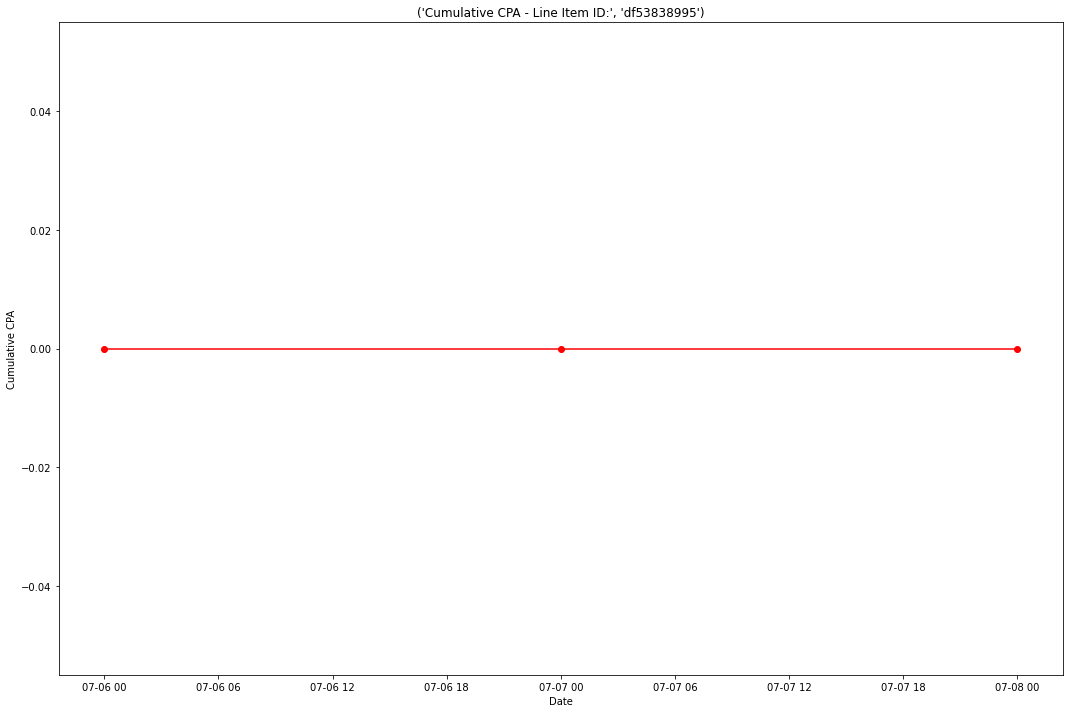

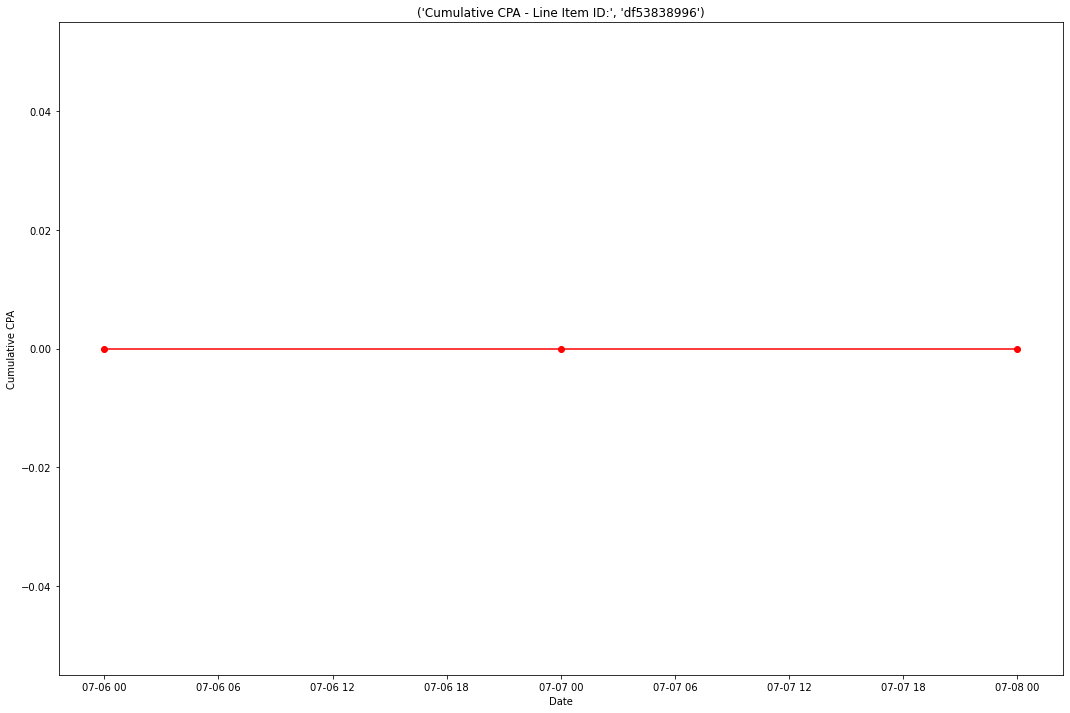

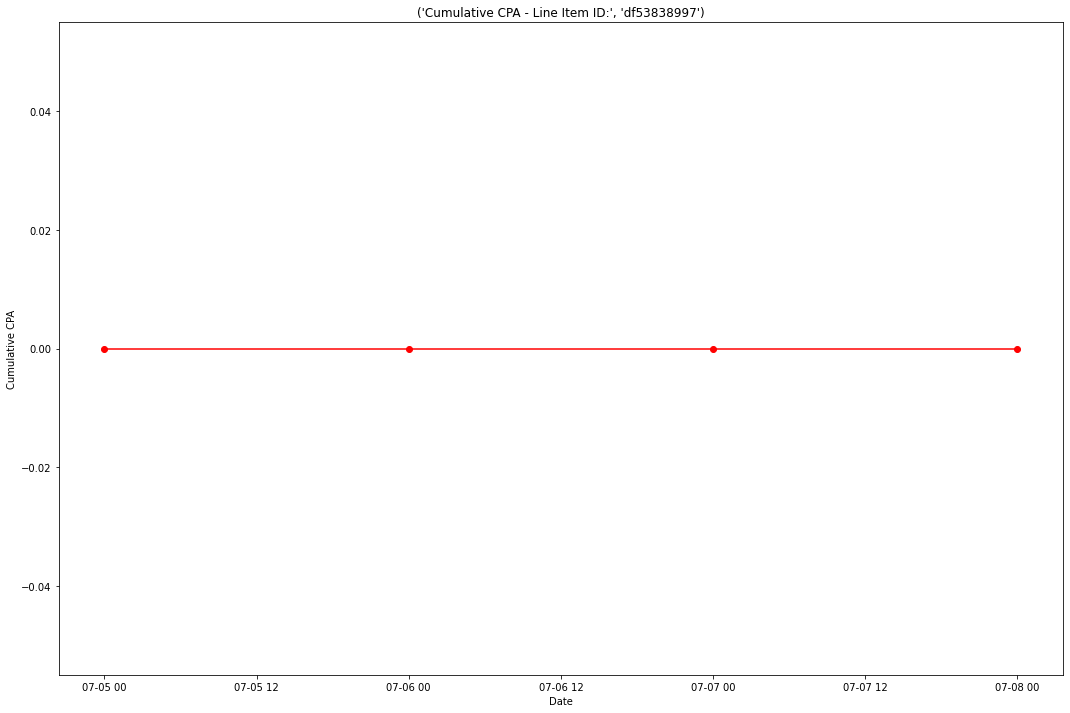

In [38]:
for key in data_dict_cpa.keys():
    cpa(key)

In [39]:
#concatenate the dataframes fro mthe dictionary
readly_performance_cpa = pd.concat(data_dict_cpa.values())

In [40]:
#inspect the dataframes
of_performance_cpa
readly_performance_cpa

,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Date,Cumulative CPA
0,6073667,19546747,49264599,2021-04-22,0.00
1,6073667,19546747,49264599,2021-04-23,0.00
2,6073667,19546747,49264599,2021-04-24,56.39
3,6073667,19546747,49264599,2021-04-25,25.46
4,6073667,19546747,49264599,2021-04-26,33.54
...,...,...,...,...,...
2,6073667,19546747,50307722,2021-05-07,0.00
3,6073667,19546747,50307722,2021-05-08,0.00
4,6073667,19546747,50307722,2021-05-09,3.26
5,6073667,19546747,50307722,2021-05-10,3.62


,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Date,Cumulative CPA
0,5966728,19236555,48885946,2021-04-10,0.00
1,5966728,19236555,48885946,2021-04-11,0.00
2,5966728,19236555,48885946,2021-04-12,0.00
3,5966728,19236555,48885946,2021-04-13,0.00
4,5966728,19236555,48885946,2021-04-14,85.92
...,...,...,...,...,...
2,5966728,21497185,53838996,2021-07-08,0.00
0,5966728,21497185,53838997,2021-07-05,0.00
1,5966728,21497185,53838997,2021-07-06,0.00
2,5966728,21497185,53838997,2021-07-07,0.00


In [41]:
#from the above plots we can see that some Line Items CPA is zero from the start till the end of the Line Item therefore there
#is no reason to keep them in our dataset so we will drop them
#of data
to_drop = of_performance_cpa.groupby(['Line_Item_ID'], as_index=False).max()

line_items_of = []
for index, row in to_drop.iterrows():
    if row['Cumulative CPA'] != 0:
        line_items_of.append(row['Line_Item_ID'])
        
of_performance_cpa = of_performance_cpa[of_performance_cpa['Line_Item_ID'].isin(line_items_of)] 

#readly data
to_drop = readly_performance_cpa.groupby(['Line_Item_ID'], as_index=False).max()

line_items_readly = []
for index, row in to_drop.iterrows():
    if row['Cumulative CPA'] != 0:
        line_items_readly.append(row['Line_Item_ID'])
        
readly_performance_cpa = readly_performance_cpa[readly_performance_cpa['Line_Item_ID'].isin(line_items_readly)] 

In [42]:
#create a dataframe that includes both readly and of performance data together
all_cpa = [of_performance_cpa, readly_performance_cpa]

for df in all_cpa:
    df.columns = ['Campaign_ID','Insertion order ID', 'Line Item ID','Date', 'Cumulative CPA']

all_performance = pd.concat(all_cpa).reset_index(drop=True)

## 5. Categorization of Change Log Data

### STAGE Categorization

In [43]:
#it its vital before to do our stage categorization to sort our data by date
of_traders.sort_values(by=['Time'], inplace=True)
of_traders = of_traders.reset_index(drop=True)

In [44]:
readly_traders.sort_values(by=['Time'], inplace=True)
readly_traders = readly_traders.reset_index(drop=True)

In [45]:
def stages_categorization(data):
    #take one dataframe from the dictionary of dataframes at a time
    data = data_dict[key].copy()
    
    #find the strings and set the defines values below
    state_after_change = {
         'User Status was changed from PAUSED to ACTIVE': 'In-Flight',
         'User Status was changed from ACTIVE to PAUSED': 'Post-Flight'
    }

    #values are sorted based on date
    #when the status change from paused to active in In Flight
    #when the status changed from active to paused is Post Flight
    #use the forward fill to fill the stage column
    #so for example between the In flight change and the Post Flight change everything will be categorized In Flight
    #after the Post Flight change everything will be categorized Post Flight
    #before In Fligh change everything will be null that is why we use fillna('Pre-Flight')
    #to categorize everything before In fLight Pre Flight
    data['Stage'] = data['Change summary'].map(state_after_change).ffill().fillna('Pre-Flight')
    
    data_dict[key] = data

In [46]:
#create a dictionary of dataframes based on the line item id for of data 
data_dict={'df'+str(i): grp for i , grp in of_traders.groupby('Line item ID')}

In [47]:
for key in data_dict.keys():
    stages_categorization(key)

In [48]:
#concatenate the dataframes from the dictionary
of_traders = pd.concat(data_dict.values())

In [49]:
#create a dictionary of dataframes based on the line item id for readly data 
data_dict={'df'+str(i): grp for i , grp in readly_traders.groupby('Line item ID')}

In [50]:
for key in data_dict.keys():
    stages_categorization(key)

In [51]:
#concatenate the dataframes from the dictionary
readly_traders = pd.concat(data_dict.values())

In [52]:
#inspect the Stage column
of_traders.Stage.value_counts()
readly_traders.Stage.value_counts()

Pre-Flight     5888
In-Flight       115
Post-Flight      12
Name: Stage, dtype: int64

Pre-Flight     6724
In-Flight       993
Post-Flight     145
Name: Stage, dtype: int64

### CATEGORY TYPE Categorization

In [53]:
#this categorization will be based on specific words fro mthe two columns of the Change log dataset
#selecting specific rows that contain spefici words and categorize them 
#first step is to create an empty column
def category_type_categorization(of):
    of["Subcategory"] = ''
    
    #CREATIVES
    of.loc[of['Change summary'].str.contains("Creatives Set - Creative Set"),'Subcategory'] = 'Creatives'
    of.loc[of['Change summary'].str.contains('Creative Rotation'),'Subcategory'] = 'Creatives'
    of.loc[of['Change summary'].str.contains('image ads'),'Subcategory'] = 'Creatives'
    of.loc[of['Change summary'].str.contains('image ad'),'Subcategory'] = 'Creatives'
    
    #GENERAL
    of.loc[of['Change summary'].str.contains('MaximizeConversion'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('TargetSpend'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Budget Amount'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Flight End Time'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Flight Start Time'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Pending Change Reasons'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Adsdb Adgroup'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Temp Id'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Serving Stack'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('auction packages'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Bid Price'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Budget And Pacing'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Budget Type'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Flight'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Frequency Cap'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Goal Target'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Archived'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Draft'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('line item changed membership in an insertion order'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Name was changed'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Name was set'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Pacing'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Partner Cost'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Performance goal'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Persist Order ID'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Primary Status'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('Revenue Model'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('seller statuss'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('System Status'),'Subcategory'] = 'General'
    of.loc[of['Change summary'].str.contains('User Status'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Archived'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Billable CPM'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Billing type'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Budget is "unlimited"'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Conversion tracking pixel'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Conversion tracking type'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Cost details is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Draft'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('End same as parent'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Integration code'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Max billable impressions is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Primary attribution model ID is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Start same as parent'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('View pixel tracking'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Conflicted Adx Page Vertical'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Disable Expansion Auto Enrollmen'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Bid strategy type is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('bid strategy'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Partner cost is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Frequency cap'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Line Item name changed'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Start tim'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Advertising channel'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Is pixel tracked'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Status changed'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Line Item "'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Partner revenue model is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('End time'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Payment mode is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Reservation default'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Name is'),'Subcategory'] = 'General'
    of.loc[of['Change detail'].str.contains('Line item tactic'),'Subcategory'] = 'General'
    
    #INVENTORY SOURCE
    of.loc[of['Change summary'].str.contains('Excluded Inventory Source Targets'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('Included Inventory Source Targets'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('ad exchange'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('ad exchanges'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('cross exchange ad'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('cross exchange ads'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('direct deal'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('direct deals'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change summary'].str.contains('Exclude New Exchanges'),'Subcategory'] = 'Inventory Source' 
    of.loc[of['Change summary'].str.contains('sub exchanges'),'Subcategory'] = 'Inventory Source' 
    of.loc[of['Change detail'].str.contains('Inventory Source Targeting'),'Subcategory'] = 'Inventory Source'
    of.loc[of['Change detail'].str.contains('Inventory Sources'),'Subcategory'] = 'Inventory Source' 
    of.loc[of['Change detail'].str.contains('Target new exchanges'),'Subcategory'] = 'Inventory Source'
    
    #TARGETING AUDIENCE
    of.loc[of['Change summary'].str.contains('Excluded Audiences'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change summary'].str.contains('Excluded Regions'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Included Affinity'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Included Audiences Section'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Included Regions'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Targeting - Day Part'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Targeting - User List'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('audience'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('audiences'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('age range'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change summary'].str.contains('age ranges'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change summary'].str.contains('gender'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('genders'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('parental status'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change summary'].str.contains('placement lists'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('regions'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('remarketing list'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Remarketing list'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change summary'].str.contains('remarketing lists'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change summary'].str.contains('Targeting - User List Expr'),'Subcategory'] = 'Targeting Audience'       
    of.loc[of['Change summary'].str.contains('user local day parts') ,'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('City is changed'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('Country is changed'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('Enable similar user expansion'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('Geo proximity radius'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change detail'].str.contains('Include similar audience'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('Geo target'),'Subcategory'] = 'Targeting Audience'       
    of.loc[of['Change detail'].str.contains('Location options') ,'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change detail'].str.contains('Day Part'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('Demographic Ages'),'Subcategory'] = 'Targeting Audience'
    of.loc[of['Change detail'].str.contains('User List Expr'),'Subcategory'] = 'Targeting Audience'       
    of.loc[of['Change detail'].str.contains('Awv Demo Targeting'),'Subcategory'] = 'Targeting Audience'  
    of.loc[of['Change detail'].str.contains('Demographic Genders'),'Subcategory'] = 'Targeting Audience'  
    of.loc[of['Change detail'].str.contains('Demographic Precision'),'Subcategory'] = 'Targeting Audience' 
    of.loc[of['Change detail'].str.contains('Demographic'),'Subcategory'] = 'Targeting Audience'       
    of.loc[of['Change detail'].str.contains('Geo Targeting'),'Subcategory'] = 'Targeting Audience'
    
    #TARGETING CONTENT
    of.loc[of['Change summary'].str.contains('Channels'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('Contextual Keywords'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('Included Urls'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('Targeting - Brand Safety'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('Targeting - Site Targeting'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('active view'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('Active View'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('broad match keyword'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('broad match keywords'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('topic') ,'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('topics') ,'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('placement list'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('placement lists'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change summary'].str.contains('web sites'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Show language targeting'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Environment is changed'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Language is changed'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Display Network') ,'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Partners Network'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('negative Content label is changed'),'Subcategory'] = 'Targeting Content'      
    of.loc[of['Change detail'].str.contains('Brand Safety - Sensitive Category'),'Subcategory'] = 'Targeting Content'  
    of.loc[of['Change detail'].str.contains('Content Environment'),'Subcategory'] = 'Targeting Content' 
    of.loc[of['Change detail'].str.contains('Brand Safety - Content Rating'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Viewability'),'Subcategory'] = 'Targeting Content'       
    of.loc[of['Change detail'].str.contains('Contextual Keywords') ,'Subcategory'] = 'Targeting Content' 
    of.loc[of['Change detail'].str.contains('Awv Category Exclusion') ,'Subcategory'] = 'Targeting Content' 
    of.loc[of['Change detail'].str.contains('Brand Safety - Dfa Category Selector'),'Subcategory'] = 'Targeting Content' 
    of.loc[of['Change detail'].str.contains('Conflicted Negative Keyword Lists'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Include Contextual Keyword'),'Subcategory'] = 'Targeting Content'       
    of.loc[of['Change detail'].str.contains('Language'),'Subcategory'] = 'Targeting Content' 
    of.loc[of['Change detail'].str.contains('Page Layout'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Site Targeting'),'Subcategory'] = 'Targeting Content'
    of.loc[of['Change detail'].str.contains('Ad Position'),'Subcategory'] = 'Targeting Content'
    
    #TARGETING TECHNOLOGY
    of.loc[of['Change detail'].str.contains('Device Target Set'),'Subcategory'] = 'Targeting Technology'
    of.loc[of['Change detail'].str.contains('Browser - Exclude'),'Subcategory'] = 'Targeting Technology'
    of.loc[of['Change detail'].str.contains('Internal Ips'),'Subcategory'] = 'Targeting Technology'
    of.loc[of['Change detail'].str.contains('Isp - Exclude'),'Subcategory'] = 'Targeting Technology' 
    of.loc[of['Change detail'].str.contains('Net Speed'),'Subcategory'] = 'Targeting Technology'
    
    #remove the rows that contain duplicated information
    #this duplications are caused because of the way that DV360 presents the changes
    to_drop = of[(of['Subcategory'] != 'General') & 
                        (of['Subcategory'] != 'Creatives') & 
                        (of['Subcategory'] != 'Inventory Source') &
                        (of['Subcategory'] != 'Targeting Audience') & 
                        (of['Subcategory'] != 'Targeting Content')&
                        (of['Subcategory'] != 'Targeting Technology')]

    of.drop(to_drop.index, inplace=True)

In [54]:
#run the funciton on the two datasets
category_type_categorization(of_traders)
category_type_categorization(readly_traders)

In [55]:
#rename the column
of_traders = of_traders.rename(columns={'Subcategory': 'Category'})
readly_traders = readly_traders.rename(columns={'Subcategory': 'Category'})

In [56]:
#inspect the Category column
of_traders.Category.value_counts()
readly_traders.Category.value_counts()

General                 2271
Targeting Audience       961
Targeting Content        866
Creatives                763
Inventory Source         663
Targeting Technology      42
Name: Category, dtype: int64

General                 2688
Targeting Audience      1630
Targeting Content       1553
Inventory Source        1046
Targeting Technology     120
Creatives                101
Name: Category, dtype: int64

### CATEGORY DETAIL Categorization

In [57]:
#the same approach will take place as before but now categorization will be different 
def category_detail_categorization(of):
    of['Category_detail'] = ''
    
    #APPS & URLS
    of.loc[of['Change summary'].str.contains('Targeting - Site Targeting'),'Category_detail'] = 'Apps & URLs' 
    of.loc[of['Change summary'].str.contains('web sites'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - App Category'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - App Urls'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - Channel Ids'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - Dfa Blacklist'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - Site Urls'),'Category_detail'] = 'Apps & URLs'
    of.loc[of['Change detail'].str.contains('Site Targeting - Top Content'),'Category_detail'] = 'Apps & URLs'  

    #AUDIENCE LISTS
    of.loc[of['Change summary'].str.contains('Excluded Audiences'),'Category_detail'] = 'Audience Lists' 
    of.loc[of['Change summary'].str.contains('Included Affinity'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('Included Audiences Section'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('Targeting - User List'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('audience'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('audiences'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('custom affinity'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('custom affinitys'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('remarketing list'),'Category_detail'] = 'Audience Lists'
    of.loc[of['Change summary'].str.contains('Remarketing list'),'Category_detail'] = 'Audience Lists' 
    of.loc[of['Change summary'].str.contains('remarketing lists'),'Category_detail'] = 'Audience Lists' 
    of.loc[of['Change summary'].str.contains('Targeting - User List Expr'),'Category_detail'] = 'Audience Lists'           
    of.loc[of['Change detail'].str.contains('Enable similar user expansion') ,'Category_detail'] = 'Audience Lists'      
    of.loc[of['Change detail'].str.contains('Include similar audience'),'Category_detail'] = 'Audience Lists' 
    of.loc[of['Change detail'].str.contains('User List Expr'),'Category_detail'] = 'Audience Lists'

    #BID
    of.loc[of['Change summary'].str.contains('Bid Price'),'Category_detail'] = 'Bid' 
    of.loc[of['Change summary'].str.contains('Max Average CPM'),'Category_detail'] = 'Bid'
    of.loc[of['Change detail'].str.contains('Bid strategy type'),'Category_detail'] = 'Bid'

    #BRAND SAFETY
    of.loc[of['Change summary'].str.contains('Channels'),'Category_detail'] = 'Brand Safety'  
    of.loc[of['Change summary'].str.contains('Urls'),'Category_detail'] = 'Brand Safety'
    of.loc[of['Change summary'].str.contains('Targeting - Brand Safety'),'Category_detail'] = 'Brand Safety'                              
    of.loc[of['Change detail'].str.contains('Brand Safety'),'Category_detail'] = 'Brand Safety' 
    of.loc[of['Change detail'].str.contains('negative Content label is changed'),'Category_detail'] = 'Brand Safety' 

    #BUDGET
    of.loc[of['Change summary'].str.contains('Budget Amount'),'Category_detail'] = 'Budget'  
    of.loc[of['Change summary'].str.contains('Budget And Pacing'),'Category_detail'] = 'Budget'  
    of.loc[of['Change detail'].str.contains('Budget is "unlimited"'),'Category_detail'] = 'Budget'

    #CATEGORIES
    of.loc[of['Change summary'].str.contains('placement list'),'Category_detail'] = 'Categories'  
    of.loc[of['Change summary'].str.contains('placement lists'),'Category_detail'] = 'Categories' 
    of.loc[of['Change summary'].str.contains('topic'),'Category_detail'] = 'Categories'        
    of.loc[of['Change summary'].str.contains('topics') ,'Category_detail'] = 'Categories'                              
    of.loc[of['Change detail'].str.contains('Awv Category Exclusion'),'Category_detail'] = 'Categories' 

    #DAY & TIME
    of.loc[of['Change summary'].str.contains('Targeting - Day Part'),'Category_detail'] = 'Day & Time'
    of.loc[of['Change summary'].str.contains('user local day part'),'Category_detail'] = 'Day & Time'
    of.loc[of['Change summary'].str.contains('user local day parts'),'Category_detail'] = 'Day & Time'                              
    of.loc[of['Change detail'].str.contains('Day Part'),'Category_detail'] = 'Day & Time' 

    #DEALS & INVENTORY PACKAGES
    of.loc[of['Change summary'].str.contains('direct deal'),'Category_detail'] = 'Deals & Inventory Packages'
    of.loc[of['Change summary'].str.contains('direct deals'),'Category_detail'] = 'Deals & Inventory Packages'

    #DEMOGRAPHICS
    of.loc[of['Change summary'].str.contains('age range'),'Category_detail'] = 'Demographics'
    of.loc[of['Change summary'].str.contains('age ranges'),'Category_detail'] = 'Demographics'
    of.loc[of['Change summary'].str.contains('gender'),'Category_detail'] = 'Demographics'
    of.loc[of['Change summary'].str.contains('genders'),'Category_detail'] = 'Demographics'
    of.loc[of['Change summary'].str.contains('parental status'),'Category_detail'] = 'Demographics'                              
    of.loc[of['Change detail'].str.contains('Demographic'),'Category_detail'] = 'Demographics' 
    of.loc[of['Change detail'].str.contains('Demo Targeting'),'Category_detail'] = 'Demographics'

    #DEVICE 
    of.loc[of['Change detail'].str.contains('Device Target Set'),'Category_detail'] = 'Device'  

    #ENVIRONMENT
    of.loc[of['Change detail'].str.contains('Environment is changed'),'Category_detail'] = 'Environment' 
    of.loc[of['Change detail'].str.contains('Display Network'),'Category_detail'] = 'Environment'
    of.loc[of['Change detail'].str.contains('Search Partners Network'),'Category_detail'] = 'Environment'
    of.loc[of['Change detail'].str.contains('Content Environment'),'Category_detail'] = 'Environment'
    of.loc[of['Change detail'].str.contains('Page Layout'),'Category_detail'] = 'Environment' 

    #FLIGHT
    of.loc[of['Change summary'].str.contains('Flight End Time'),'Category_detail'] = 'Flight' 
    of.loc[of['Change summary'].str.contains('Flight Start Time'),'Category_detail'] = 'Flight'
    of.loc[of['Change summary'].str.contains('Flight'),'Category_detail'] = 'Flight' 
    of.loc[of['Change summary'].str.contains('Pacing Ahead'),'Category_detail'] = 'Flight' 
    of.loc[of['Change summary'].str.contains('Pacing Amount'),'Category_detail'] = 'Flight'
    of.loc[of['Change summary'].str.contains('Pacing Distribution'),'Category_detail'] = 'Flight'
    of.loc[of['Change summary'].str.contains('Pacing Impressions'),'Category_detail'] = 'Flight'
    of.loc[of['Change summary'].str.contains('Pacing Period'),'Category_detail'] = 'Flight'       
    of.loc[of['Change detail'].str.contains('Start time changed'),'Category_detail'] = 'Flight'
    of.loc[of['Change detail'].str.contains('Start time is'),'Category_detail'] = 'Flight'
    of.loc[of['Change detail'].str.contains('End time is'),'Category_detail'] = 'Flight' 

    #FORMATS
    of.loc[of['Change summary'].str.contains('Creatives Set'),'Category_detail'] = 'Formats' 
    of.loc[of['Change summary'].str.contains('Creative Rotation'),'Category_detail'] = 'Formats'
    of.loc[of['Change summary'].str.contains('image ads'),'Category_detail'] = 'Formats'
    of.loc[of['Change detail'].str.contains('Audio'),'Category_detail'] = 'Formats'
    of.loc[of['Change detail'].str.contains('Video'),'Category_detail'] = 'Formats'  

    
    #FREQUENCY
    of.loc[of['Change summary'].str.contains('Frequency Cap'),'Category_detail'] = 'Frequency'                              
    of.loc[of['Change detail'].str.contains('Frequency cap'),'Category_detail'] = 'Frequency'       

    #GEOGRAPHY
    of.loc[of['Change summary'].str.contains('Regions'),'Category_detail'] = 'Geography'                             
    of.loc[of['Change detail'].str.contains('City is changed'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Country is changed'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Geo proximity radius'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Geo Targeting'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Geo target is changed'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Location options'),'Category_detail'] = 'Geography'
    of.loc[of['Change detail'].str.contains('Region is changed'),'Category_detail'] = 'Geography' 

    #GOAL
    of.loc[of['Change summary'].str.contains('MaximizeConversions'),'Category_detail'] = 'Goal'        
    of.loc[of['Change summary'].str.contains('TargetSpend'),'Category_detail'] = 'Goal' 
    of.loc[of['Change summary'].str.contains('TargetCPA'),'Category_detail'] = 'Goal'        
    of.loc[of['Change summary'].str.contains('Goal Target') ,'Category_detail'] = 'Goal' 
    of.loc[of['Change summary'].str.contains('Performance goal'),'Category_detail'] = 'Goal'                               
    of.loc[of['Change detail'].str.contains('Conversion tracking type'),'Category_detail'] = 'Goal' 
    of.loc[of['Change detail'].str.contains('bid strategy'),'Category_detail'] = 'Goal'

    #KEYWORDS
    of.loc[of['Change summary'].str.contains('Contextual Keywords'),'Category_detail'] = 'Keywords'         
    of.loc[of['Change summary'].str.contains('broad match keyword'),'Category_detail'] = 'Keywords'
    of.loc[of['Change summary'].str.contains('broad match keywords'),'Category_detail'] = 'Keywords'                            
    of.loc[of['Change detail'].str.contains('Contextual Keywords'),'Category_detail'] = 'Keywords'
    of.loc[of['Change detail'].str.contains('Conflicted Negative Keyword Lists'),'Category_detail'] = 'Keywords'
    of.loc[of['Change detail'].str.contains('Contextual Keyword') ,'Category_detail'] = 'Keywords' 

    #NAME
    of.loc[of['Change summary'].str.contains('Name was changed'),'Category_detail'] = 'Name'          
    of.loc[of['Change summary'].str.contains('Name was set'),'Category_detail'] = 'Name'                              
    of.loc[of['Change detail'].str.contains('Line Item name'),'Category_detail'] = 'Name'

    #PUBLIC INVENTORY
    of.loc[of['Change summary'].str.contains('Inventory Source Targets'),'Category_detail'] = 'Public Inventory' 
    of.loc[of['Change summary'].str.contains('ad exchange'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change summary'].str.contains('ad exchanges'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change summary'].str.contains('cross exchange ad'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change summary'].str.contains('cross exchange ads'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change summary'].str.contains('New Exchanges'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change summary'].str.contains('seller statuss'),'Category_detail'] = 'Public Inventory' 
    of.loc[of['Change summary'].str.contains('sub exchanges'),'Category_detail'] = 'Public Inventory'                               
    of.loc[of['Change detail'].str.contains('Inventory Source Targeting'),'Category_detail'] = 'Public Inventory' 
    of.loc[of['Change detail'].str.contains('Inventory Sources'),'Category_detail'] = 'Public Inventory'
    of.loc[of['Change detail'].str.contains('Target new exchanges'),'Category_detail'] = 'Public Inventory' 

    #SETTINGS
    of.loc[of['Change summary'].str.contains('Adsdb Adgroup Id'),'Category_detail'] = 'Settings' 
    of.loc[of['Change summary'].str.contains('auction packages'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Comment') ,'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Archived'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Draft'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Pending Change Reasons')  ,'Category_detail'] = 'Settings'     
    of.loc[of['Change summary'].str.contains('line item changed membership'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Partner Cost'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Persist Order id'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Primary Status') ,'Category_detail'] = 'Settings'     
    of.loc[of['Change summary'].str.contains('Revenue Model'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('System Status'),'Category_detail'] = 'Settings' 
    of.loc[of['Change summary'].str.contains('Serving Stack'),'Category_detail'] = 'Settings'
    of.loc[of['Change summary'].str.contains('Temp Id'),'Category_detail'] = 'Settings' 
    of.loc[of['Change summary'].str.contains('User Status'),'Category_detail'] = 'Settings'                              
    of.loc[of['Change detail'].str.contains('Archived'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Billable CPM'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Billing type'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Cost details'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Draft') ,'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Integration code'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Line item tactic'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Max billable'),'Category_detail'] = 'Settings' 
    of.loc[of['Change detail'].str.contains('Conversion tracking'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Primary attribution'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Start same as parent'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('End same as parent'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('View pixel tracking'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Partner cost is'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Is pixel tracked'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Status changed'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Line Item "'),'Category_detail'] = 'Settings'       
    of.loc[of['Change detail'].str.contains('Payment mode'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Reservation default'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Conflicted Adx Page Vertical'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Disable Expansion Auto'),'Category_detail'] = 'Settings'
    of.loc[of['Change detail'].str.contains('Partner revenue model'),'Category_detail'] = 'Settings' 

    #VIEWABILITY
    of.loc[of['Change summary'].str.contains('active view'),'Category_detail'] = 'Viewability'        
    of.loc[of['Change summary'].str.contains('Active View'),'Category_detail'] = 'Viewability'
    of.loc[of['Change summary'].str.contains('Targeting - Viewability - Active View'),'Category_detail'] = 'Viewability'                              
    of.loc[of['Change detail'].str.contains('Viewability - Active View'),'Category_detail'] = 'Viewability'
    of.loc[of['Change detail'].str.contains('Viewability - Exempt Ctv Video'),'Category_detail'] = 'Viewability'
    of.loc[of['Change detail'].str.contains('Viewability - Omid Targeting'),'Category_detail'] = 'Viewability' 

In [58]:
#run the function on the two datasets
category_detail_categorization(of_traders)
category_detail_categorization(readly_traders)

In [59]:
#inspect the column 
of_traders.Category_detail.value_counts()
readly_traders.Category_detail.value_counts()

Formats                       1373
Settings                      1143
Public Inventory               712
Audience Lists                 568
Brand Safety                   425
Day & Time                     195
Goal                           155
Flight                         135
Environment                    134
Keywords                       130
Geography                      105
Demographics                    92
Budget                          68
Frequency                       63
Viewability                     57
Categories                      52
Device                          42
Bid                             42
Name                            35
Apps & URLs                     26
Deals & Inventory Packages      14
Name: Category_detail, dtype: int64

Settings                      1748
Audience Lists                1179
Public Inventory              1139
Brand Safety                   714
Goal                           286
Categories                     224
Flight                         217
Environment                    214
Formats                        172
Geography                      170
Demographics                   168
Keywords                       140
Viewability                    134
Device                         120
Name                           105
Day & Time                     105
Frequency                       99
Bid                             68
Budget                          68
Apps & URLs                     59
Deals & Inventory Packages       9
Name: Category_detail, dtype: int64

In [60]:
#before we move on to our exploratory analysis of changes data lets drop some columns that are not going to be used
#now that our data are categorized Change summary and change detail are not needed any more so will be droped
#also time column will be used as only date ill be used for this analysis 
of_traders = of_traders.drop(['Change summary', 'Change detail','Time'], axis=1)
readly_traders = readly_traders.drop(['Change summary', 'Change detail','Time'], axis=1)

In [61]:
#inspect the datasets after categorization is done
of_traders.head()
readly_traders.head()

,User,Campaign ID,Insertion order ID,Line item ID,date,weekday,Stage,Category,Category_detail
0,dani.pastor@the-map.io,6073667,19546747,49264599,2021-04-15,Thursday,Pre-Flight,General,Goal
1,dani.pastor@the-map.io,6073667,19546747,49264599,2021-04-15,Thursday,Pre-Flight,Inventory Source,Public Inventory
2,dani.pastor@the-map.io,6073667,19546747,49264599,2021-04-15,Thursday,Pre-Flight,Inventory Source,Public Inventory
3,dani.pastor@the-map.io,6073667,19546747,49264599,2021-04-15,Thursday,Pre-Flight,Inventory Source,Public Inventory
4,dani.pastor@the-map.io,6073667,19546747,49264599,2021-04-15,Thursday,Pre-Flight,Inventory Source,Public Inventory


,User,Campaign ID,Insertion order ID,Line item ID,date,weekday,Stage,Category,Category_detail
925,dani.pastor@the-map.io,5966728,19236555,48885946,2021-04-08,Thursday,Pre-Flight,Inventory Source,Public Inventory
926,dani.pastor@the-map.io,5966728,19236555,48885946,2021-04-08,Thursday,Pre-Flight,General,Public Inventory
927,dani.pastor@the-map.io,5966728,19236555,48885946,2021-04-08,Thursday,Pre-Flight,General,Public Inventory
928,dani.pastor@the-map.io,5966728,19236555,48885946,2021-04-08,Thursday,Pre-Flight,Inventory Source,Public Inventory
929,dani.pastor@the-map.io,5966728,19236555,48885946,2021-04-08,Thursday,Pre-Flight,Inventory Source,Public Inventory


## 6. Exploratory Analysis of Change Interventions

In [62]:
#joi nthe two change log datasets for the explanatory analysis to take place
traders = [of_traders, readly_traders]

for df in traders:
    df.columns = ['User','Campaign ID', 'Insertion order ID', 'Line Item ID','date','weekday',
                  'Stage','Category','Category_detail']

all_traders = pd.concat(traders).reset_index(drop=True)

#### How many Traders operate in these two Campaigns?

In [63]:
all_traders.User.value_counts()

dani.pastor@the-map.io    12704
Name: User, dtype: int64

#### At what days is the Trader doing the most changes?

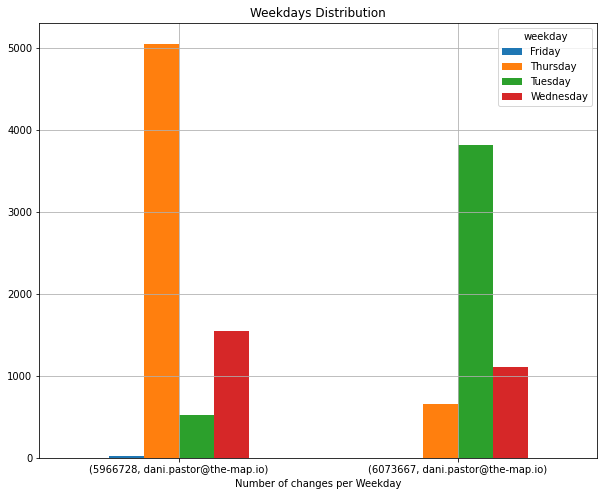

In [64]:
weekdays = all_traders.groupby(['Campaign ID', 'User','weekday']).size().unstack()
weekdays.plot(kind = 'bar', grid = True, figsize=(10, 8))

plt.title('Weekdays Distribution')
plt.xlabel('Number of changes per Weekday')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

#### What is the Distribution of the STAGE changes?

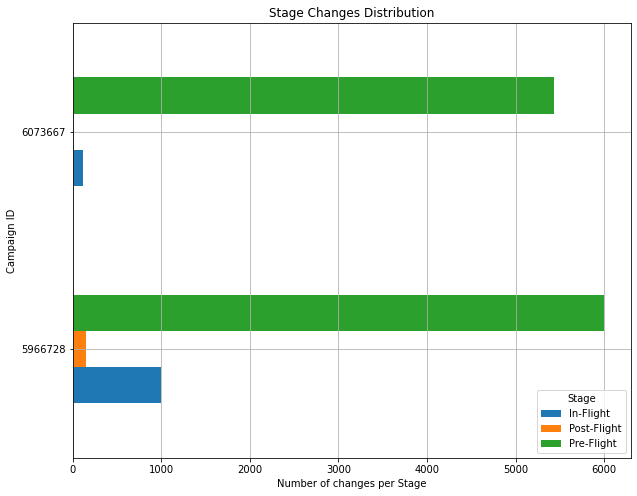

In [65]:
stage_changes = all_traders.groupby(['Campaign ID','Stage']).size().unstack()
stage_changes.plot(kind = 'barh', grid = True, figsize=(10, 8))

plt.title('Stage Changes Distribution')
plt.xlabel('Number of changes per Stage')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

#### Break down the STAGE changes into CATEGORY TYPE

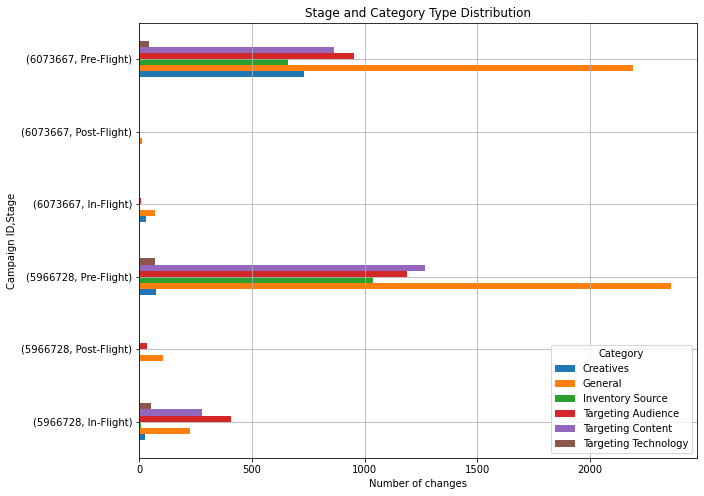

In [66]:
category_type_changes = all_traders.groupby(['Campaign ID','Stage','Category']).size().unstack()
category_type_changes.plot(kind = 'barh', grid = True, figsize=(10, 8))

plt.title('Stage and Category Type Distribution')
plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

#### What we are reall yinterested in is the IN - FLIGHT changes so lets take a closer look

In [67]:
inflight_changes = all_traders.loc[all_traders['Stage'] == 'In-Flight']

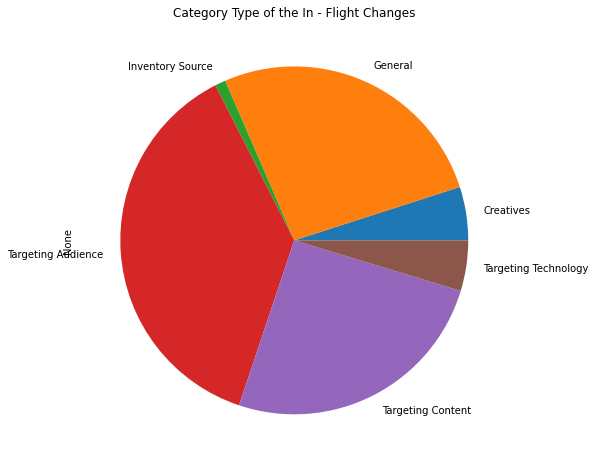

In [68]:
df_gb = inflight_changes.groupby(['Category']).size()
df_gb.plot(kind = 'pie', grid = True, figsize=(10, 8))

plt.title('Category Type of the In - Flight Changes')
#plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

#### Targeting Audience and Targeting Content is the most widely used change by the Trader so lets look even closer 

In [69]:
targeting_audience = all_traders.loc[all_traders['Category'] == 'Targeting Audience']
targeting_content = all_traders.loc[all_traders['Category'] == 'Targeting Content']
general = all_traders.loc[all_traders['Category'] == 'General']

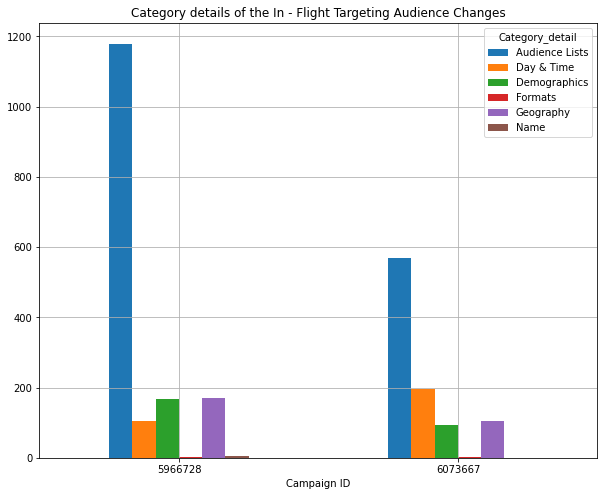

In [70]:
audience = targeting_audience.groupby(['Campaign ID','Category_detail']).size().unstack()
audience.plot(kind = 'bar', grid = True, figsize=(10, 8))

plt.title('Category details of the In - Flight Targeting Audience Changes')
#plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

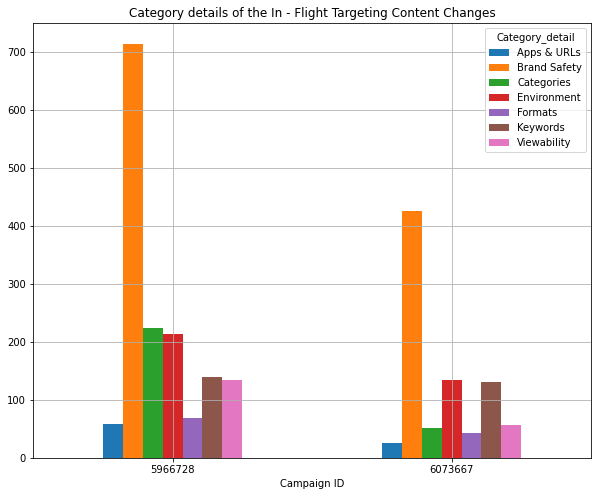

In [71]:
content = targeting_content.groupby(['Campaign ID','Category_detail']).size().unstack()
content.plot(kind = 'bar', grid = True, figsize=(10, 8))

plt.title('Category details of the In - Flight Targeting Content Changes')
#plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

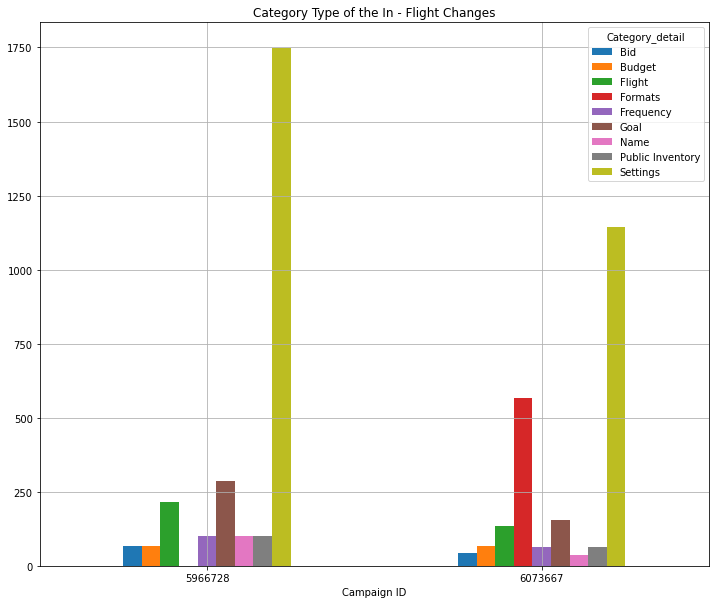

In [72]:
general = general.groupby(['Campaign ID','Category_detail']).size().unstack()
general.plot(kind = 'bar', grid = True, figsize=(12, 10))

plt.title('Category Type of the In - Flight Changes')
#plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

## 7. Feature Engineering of Change Data

In [73]:
#create two columns that includes the two information we are interested in
of_traders['Stage_Category'] = of_traders['Stage'] + of_traders['Category']
of_traders['Stage_Category_detail'] = of_traders['Stage'] + of_traders['Category_detail']

In [74]:
readly_traders['Stage_Category'] = readly_traders['Stage'] + readly_traders['Category']
readly_traders['Stage_Category_detail'] = readly_traders['Stage'] + readly_traders['Category_detail']

In [75]:
all_traders['Stage_Category'] = all_traders['Stage'] + all_traders['Category']
all_traders['Stage_Category_detail'] = all_traders['Stage'] + all_traders['Category_detail']

In [76]:
of_traders = of_traders.reset_index(drop=True)

In [77]:
readly_traders = readly_traders.reset_index(drop=True)

In [78]:
all_traders = all_traders.reset_index(drop=True)

In [79]:
#create binary variables  
#this will allow us to measure how many of each of the specific changes eahc change intervention have
data_cat = of_traders[['Stage','Stage_Category','Stage_Category_detail']]
onehot_encoder = OneHotEncoder()
data_encoded = onehot_encoder.fit_transform(data_cat)
#convert them to dataframe
columns = onehot_encoder.get_feature_names(input_features=data_cat.columns) #get the names of the columns

data_enc = pd.DataFrame(data_encoded.todense(), columns=columns)
of_traders = pd.concat([of_traders, data_enc], axis = 1)

In [80]:
data_cat = readly_traders[['Stage','Stage_Category','Stage_Category_detail']]
onehot_encoder = OneHotEncoder()
data_encoded = onehot_encoder.fit_transform(data_cat)
#convert them to dataframe
columns = onehot_encoder.get_feature_names(input_features=data_cat.columns) #get the names of the columns

data_enc = pd.DataFrame(data_encoded.todense(), columns=columns)
readly_traders = pd.concat([readly_traders, data_enc], axis = 1)

In [81]:
data_cat = all_traders[['Stage','Stage_Category','Stage_Category_detail']]
onehot_encoder = OneHotEncoder()
data_encoded = onehot_encoder.fit_transform(data_cat)
#convert them to dataframe
columns = onehot_encoder.get_feature_names(input_features=data_cat.columns) #get the names of the columns

data_enc = pd.DataFrame(data_encoded.todense(), columns=columns)
all_traders = pd.concat([all_traders, data_enc], axis = 1)

In [82]:
def counter_of(data):
    data = data_dict[key].copy()
    
    #group and aggregate data to find he number of each speficic change at each intervention
    grouped_multiple = data.groupby(['Campaign ID','Insertion order ID',
                                     'Line Item ID','date',
                                     'weekday',
                                     'User']).agg({'Stage_In-Flight':'sum',
                                                 'Stage_Category_In-FlightCreatives':'sum',
                                                 'Stage_Category_In-FlightGeneral':'sum',
                                                 'Stage_Category_In-FlightInventory Source':'sum',
                                                 'Stage_Category_In-FlightTargeting Audience':'sum',
                                                 'Stage_Category_In-FlightTargeting Content':'sum',
                                                 'Stage_Category_detail_In-FlightAudience Lists':'sum',
                                                 'Stage_Category_detail_In-FlightFormats':'sum',
                                                 'Stage_Category_detail_In-FlightPublic Inventory':'sum',
                                                 'Stage_Category_detail_In-FlightSettings':'sum',
                                                 'Stage_Category_detail_In-FlightViewability':'sum'})                             

                                                                                                        
    grouped_multiple.columns = ['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                'In-Flight Inventory Source','In-Flight Targeting Audience',
                                'In-Flight Targeting Content','Audience Lists','Formats',
                                'Public Inventory','Settings','Viewability'] 
                            

    grouped_multiple = grouped_multiple.reset_index()
    
    data_dict[key] = grouped_multiple

In [83]:
#create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in of_traders.groupby('Line Item ID')}

In [84]:
for key in data_dict.keys():
    counter_of(key)

In [85]:
#concatenate the dataframes fro mthe dictionary
of_changes = pd.concat(data_dict.values())

In [86]:
def counter_readly(data):
    data = data_dict[key].copy()
    
    grouped_multiple = data.groupby(['Campaign ID','Insertion order ID',
                                     'Line Item ID','date','weekday',
                                     'User']).agg({'Stage_In-Flight':'sum',
                                                     'Stage_Category_In-FlightCreatives':'sum',
                                                     'Stage_Category_In-FlightGeneral':'sum',
                                                     'Stage_Category_In-FlightInventory Source':'sum',
                                                     'Stage_Category_In-FlightTargeting Audience':'sum',
                                                     'Stage_Category_In-FlightTargeting Content':'sum',
                                                     'Stage_Category_In-FlightTargeting Technology':'sum',
                                                     'Stage_Category_detail_In-FlightApps & URLs':'sum',
                                                     'Stage_Category_detail_In-FlightAudience Lists':'sum',
                                                     'Stage_Category_detail_In-FlightBrand Safety':'sum',
                                                     'Stage_Category_detail_In-FlightCategories':'sum',
                                                     'Stage_Category_detail_In-FlightDay & Time':'sum',
                                                     'Stage_Category_detail_In-FlightDemographics':'sum',
                                                     'Stage_Category_detail_In-FlightDevice':'sum',
                                                     'Stage_Category_detail_In-FlightFlight':'sum',
                                                     'Stage_Category_detail_In-FlightFormats':'sum',
                                                     'Stage_Category_detail_In-FlightGoal':'sum',
                                                     'Stage_Category_detail_In-FlightName':'sum',
                                                     'Stage_Category_detail_In-FlightPublic Inventory':'sum',
                                                     'Stage_Category_detail_In-FlightSettings':'sum',
                                                     'Stage_Category_detail_In-FlightViewability':'sum'})                             
                                                                                                        
                                                                                                        
    grouped_multiple.columns = ['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 'In-Flight Inventory Source',
                               'In-Flight Targeting Audience', 'In-Flight Targeting Content', 'In-Flight Targeting Technology',
                               'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory','Settings','Viewability'] 
                            
    
    grouped_multiple = grouped_multiple.reset_index()
    
    data_dict[key] = grouped_multiple

In [87]:
#create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in readly_traders.groupby('Line Item ID')}

In [88]:
for key in data_dict.keys():
    counter_readly(key)

In [89]:
#concatenate the dataframes fro mthe dicitonary
readly_changes = pd.concat(data_dict.values())

In [90]:
#create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in all_traders.groupby('Line Item ID')}

In [91]:
for key in data_dict.keys():
    counter_readly(key)

In [92]:
all_changes = pd.concat(data_dict.values())

In [93]:
#rename the columns before concatinating the performance and changes data
of_changes = of_changes.rename(columns={'Line Item ID': 'Line_Item_ID', 'date': 'Date', 
                                        'Insertion order ID':'Insertion_Order_ID', 'Campaign ID':'Campaign_ID'})

readly_changes = readly_changes.rename(columns={'Line Item ID': 'Line_Item_ID', 'date': 'Date', 
                                        'Insertion order ID':'Insertion_Order_ID','Campaign ID':'Campaign_ID'})

all_changes = all_changes.rename(columns={'Line Item ID': 'Line_Item_ID', 'date': 'Date', 
                                        'Insertion order ID':'Insertion_Order_ID','Campaign ID':'Campaign_ID'})

In [94]:
of_changes = of_changes.reset_index(drop=True)
readly_changes = readly_changes.reset_index(drop=True)
all_changes = all_changes.reset_index(drop=True)

In [95]:
of_changes.head()
readly_changes.head()
all_changes.head()

,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Date,weekday,User,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,In-Flight Targeting Audience,In-Flight Targeting Content,Audience Lists,Formats,Public Inventory,Settings,Viewability
0,6073667,19546747,49264599,2021-04-15,Thursday,dani.pastor@the-map.io,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6073667,19546747,49264599,2021-04-20,Tuesday,dani.pastor@the-map.io,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6073667,19546747,49264599,2021-04-21,Wednesday,dani.pastor@the-map.io,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,6073667,19546747,49264599,2021-04-27,Tuesday,dani.pastor@the-map.io,23.0,8.0,3.0,1.0,8.0,3.0,8.0,11.0,1.0,0.0,3.0
4,6073667,19546747,49264599,2021-05-06,Thursday,dani.pastor@the-map.io,7.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Date,weekday,User,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Day & Time,Demographics,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability
0,5966728,19236555,48885946,2021-04-08,Thursday,dani.pastor@the-map.io,3.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
1,5966728,19236555,48885946,2021-04-09,Friday,dani.pastor@the-map.io,17.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,4.0,0.0
2,5966728,19236555,48885946,2021-04-14,Wednesday,dani.pastor@the-map.io,13.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,5966728,19236555,48885946,2021-04-22,Thursday,dani.pastor@the-map.io,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5966728,19236555,48885946,2021-05-20,Thursday,dani.pastor@the-map.io,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


,Campaign_ID,Insertion_Order_ID,Line_Item_ID,Date,weekday,User,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Day & Time,Demographics,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability
0,5966728,19236555,48885946,2021-04-08,Thursday,dani.pastor@the-map.io,3.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
1,5966728,19236555,48885946,2021-04-09,Friday,dani.pastor@the-map.io,17.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,4.0,0.0
2,5966728,19236555,48885946,2021-04-14,Wednesday,dani.pastor@the-map.io,13.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,5966728,19236555,48885946,2021-04-22,Thursday,dani.pastor@the-map.io,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5966728,19236555,48885946,2021-05-20,Thursday,dani.pastor@the-map.io,2.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


## 8. Join Performance and Change Data

In [96]:
#find the line item id associated with the CPA KPI based on the lists that are generated form the begining using the sdf data
of_changes_cpa = of_changes[of_changes['Line_Item_ID'].isin(cpa_lst_of)]
readly_changes_cpa = readly_changes[readly_changes['Line_Item_ID'].isin(cpa_lst_readly)]

### OF RESULT DATASET

In [97]:
of_changes_cpa = of_changes_cpa.drop(['weekday'], axis=1)

In [98]:
of_changes_cpa = of_changes_cpa.rename(columns={'Line_Item_ID': 'Line Item ID', 
                                        'Insertion_Order_ID':'Insertion order ID'})

In [99]:
of_result_cpa = pd.merge(of_performance_cpa, of_changes_cpa, how="outer", on=["Campaign_ID","Insertion order ID",
                                                                           "Line Item ID", "Date"])

In [100]:
of_result_cpa.update(of_result_cpa[['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                    'In-Flight Inventory Source','In-Flight Targeting Audience', 'In-Flight Targeting Content',
                                    'Audience Lists','Formats', 'Public Inventory','Settings','Viewability']].fillna(0))

In [101]:
of_result_cpa = of_result_cpa.dropna(subset=['Cumulative CPA'])

In [102]:
col_names = ['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                    'In-Flight Inventory Source','In-Flight Targeting Audience', 'In-Flight Targeting Content',
                                    'Audience Lists','Formats', 'Public Inventory','Settings','Viewability']

for col in col_names:
    of_result_cpa[col] = of_result_cpa[col].astype(int)

### READLY RESULT DATASET

In [103]:
readly_changes_cpa = readly_changes_cpa.drop(['weekday'], axis=1)

In [104]:
readly_changes_cpa = readly_changes_cpa.rename(columns={'Line_Item_ID': 'Line Item ID', 
                                        'Insertion_Order_ID':'Insertion order ID'})

In [105]:
readly_result_cpa = pd.merge(readly_performance_cpa, readly_changes_cpa, how="outer", on=["Campaign_ID",
                                                                                          "Insertion order ID",
                                                                           "Line Item ID", "Date"])

In [106]:
readly_result_cpa.update(readly_result_cpa[['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                    'In-Flight Inventory Source', 'In-Flight Targeting Audience', 'In-Flight Targeting Content',
                                    'In-Flight Targeting Technology','Apps & URLS','Audience Lists','Brand Safety','Categories',
                                    'Day & Time','Demographics','Device','Flight','Formats','Goal','Name','Public Inventory',
                                    'Settings','Viewability']].fillna(0))

In [107]:
readly_result_cpa = readly_result_cpa.dropna(subset=['Cumulative CPA'])

In [108]:
col_names = ['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                    'In-Flight Inventory Source', 'In-Flight Targeting Audience', 'In-Flight Targeting Content',
                                    'In-Flight Targeting Technology','Apps & URLS','Audience Lists','Brand Safety','Categories',
                                    'Day & Time','Demographics','Device','Flight','Formats','Goal','Name','Public Inventory',
                                    'Settings','Viewability']

for col in col_names:
    readly_result_cpa[col] = readly_result_cpa[col].astype(int)

### ALL DATASET

In [109]:
all_changes = all_changes.drop(['weekday'], axis=1)

In [110]:
all_changes = all_changes.rename(columns={'Line_Item_ID': 'Line Item ID', 
                                        'Insertion_Order_ID':'Insertion order ID'})

In [111]:
#merge the change log data wit hthe performance data
all_result_cpa = pd.merge(all_performance, all_changes, how="outer", on=["Campaign_ID",
                                                                                          "Insertion order ID",
                                                                           "Line Item ID", "Date"])

In [112]:
#fill the null values with zero
all_result_cpa.update(all_result_cpa[['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 
                                    'In-Flight Inventory Source', 'In-Flight Targeting Audience', 
                                      'In-Flight Targeting Content', 'In-Flight Targeting Technology','Apps & URLS',
                                      'Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                                      'Device','Flight','Formats','Goal','Name','Public Inventory',
                                    'Settings','Viewability']].fillna(0))

In [113]:
#drop the rows where the cumulative cpa is null
all_result_cpa = all_result_cpa.dropna(subset=['Cumulative CPA'])

In [114]:
#convert the values of the columns into integers
col_names = ['Total In-Flight Changes','In-Flight Creatives', 'In-Flight General', 'In-Flight Inventory Source', 
             'In-Flight Targeting Audience', 'In-Flight Targeting Content','In-Flight Targeting Technology',
             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics','Device','Flight',
             'Formats','Goal','Name','Public Inventory','Settings','Viewability']

for col in col_names:
    all_result_cpa[col] = all_result_cpa[col].astype(int)

In [115]:
#insoect the dataset
all_result_cpa

,Campaign_ID,Insertion order ID,Line Item ID,Date,Cumulative CPA,User,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Day & Time,Demographics,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability
0,6073667,19546747,49264599,2021-04-22,0.00,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6073667,19546747,49264599,2021-04-23,0.00,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6073667,19546747,49264599,2021-04-24,56.39,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6073667,19546747,49264599,2021-04-25,25.46,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6073667,19546747,49264599,2021-04-26,33.54,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,5966728,19344160,49636900,2021-05-16,12.92,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1556,5966728,19344160,49636900,2021-05-17,13.08,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1557,5966728,19344160,49636900,2021-05-18,13.19,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1558,5966728,19344160,49636900,2021-05-19,13.32,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 9. SCORE and RATE Change Interventions

In [116]:
all_result_cpa1 = all_result_cpa[['Campaign_ID', 'Insertion order ID','Line Item ID','Date', 'User','Cumulative CPA',
                                 'Total In-Flight Changes','In-Flight Creatives',
                      'In-Flight General','In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology',
                             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory',
                              'Settings','Viewability']]

In [117]:
def evaluate_changes(data):
    #take one datafram at a timefrom the dicitonary of dataframes
    data = data_dict[key].copy()
    
    #select only the rows where a change has been made (select only the change interceptions)
    information = []
    for index, row in data.iterrows():
        if row['Total In-Flight Changes'] > 0:
            information.append(row)
    
    df = DataFrame (information,columns=['Campaign_ID', 'Insertion order ID','Line Item ID','Date', 'User','Cumulative CPA',
                                 'Total In-Flight Changes','In-Flight Creatives',
                      'In-Flight General','In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology',
                             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory',
                              'Settings','Viewability'])
    
    #add the last row of each dataset for the evaluation to take place
    new_row = data.tail(1)
    df = df.append(new_row, ignore_index=True)
    
    #find the difference and based on tha tcategorize the intervenitons
    df['Difference'] = df['Cumulative CPA'].diff().fillna(0)
    df['Cumulative CPA change'] = np.where(df['Difference'] == 0, 'No Change',
          np.where(df['Difference'] > 0,   'Increase', 'Decrease'))
    
    df['previous'] = df['Total In-Flight Changes'].shift(1)
    df['previous'] = df['previous'].fillna(0)
    
    #find the percentage change 
    df['Percentage change'] = df['Cumulative CPA'].pct_change()
    df['Percentage change']=df['Percentage change'].shift(-1)
    df['Percentage change']=df['Percentage change']*100
    df['Percentage change']=df['Percentage change'].round(2)
    
    #fnd the impact
    df['Change Impact'] = np.where(df['previous'] == 0, '-',
      np.where((df['previous'] > 0) & (df['Cumulative CPA change'] == 'Increase'), 'Negative', 'Positive'))

    df['Change Impact'] = df['Change Impact'].shift(-1)
    df['Difference'] = df['Difference'].shift(-1)
    


    df = df.drop(['previous','Cumulative CPA change', 'Difference'], axis =1)
    to_drop = df[(df['Total In-Flight Changes'] == 0)]

    df.drop(to_drop.index, inplace=True)
    
    df.sort_values(by=['Date'], inplace=True)

    data_dict[key] = df

In [118]:
# #create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in all_result_cpa1.groupby('Line Item ID')}

In [119]:
for key in data_dict.keys():
    evaluate_changes(key)

In [120]:
#concatenate the dataframes
df_impact = pd.concat(data_dict.values())

In [121]:
df_impact = df_impact.reset_index(drop=True)

In [122]:
df_impact = df_impact.dropna()

In [123]:
#inspect the dataset
df_impact

,Campaign_ID,Insertion order ID,Line Item ID,Date,User,Cumulative CPA,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability,Percentage change,Change Impact
0,5966728,19236555,48885946,2021-04-14,dani.pastor@the-map.io,85.92,13,0,1,0,...,0,0,0,1,0,0,0,0,36.09,Negative
1,5966728,19236555,48885946,2021-04-22,dani.pastor@the-map.io,116.93,18,0,0,0,...,0,0,0,0,0,0,0,0,-80.28,Positive
2,5966728,19236555,48885946,2021-05-20,dani.pastor@the-map.io,23.06,2,0,2,0,...,0,0,0,0,0,0,2,0,-8.76,Positive
3,5966728,19236555,48894114,2021-04-22,dani.pastor@the-map.io,10.35,6,0,0,0,...,0,0,0,0,0,0,0,0,-30.63,Positive
4,5966728,19236555,48894114,2021-05-20,dani.pastor@the-map.io,7.18,1,0,1,0,...,0,0,0,0,0,0,1,0,-41.64,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,6073667,19546747,50298539,2021-05-06,dani.pastor@the-map.io,4.74,4,0,4,0,...,0,0,0,0,0,0,4,0,9.07,Negative
104,6073667,19546747,50298542,2021-05-06,dani.pastor@the-map.io,0.00,3,0,3,0,...,0,0,0,0,0,0,3,0,inf,Negative
105,6073667,19546747,50307721,2021-05-05,dani.pastor@the-map.io,0.00,1,0,1,0,...,0,0,0,0,0,0,1,0,inf,Negative
106,6073667,19546747,50307721,2021-05-06,dani.pastor@the-map.io,7.92,4,0,4,0,...,0,0,0,0,0,0,4,0,-69.32,Positive


In [124]:
#select a given insertion order
io =df_impact.loc[df_impact['Insertion order ID'] == 19236555]

In [125]:
io

,Campaign_ID,Insertion order ID,Line Item ID,Date,User,Cumulative CPA,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability,Percentage change,Change Impact
0,5966728,19236555,48885946,2021-04-14,dani.pastor@the-map.io,85.92,13,0,1,0,...,0,0,0,1,0,0,0,0,36.09,Negative
1,5966728,19236555,48885946,2021-04-22,dani.pastor@the-map.io,116.93,18,0,0,0,...,0,0,0,0,0,0,0,0,-80.28,Positive
2,5966728,19236555,48885946,2021-05-20,dani.pastor@the-map.io,23.06,2,0,2,0,...,0,0,0,0,0,0,2,0,-8.76,Positive
3,5966728,19236555,48894114,2021-04-22,dani.pastor@the-map.io,10.35,6,0,0,0,...,0,0,0,0,0,0,0,0,-30.63,Positive
4,5966728,19236555,48894114,2021-05-20,dani.pastor@the-map.io,7.18,1,0,1,0,...,0,0,0,0,0,0,1,0,-41.64,Positive
5,5966728,19236555,48911781,2021-04-22,dani.pastor@the-map.io,49.53,6,0,0,0,...,0,0,0,0,0,0,0,0,-90.07,Positive
6,5966728,19236555,48911781,2021-05-20,dani.pastor@the-map.io,4.92,2,0,2,0,...,0,0,0,0,0,0,2,0,-50.20,Positive
7,5966728,19236555,48917180,2021-04-22,dani.pastor@the-map.io,11.24,6,0,0,0,...,0,0,0,0,0,0,0,0,-65.48,Positive
8,5966728,19236555,48917181,2021-04-22,dani.pastor@the-map.io,6.11,6,0,0,0,...,0,0,0,0,0,0,0,0,-32.90,Positive
9,5966728,19236555,48917181,2021-05-20,dani.pastor@the-map.io,4.10,2,0,2,0,...,0,0,0,0,0,0,2,0,-31.46,Positive


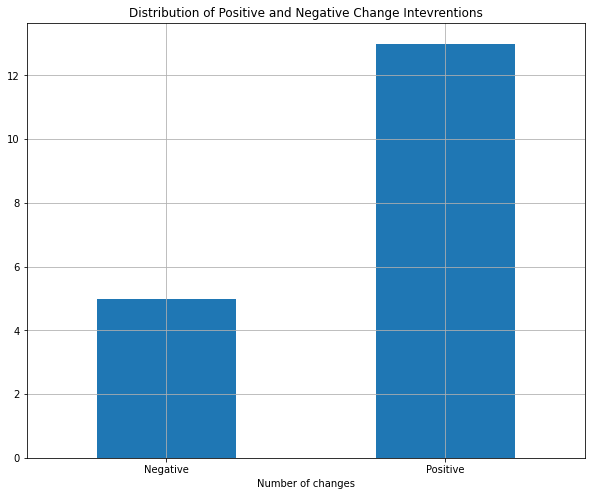

In [126]:
impact = io.groupby(['Change Impact']).size()
impact.plot(kind = 'bar', grid = True, figsize=(10, 8))

plt.title('Distribution of Positive and Negative Change Intevrentions')
plt.xlabel('Number of changes')
#plt.ylabel('Number of changes')
plt.xticks(rotation=0, horizontalalignment="center");

In [127]:
df_impact.loc[df_impact['Line Item ID'] == 48911781]

,Campaign_ID,Insertion order ID,Line Item ID,Date,User,Cumulative CPA,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability,Percentage change,Change Impact
5,5966728,19236555,48911781,2021-04-22,dani.pastor@the-map.io,49.53,6,0,0,0,...,0,0,0,0,0,0,0,0,-90.07,Positive
6,5966728,19236555,48911781,2021-05-20,dani.pastor@the-map.io,4.92,2,0,2,0,...,0,0,0,0,0,0,2,0,-50.20,Positive


In [128]:
def score_rating(data):
    data = data_dict[key].copy()
    
    #find the socre of each traders based on the toal intevrneitons he made
    total_changes = data.loc[data['Total In-Flight Changes']> 0, 'Total In-Flight Changes'].count()
    total_positive_changes = data.loc[data['Change Impact'] == 'Positive', 'Change Impact'].count()
    
    score = ((total_positive_changes/total_changes)*100).round()
    
    data['Score'] = score
    data['Total Interventions'] = total_changes
    data['Total Positive Interventions'] = total_positive_changes
    
    #generate the conditions (ratings)
    conditions = [
        (data['Percentage change'] == 0) | (data['Percentage change'] > 0),
        (data['Percentage change'] < 0) & (data['Percentage change'] > -20),
        (data['Percentage change'] < -20) & (data['Percentage change'] > -40),
        (data['Percentage change'] < -40) & (data['Percentage change'] > -60),
        (data['Percentage change'] < -60) & (data['Percentage change'] > -80),
        (data['Percentage change'] < -80)]

    choices = [0, 1,2,3,4,5]
    data['Rating'] = np.select(conditions, choices)
    
    data["Rating"] = pd.to_numeric(data["Rating"])
    total_rating = data['Rating'].sum()
    changes_count = data.loc[data['Total In-Flight Changes']> 0, 'Total In-Flight Changes'].count()
    average_rating = (total_rating/changes_count).round(2)
    data['Average Rating per Line Item'] = average_rating    


    data_dict[key] = data

In [129]:
# #create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in df_impact.groupby('Line Item ID')}

In [130]:
for key in data_dict.keys():
    score_rating(key)

In [131]:
#concatenate and inspect the dataset
df_score_rating = pd.concat(data_dict.values())
df_score_rating

,Campaign_ID,Insertion order ID,Line Item ID,Date,User,Cumulative CPA,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,...,Public Inventory,Settings,Viewability,Percentage change,Change Impact,Score,Total Interventions,Total Positive Interventions,Rating,Average Rating per Line Item
0,5966728,19236555,48885946,2021-04-14,dani.pastor@the-map.io,85.92,13,0,1,0,...,0,0,0,36.09,Negative,67.0,3,2,0,2.0
1,5966728,19236555,48885946,2021-04-22,dani.pastor@the-map.io,116.93,18,0,0,0,...,0,0,0,-80.28,Positive,67.0,3,2,5,2.0
2,5966728,19236555,48885946,2021-05-20,dani.pastor@the-map.io,23.06,2,0,2,0,...,0,2,0,-8.76,Positive,67.0,3,2,1,2.0
3,5966728,19236555,48894114,2021-04-22,dani.pastor@the-map.io,10.35,6,0,0,0,...,0,0,0,-30.63,Positive,100.0,2,2,2,2.5
4,5966728,19236555,48894114,2021-05-20,dani.pastor@the-map.io,7.18,1,0,1,0,...,0,1,0,-41.64,Positive,100.0,2,2,3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,6073667,19546747,50298539,2021-05-06,dani.pastor@the-map.io,4.74,4,0,4,0,...,0,4,0,9.07,Negative,0.0,2,0,0,0.0
104,6073667,19546747,50298542,2021-05-06,dani.pastor@the-map.io,0.00,3,0,3,0,...,0,3,0,inf,Negative,0.0,1,0,0,0.0
105,6073667,19546747,50307721,2021-05-05,dani.pastor@the-map.io,0.00,1,0,1,0,...,0,1,0,inf,Negative,50.0,2,1,0,2.0
106,6073667,19546747,50307721,2021-05-06,dani.pastor@the-map.io,7.92,4,0,4,0,...,0,4,0,-69.32,Positive,50.0,2,1,4,2.0


In [150]:
#select a given insertion order
io =df_score_rating.loc[df_impact['Insertion order ID'] == 19236555]

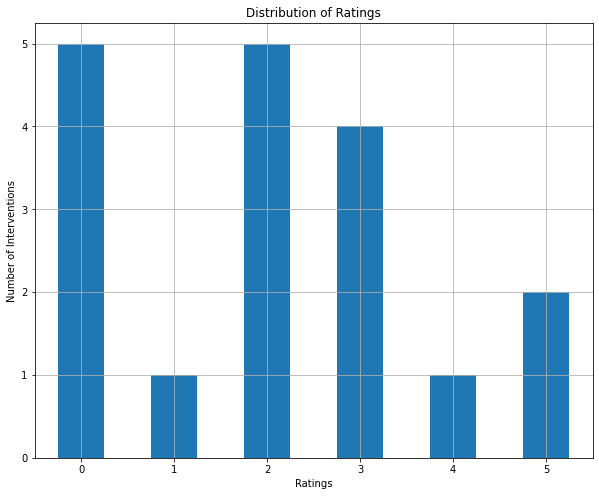

In [151]:
rating = io.groupby(['Rating']).size()
rating.plot(kind = 'bar', grid = True, figsize=(10, 8))

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Interventions')
plt.xticks(rotation=0, horizontalalignment="center");

In [133]:
def table(data):
    data = data_dict[key].copy()
    
    final_table = data[['Campaign_ID', 'Insertion order ID',"Line Item ID","User" ,
                        "Total Interventions", "Total Positive Interventions","Score",
                       'Average Rating per Line Item']]
    
    final_table = final_table.drop_duplicates(subset='Line Item ID')
    
    data_dict[key] = final_table

In [134]:
# #create a dictionary of dataframes based on the line item id 
data_dict={'df'+str(i): grp for i , grp in df_score_rating.groupby('Line Item ID')}

In [135]:
for key in data_dict.keys():
    table(key)

In [136]:
final_table = pd.concat(data_dict.values())
final_table

,Campaign_ID,Insertion order ID,Line Item ID,User,Total Interventions,Total Positive Interventions,Score,Average Rating per Line Item
0,5966728,19236555,48885946,dani.pastor@the-map.io,3,2,67.0,2.00
3,5966728,19236555,48894114,dani.pastor@the-map.io,2,2,100.0,2.50
5,5966728,19236555,48911781,dani.pastor@the-map.io,2,2,100.0,4.00
7,5966728,19236555,48917180,dani.pastor@the-map.io,1,1,100.0,4.00
8,5966728,19236555,48917181,dani.pastor@the-map.io,2,2,100.0,2.00
10,5966728,19360151,48936862,dani.pastor@the-map.io,6,4,67.0,1.67
16,5966728,19360151,48936863,dani.pastor@the-map.io,6,4,67.0,1.33
25,5966728,19360151,48936864,dani.pastor@the-map.io,1,0,0.0,0.00
28,5966728,19360151,48936865,dani.pastor@the-map.io,4,3,75.0,1.75
32,5966728,19360151,48936868,dani.pastor@the-map.io,4,3,75.0,2.50


### Find the Score of the Trader for a particular Campaign and Insertion Order

In [137]:
campaign = final_table.loc[final_table['Campaign_ID'] == 5966728]
campaign

,Campaign_ID,Insertion order ID,Line Item ID,User,Total Interventions,Total Positive Interventions,Score,Average Rating per Line Item
0,5966728,19236555,48885946,dani.pastor@the-map.io,3,2,67.0,2.00
3,5966728,19236555,48894114,dani.pastor@the-map.io,2,2,100.0,2.50
5,5966728,19236555,48911781,dani.pastor@the-map.io,2,2,100.0,4.00
7,5966728,19236555,48917180,dani.pastor@the-map.io,1,1,100.0,4.00
8,5966728,19236555,48917181,dani.pastor@the-map.io,2,2,100.0,2.00
10,5966728,19360151,48936862,dani.pastor@the-map.io,6,4,67.0,1.67
16,5966728,19360151,48936863,dani.pastor@the-map.io,6,4,67.0,1.33
25,5966728,19360151,48936864,dani.pastor@the-map.io,1,0,0.0,0.00
28,5966728,19360151,48936865,dani.pastor@the-map.io,4,3,75.0,1.75
32,5966728,19360151,48936868,dani.pastor@the-map.io,4,3,75.0,2.50


In [138]:
campaign_total_interventions = campaign['Total Interventions'].sum()
campaign_total_positive_interventions = campaign['Total Positive Interventions'].sum()

campaign_score = ((campaign_total_positive_interventions/campaign_total_interventions)*100).round()
campaign_score

54.0

In [139]:
io = final_table.loc[final_table['Insertion order ID'] == 19236555]
io

,Campaign_ID,Insertion order ID,Line Item ID,User,Total Interventions,Total Positive Interventions,Score,Average Rating per Line Item
0,5966728,19236555,48885946,dani.pastor@the-map.io,3,2,67.0,2.0
3,5966728,19236555,48894114,dani.pastor@the-map.io,2,2,100.0,2.5
5,5966728,19236555,48911781,dani.pastor@the-map.io,2,2,100.0,4.0
7,5966728,19236555,48917180,dani.pastor@the-map.io,1,1,100.0,4.0
8,5966728,19236555,48917181,dani.pastor@the-map.io,2,2,100.0,2.0
88,5966728,19236555,49627940,dani.pastor@the-map.io,2,1,50.0,1.0
90,5966728,19236555,49627941,dani.pastor@the-map.io,2,1,50.0,1.5
92,5966728,19236555,49627942,dani.pastor@the-map.io,2,1,50.0,1.5
94,5966728,19236555,49627943,dani.pastor@the-map.io,2,1,50.0,1.0


In [140]:
io_total_interventions = io['Total Interventions'].sum()
io_total_positive_interventions = io['Total Positive Interventions'].sum()

io_score = ((io_total_positive_interventions/io_total_interventions)*100).round()
io_score

72.0

## 10. OLS Regression to study the impact of specific Change Types

In [141]:
#convert category and category detail columns into binary(0 or 1)
col_names = ['In-Flight Creatives','In-Flight General',
                              'In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology',
                             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory',
                              'Settings','Viewability']

for col in col_names:
    df_impact[col] = np.where(df_impact[col]> 0,   1, 0)

In [142]:
#convert them into category type
col_names = ['In-Flight Creatives','In-Flight General',
                              'In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology',
                             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory',
                              'Settings','Viewability']

for col in col_names:
    df_impact[col] = df_impact[col].astype('category',copy=False)

In [143]:
dataset = df_impact[["Percentage change","Total In-Flight Changes",'In-Flight Creatives','In-Flight General',
                              'In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology',
                             'Apps & URLS','Audience Lists','Brand Safety','Categories','Day & Time','Demographics',
                               'Device','Flight','Formats','Goal','Name','Public Inventory',
                              'Settings','Viewability']].replace([np.inf, -np.inf], np.nan)
dataset.dropna(inplace=True)
dataset

,Percentage change,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,In-Flight Targeting Audience,In-Flight Targeting Content,In-Flight Targeting Technology,Apps & URLS,Audience Lists,...,Day & Time,Demographics,Device,Flight,Formats,Goal,Name,Public Inventory,Settings,Viewability
0,36.09,13,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,-80.28,18,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-8.76,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-30.63,6,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-41.64,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,139.93,4,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
99,0.00,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101,233.00,12,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
103,9.07,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [144]:
import statsmodels.formula.api as sm
import statsmodels.api as sm

X = dataset.drop('Percentage change', axis=1)
y = dataset["Percentage change"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Percentage change   R-squared (uncentered):                   0.183
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              1.139
Date:                Sun, 01 Aug 2021   Prob (F-statistic):                       0.347
Time:                        14:39:42   Log-Likelihood:                         -405.27
No. Observations:                  73   AIC:                                      834.5
Df Residuals:                      61   BIC:                                      862.0
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Total In-Flight Changes           -0.6884      4.041     -0.170      0.865      -8.768       7.391
In-Flight Creatives                6.2794     21.812      0.288      0.774     -37.336      49.895
In-Flight General                 -8.9722     26.753     -0.335      0.739     -62.469      44.525
In-Flight Inventory Source       -15.7377     36.842     -0.427      0.671     -89.407      57.932
In-Flight Targeting Audience     -85.7384     81.663     -1.050      0.298    -249.033      77.557
In-Flight Targeting Content       61.1099     78.984      0.774      0.442     -96.828     219.048
In-Flight Targeting Technology    -8.6024     19.143     -0.449      0.655     -46.881      29.676
Apps & URLS                      -17.1966     28.792     -0.597      0.553     -74.770      40.377
Audience Lists                    33.5129     73.142      0.458      0.648    -112.744     179.770
Brand Safety                     -17.1966     28.792     -0.597      0.553     -74.770      40.377
Categories                       -17.1966     28.792     -0.597      0.553     -74.770      40.377
Day & Time                        76.6602     44.944      1.706      0.093     -13.210     166.531
Demographics                     131.6352     86.566      1.521      0.134     -41.464     304.734
Device                            -8.6024     19.143     -0.449      0.655     -46.881      29.676
Flight                                  0          0        nan        nan           0           0
Formats                            6.2794     21.812      0.288      0.774     -37.336      49.895
Goal                             106.2366     71.526      1.485      0.143     -36.788     249.262
Name                              76.6602     44.944      1.706      0.093     -13.210     166.531
Public Inventory                 -15.7377     36.842     -0.427      0.671     -89.407      57.932
Settings                         -22.8109     26.624     -0.857      0.395     -76.050      30.428
Viewability                      -28.9731     31.841     -0.910      0.366     -92.643      34.696
==============================================================================
Omnibus:                       55.892   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.443
Skew:                           2.384   Prob(JB):                     2.75e-52
Kurtosis:                      10.438   Cond. No.                     4.19e+33
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that

### seconde regression

In [145]:
dataset1 = df_impact[["Percentage change","Total In-Flight Changes",'In-Flight Creatives','In-Flight General',
                              'In-Flight Inventory Source','In-Flight Targeting Audience',
                             'In-Flight Targeting Content','In-Flight Targeting Technology']].replace([np.inf, -np.inf], np.nan)
dataset1.dropna(inplace=True)
dataset1

,Percentage change,Total In-Flight Changes,In-Flight Creatives,In-Flight General,In-Flight Inventory Source,In-Flight Targeting Audience,In-Flight Targeting Content,In-Flight Targeting Technology
0,36.09,13,0,1,0,1,0,0
1,-80.28,18,0,0,0,1,0,0
2,-8.76,2,0,1,0,0,0,0
3,-30.63,6,0,0,0,0,1,0
4,-41.64,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
98,139.93,4,0,0,0,0,1,0
99,0.00,2,0,1,0,0,0,0
101,233.00,12,0,0,0,0,1,0
103,9.07,4,0,1,0,0,0,0


In [146]:
import statsmodels.formula.api as sm
import statsmodels.api as sm

X = dataset1.drop('Percentage change', axis=1)
y = dataset1["Percentage change"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Percentage change   R-squared (uncentered):                   0.109
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              1.155
Date:                Sun, 01 Aug 2021   Prob (F-statistic):                       0.341
Time:                        14:39:42   Log-Likelihood:                         -408.43
No. Observations:                  73   AIC:                                      830.9
Df Residuals:                      66   BIC:                                      846.9
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Total In-Flight Changes           -0.2590      3.237     -0.080      0.936      -6.722       6.204
In-Flight Creatives               -3.2493     43.748     -0.074      0.941     -90.595      84.097
In-Flight General                -31.2861     16.313     -1.918      0.059     -63.857       1.285
In-Flight Inventory Source         9.2431     57.589      0.161      0.873    -105.738     124.224
In-Flight Targeting Audience      27.8338     38.076      0.731      0.467     -48.187     103.855
In-Flight Targeting Content        0.5612     23.882      0.023      0.981     -47.120      48.243
In-Flight Targeting Technology   -16.6008     37.760     -0.440      0.662     -91.991      58.789
==============================================================================
Omnibus:                       51.559   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.138
Skew:                           2.223   Prob(JB):                     1.90e-42
Kurtosis:                       9.588   Cond. No.                         96.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 11. Some Further Visualizations 

In [147]:
def plot_cpa_with_changes(data):
    data = data_dict_cpa_changes[key].copy()
    dates = []
    for index, row in data.iterrows():
        if row['Total In-Flight Changes'] > 0:
            dates.append(row['Date'])

    # Define plot space
    fig, ax = plt.subplots(figsize=(10,8))

    # Define x and y axes
    ax.plot(data.Date, 
            data['Cumulative CPA'],
           marker = 'o',
           color = 'red')

    for i in dates:
        plt.axvline(x=i)
    
    ax.set(title = ("Cumulative CPA - Line Item ID" + ":",key),
       xlabel = "Date", 
        ylabel = "Cumulative CPA")

In [148]:
#create a dictionary of dataframes based on the line item id 
data_dict_cpa_changes={'df'+str(i): grp for i , grp in all_result_cpa.groupby('Line Item ID')}

<ipython-input-147-8ff813dcebd3>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,8))


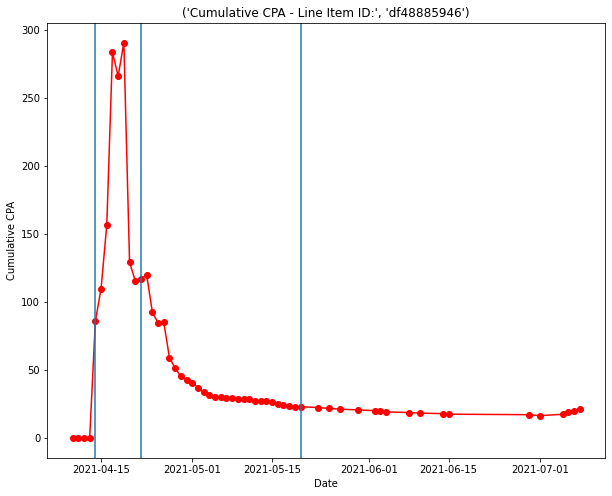

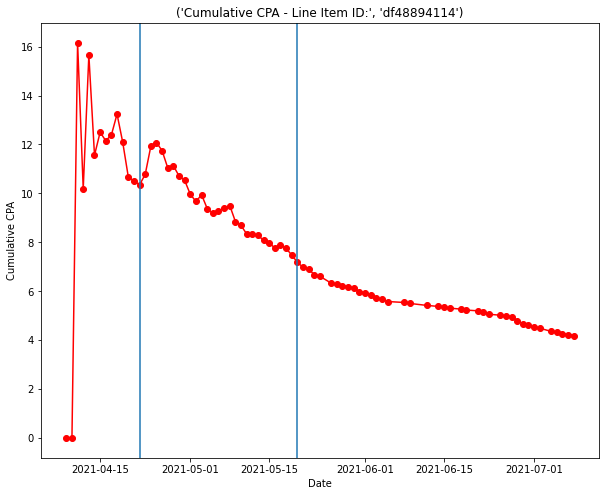

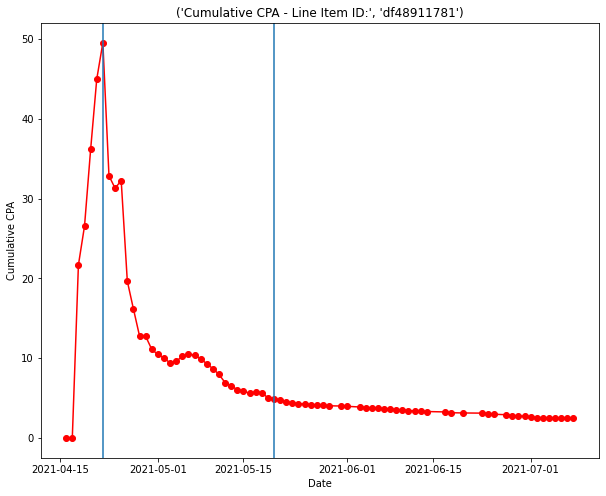

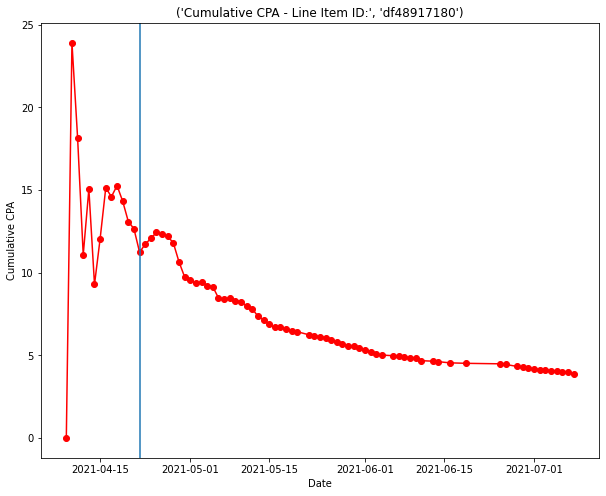

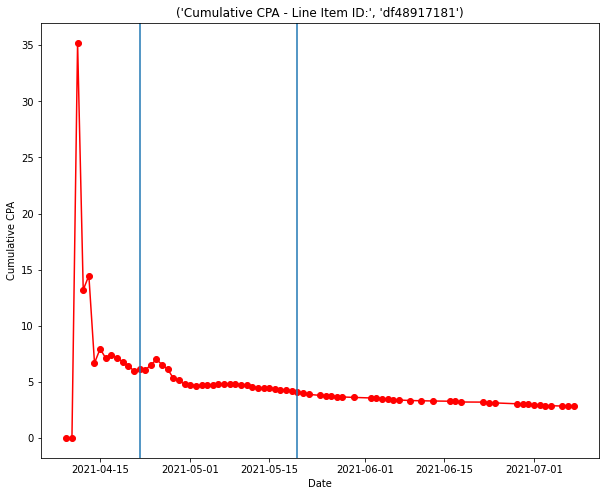

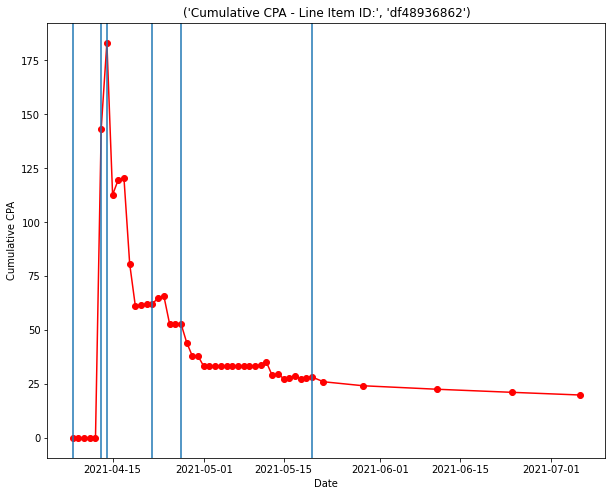

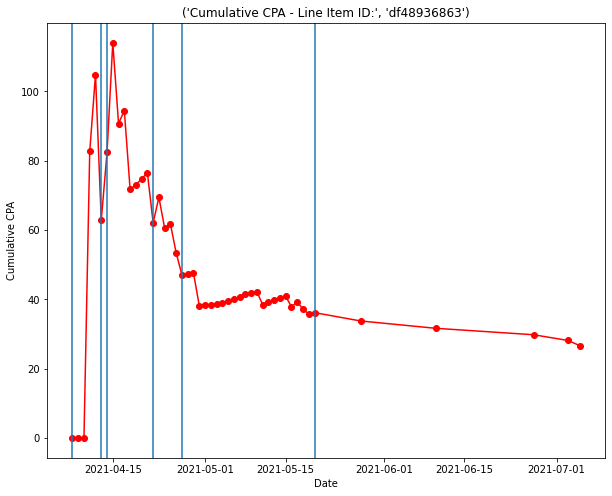

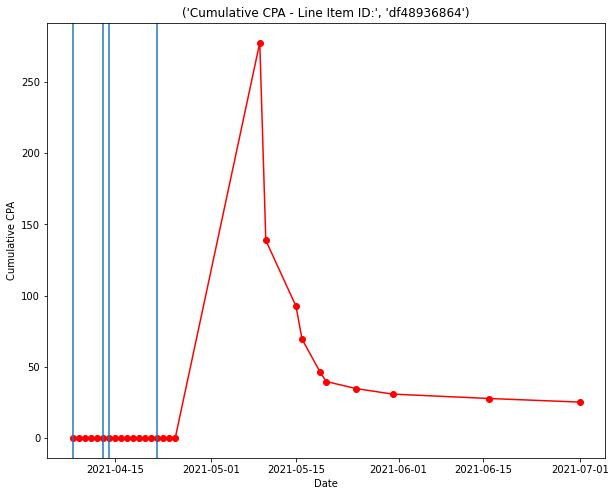

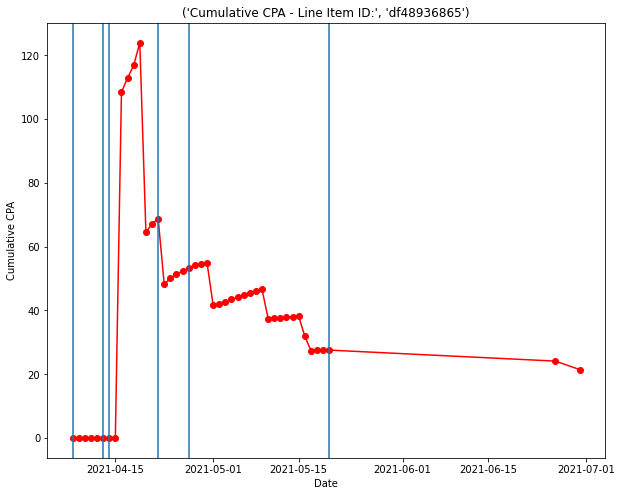

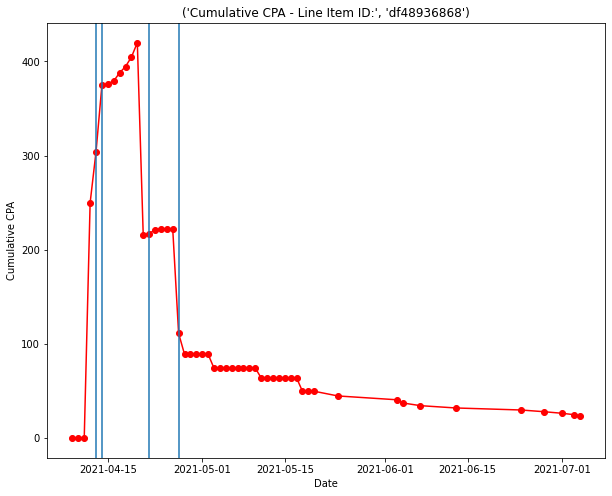

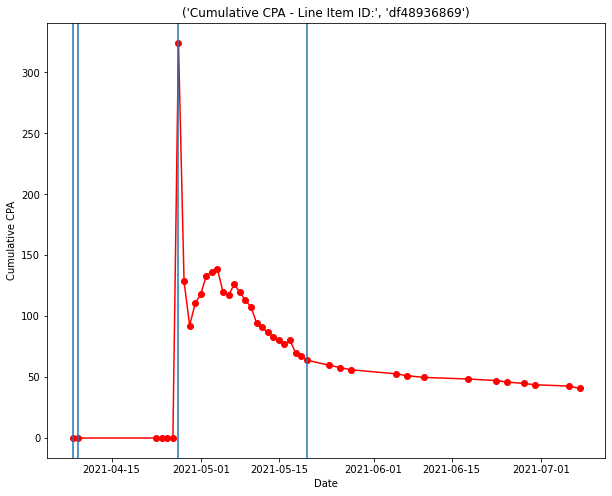

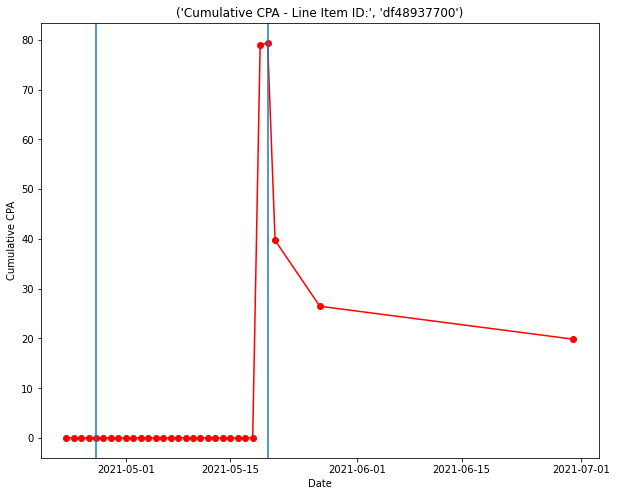

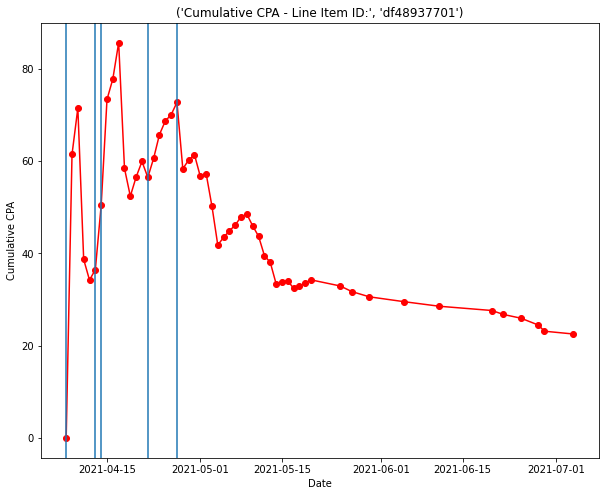

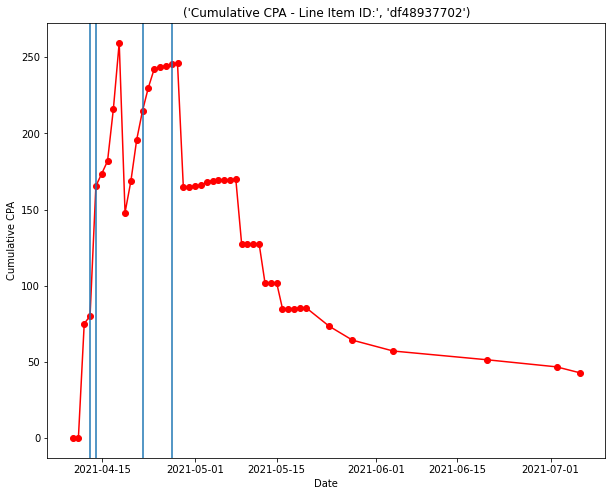

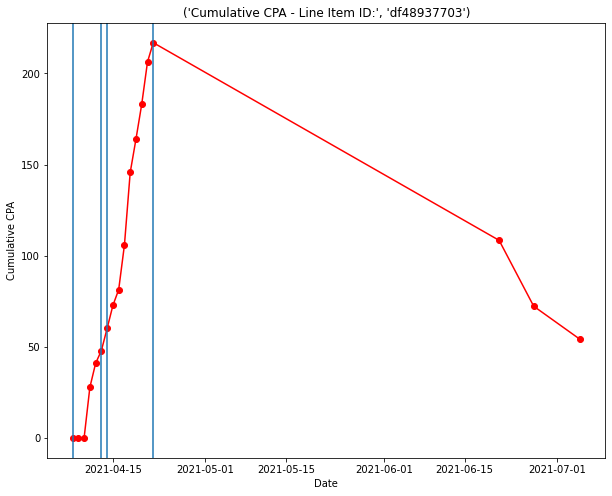

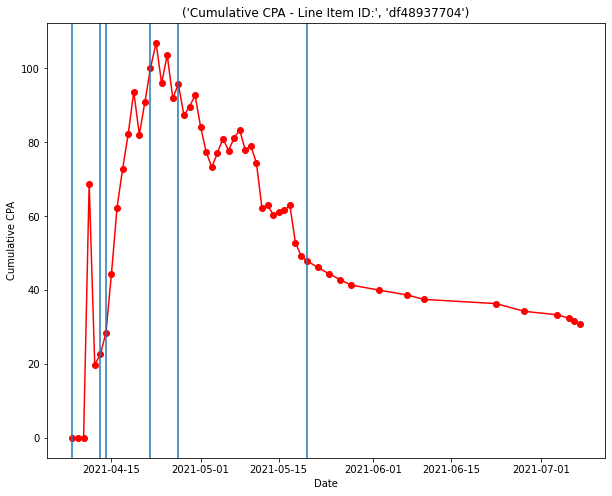

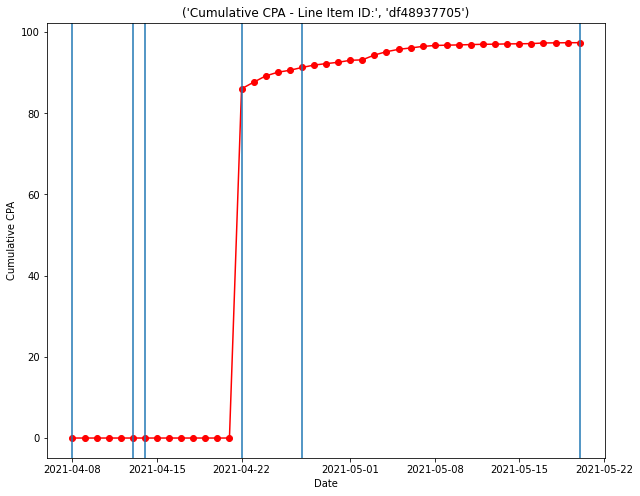

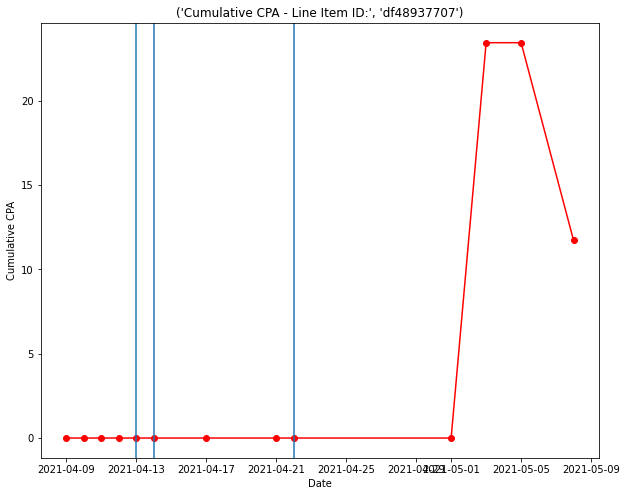

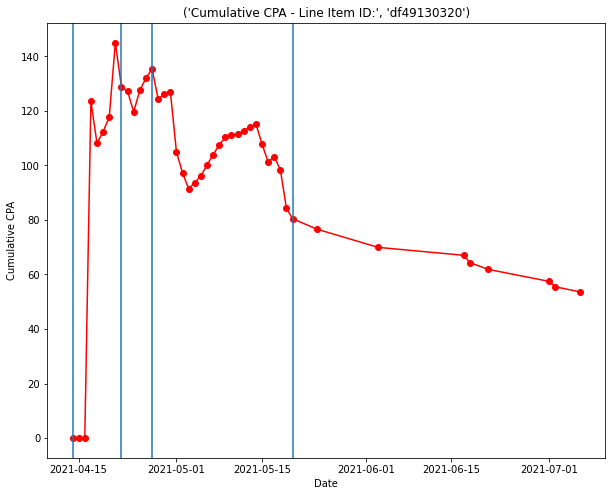

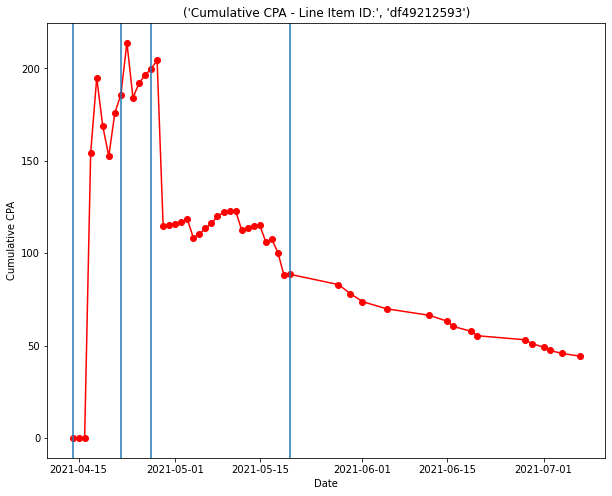

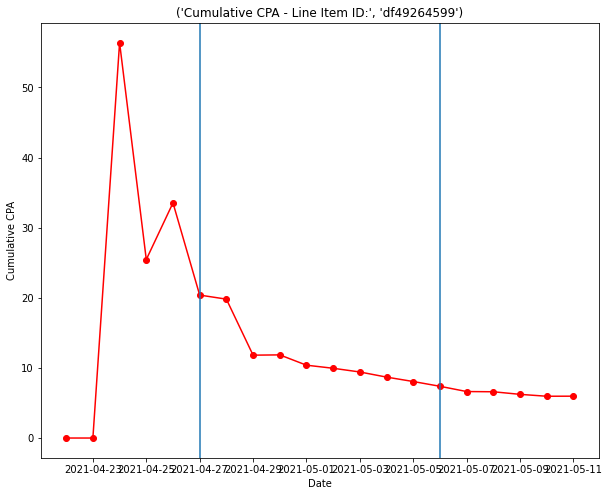

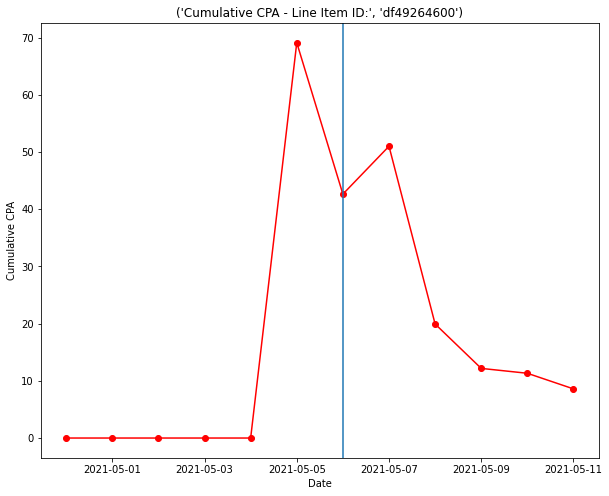

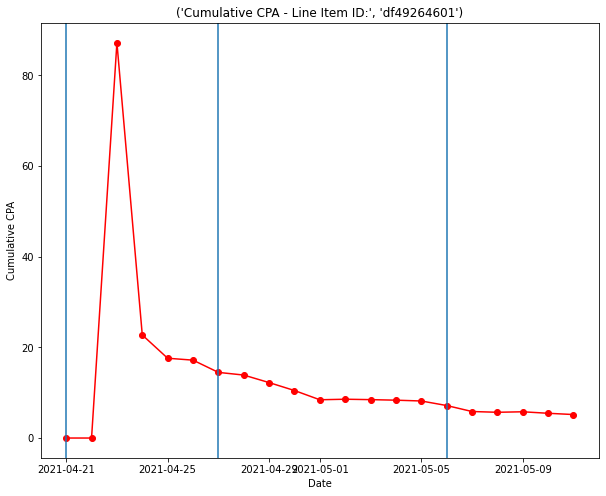

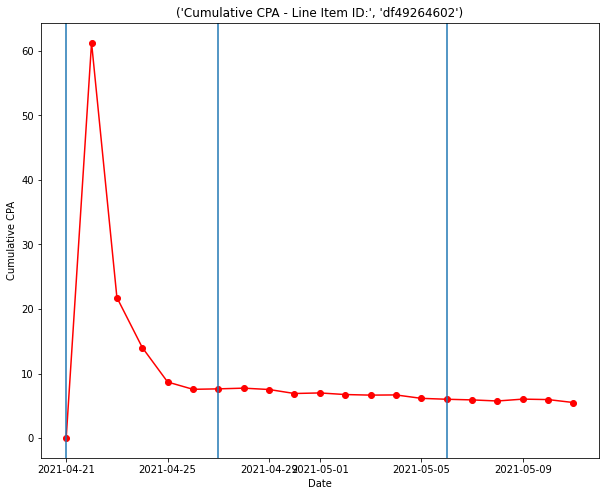

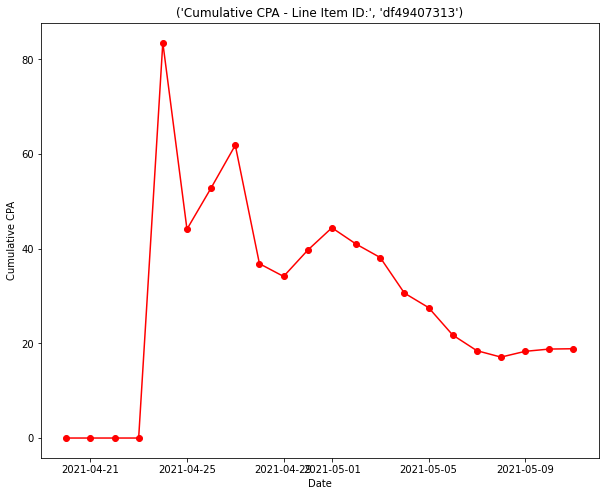

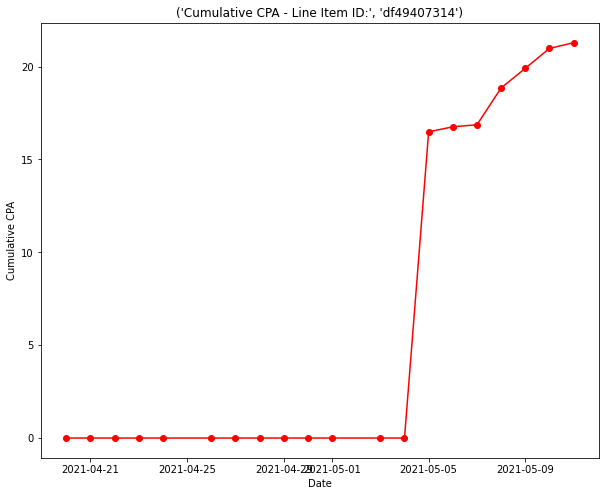

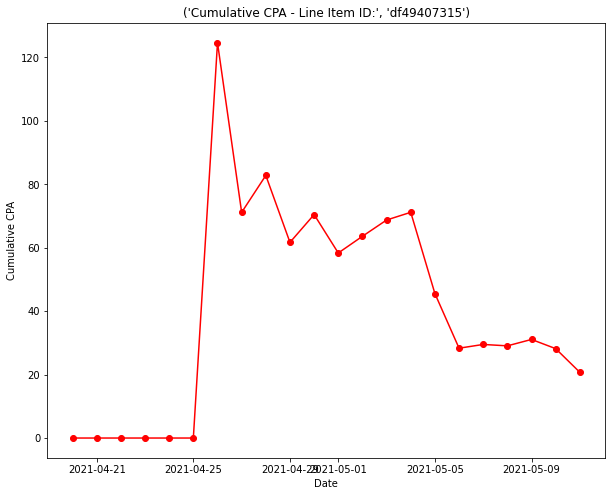

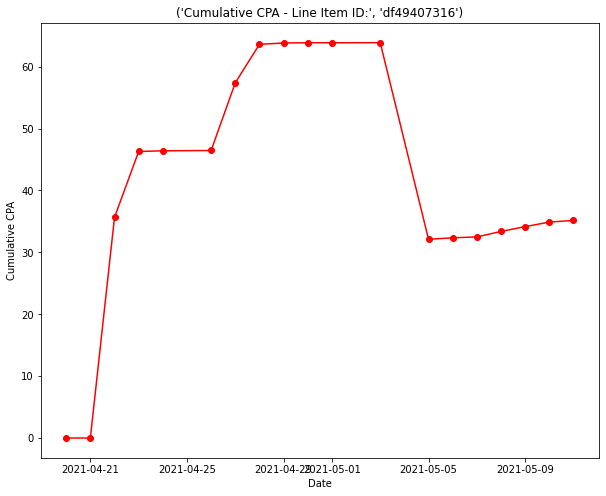

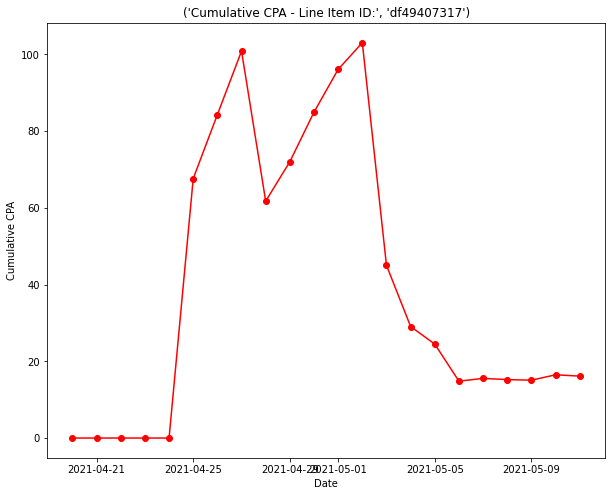

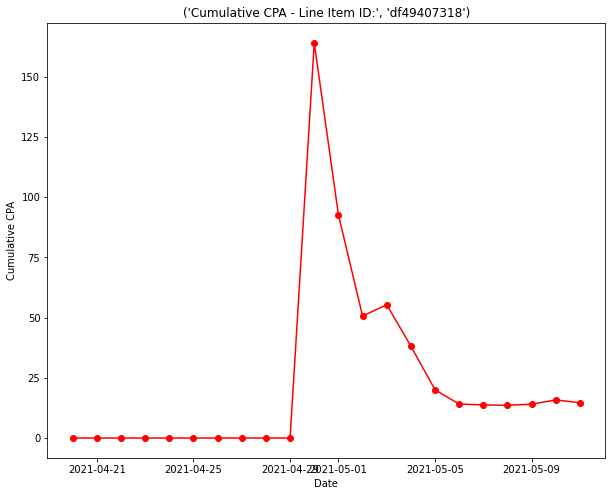

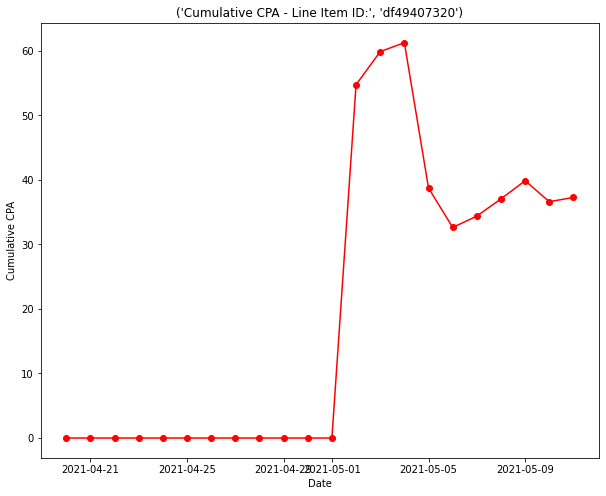

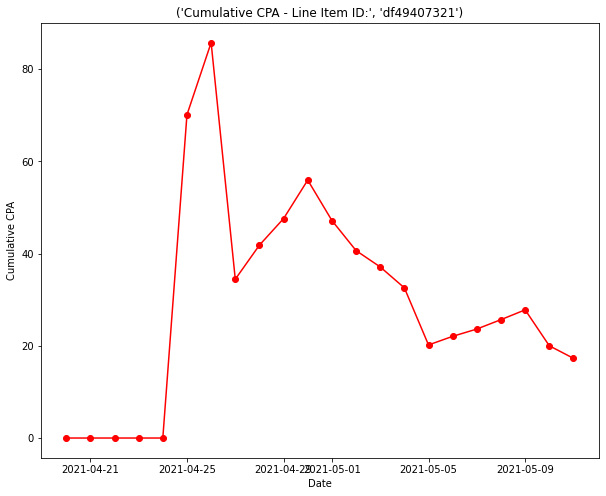

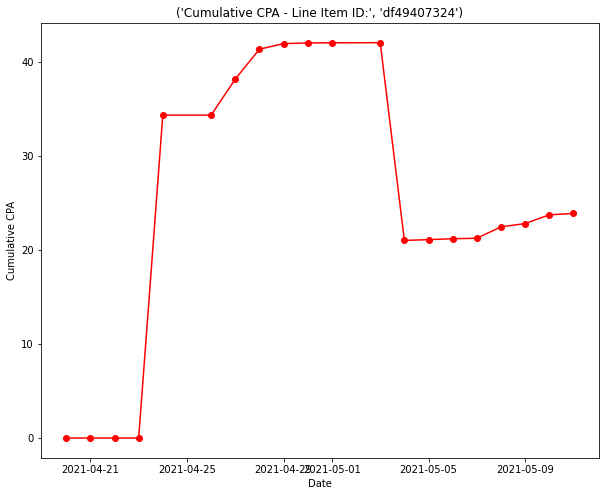

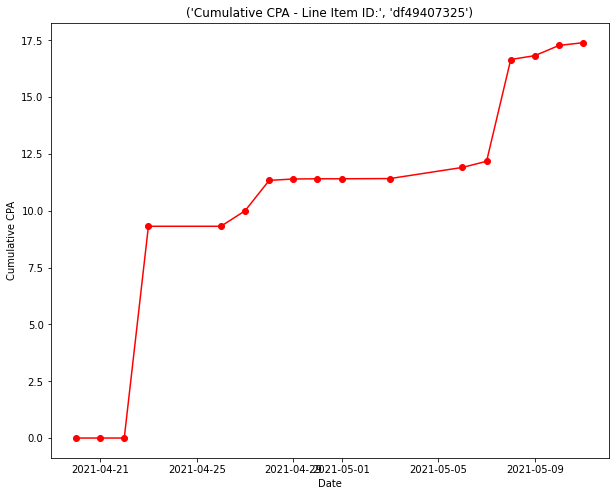

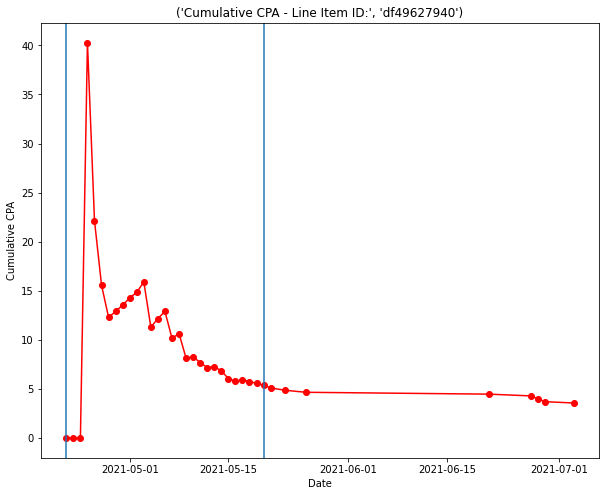

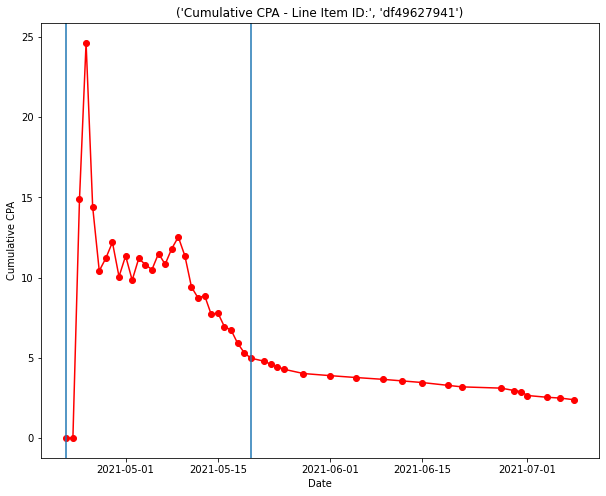

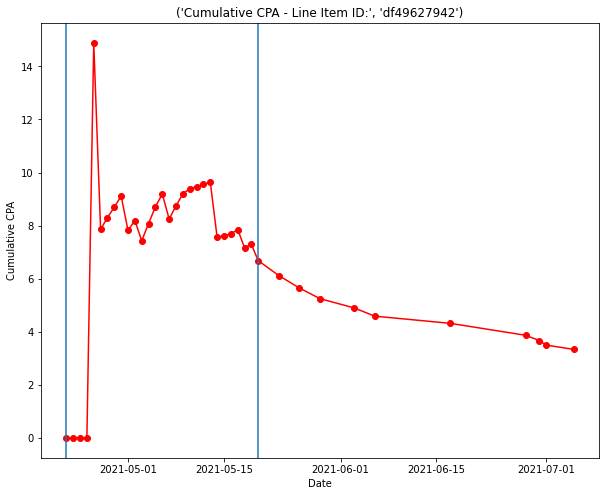

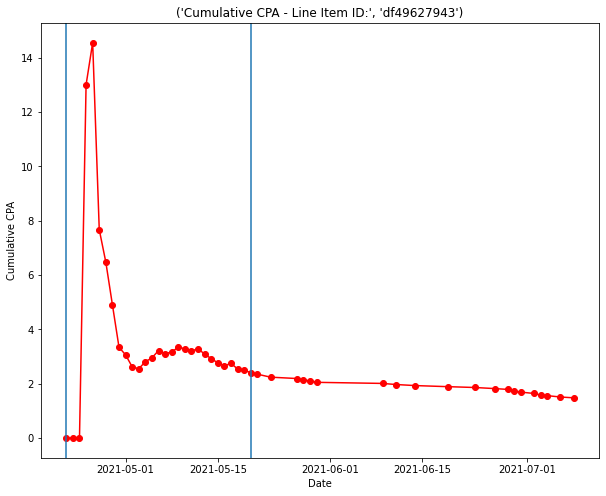

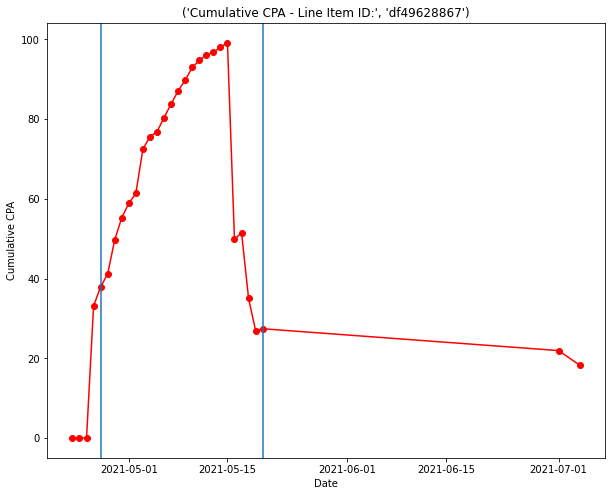

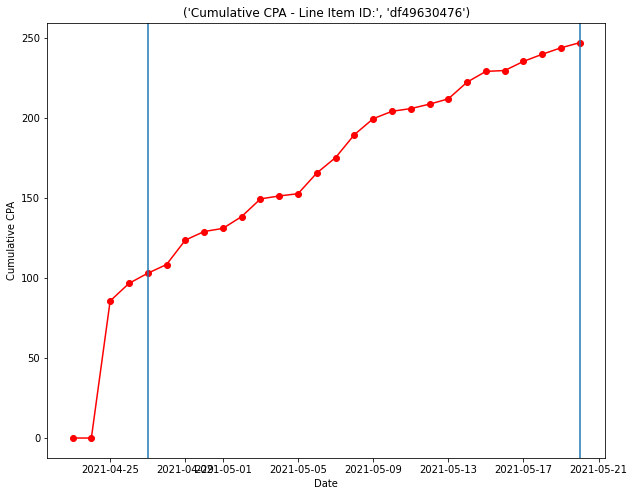

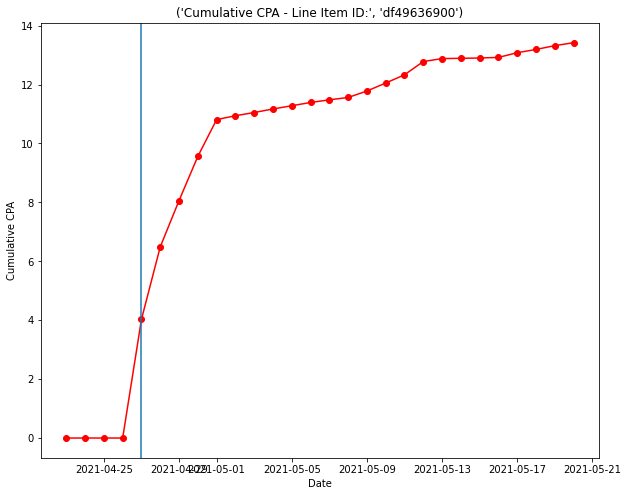

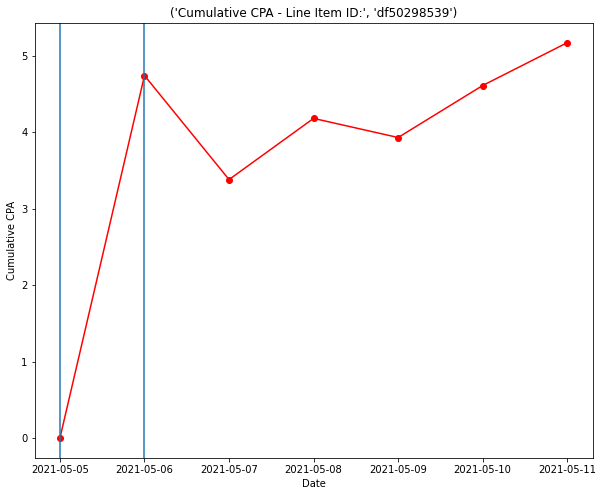

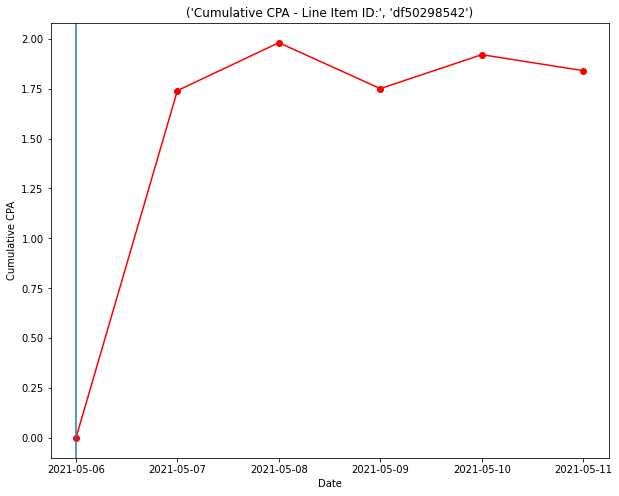

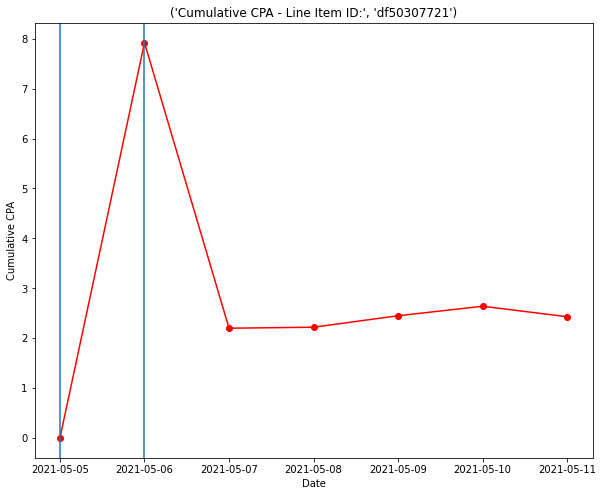

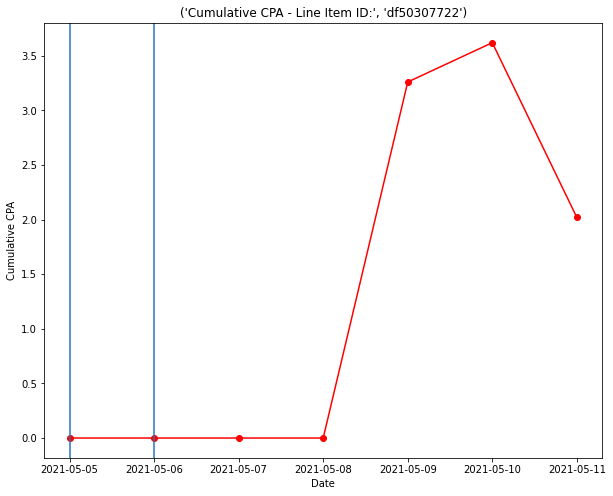

In [149]:
for key in data_dict_cpa_changes.keys():
    plot_cpa_with_changes(key)